# One Shot Learning for Computing Face Similarities using Siamese Network

In [4]:
import os
import re
import pickle
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import face_recognition
#import dlib
from utilities import face_detect, face_draw

from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

import tensorflow as tf
from utilities.pca_plotter import PCAPlotter

## Create Datasets

In [5]:
create = False

In [6]:
def load_images(images_folder, n_persons, n_samples, face_size=(100,100),
                search_limit=10, train_persons_list=[], diagnose=False):
    '''
    images_folder: images folder to load images
    '''
    # init info holders
    X_images = []
    X_embeds = []
    y = []
    videos_dict = dict()
    persons_dict = dict()
    failed_persons = []
    # init counters
    label = 0
    count = 0
    trial = 0
    
    # get names of all available persons
    persons = [folder for folder in os.listdir(images_folder) \
               if os.path.isdir(os.path.join(images_folder,folder))]
    # load a random person's data
    while len([*persons_dict]) < n_persons:
        person = np.random.choice(persons, 1)[0]
        if person in [*persons_dict] or person in train_persons_list or person in failed_persons:
            print(person,'was checked before!')
            continue
        print('- loading data for: ' + person)
        videos_path = os.path.join(images_folder, person)
        videos = os.listdir(videos_path)
        person_images = []
        person_embeds = []
        frame_sample_list = []
        while len(person_images) < n_samples and trial < search_limit:
            trial+=1
            video_sample = np.random.choice(videos, 1)[0]
            frames_path = os.path.join(videos_path, video_sample)
            frames = os.listdir(frames_path)
            frame_sample = np.random.choice(frames, 1)[0]
            if frame_sample in frame_sample_list:
                print('     (',frame_sample,'frame was used before!)')
                continue
            #person_dict[count] = (person, video)
            frame_path = os.path.join(frames_path, frame_sample)
            frame_image = cv2.cvtColor(cv2.imread(frame_path), cv2.COLOR_BGR2RGB)
            face_output = face_detect.detect_faces_in_images(frame_path,
                                                             detector='onnx',
                                                             recognizer='facenet',
                                                             lib='pil',
                                                             report=False,
                                                             show_images=diagnose,
                                                             save_images=False,
                                                             label_faces=True,
                                                             show_landmarks=False,
                                                             show_axes=False,
                                                             return_option='dict')

            face_locations = face_output['location']
            face_embeddings = face_output['embedding']
            
            #face_locations_r = read_face_locations(frame_path)
            #report_dict = {'process_time':0,'labels_probs':0, 'channels':'rgb'}
            #labeled_image = face_draw.face_locations(frame_image,report_dict,face_locations, None, show_points=True)
            #cv2.imshow('output',labeled_image)
            #cv2.waitKey(0)            
            #print(face_locations, face_locations_r)
            print('   - frame file: {0} - (number of faces: {1})'.format(frame_sample,len(face_locations)))
            if len(face_locations) == 1:
                # face image
                top,right,bottom,left = face_locations[0]
                face_image = frame_image[top:bottom,left:right]
                if diagnose:
                    cv2.imshow('output',cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR))
                    cv2.waitKey(0)
                # try to crop resize the image
                try:
                    face_image = cv2.resize(face_image, face_size)
                # if error, then take another trial
                except:
                    continue
                if diagnose:
                    cv2.imshow('output',cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR))
                    cv2.waitKey(0)
                person_images.append(face_image)
                # face embed
                face_embed = np.expand_dims(face_embeddings[0], axis=1)
                person_embeds.append(face_embed)
                # add data
                frame_sample_list.append(frame_sample)
                y.append(label)

        print('     (number of trials: {0} - number of samples: {1})'.format(trial, len(person_images)))
        if trial == search_limit and len(person_images) != n_samples:
            print("    ", person, "search limit was reached!. Look for another person's data")
            failed_persons.append(person)
        else:
            try:
                X_images.append(np.stack(person_images))
                X_embeds.append(np.stack(person_embeds))
            except ValueError as e:
                print('Error: ', e)
                #print("error - person_images: ", person_images)
            persons_dict[person] = [count, count+n_samples-1]
            count+=n_samples
            label+=1
        trial=0
    if diagnose: cv2.destroyAllWindows()
    X_images = np.stack(X_images)
    X_embeds = np.stack(X_embeds)
    y = np.vstack(y)
    print('selected persons:', [*persons_dict])
    return X_images, X_embeds, y, persons_dict

In [7]:
images_path = 'input/frame_images_DB'
n_persons = 100
n_samples = 20
trials = 100
face_size = (100,100)

if create:    
    X_images_train, X_embeds_train, y_train, persons_dict_train = load_images(images_path, n_persons, n_samples, 
                                                                          face_size, trials, diagnose=False)

In [8]:
if create:
    file_name = "train_npersons_{}_nsamples_{}.pickle".format(n_persons, n_samples)

    with open("output/train_test_data/"+file_name, "wb") as f:
        pickle.dump((X_images_train, X_embeds_train, y_train, persons_dict_train),f)

In [9]:
if create:
    n_persons = 20
    X_images_test, X_embeds_test, y_test, persons_dict_test = load_images(images_path, n_persons, n_samples, 
                                                                      face_size, trials, diagnose=False,
                                                                      train_persons_list=[*persons_dict_train])

In [10]:
if create:
    file_name = "test_npersons_{}_nsamples_{}.pickle".format(n_persons, n_samples)

    with open("output/train_test_data/"+file_name, "wb") as f:
        pickle.dump((X_images_test, X_embeds_test, y_test, persons_dict_test),f)

- Note: Youtube Faces DB include face locations as well. However, we used our face detector to get all face locations. 

## Loading Datasets

In [11]:
from utilities.models.facenet1.inception_resnet_v1 import InceptionResNetV1

def facenet_embeddings(X_images, method='array', option=1):
    
    if option == 1:
        # https://sefiks.com/2018/09/03/face-recognition-with-facenet-in-keras/
        # https://github.com/serengil/tensorflow-101/blob/master/model/inception_resnet_v1.py
        facenet_model = InceptionResNetV1()
        #pre-trained weights https://drive.google.com/file/d/1971Xk5RwedbudGgTIrGAL4F7Aifu7id1/view?usp=sharing
        weights_path = "utilities/models/facenet1/facenet_weights.h5"
        facenet_model.load_weights(weights_path)
    elif option ==2:
        # https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
        # https://github.com/nyoki-mtl/keras-facenet
        facenet_path = "utilities/models/facenet2/facenet_keras.h5"
        facenet_model = keras.models.load_model(facenet_path, compile=False)
        weights_path = "utilities/models/facenet2/facenet_keras_weights.h5"
        facenet_model.load_weights(weights_path)
        #facenet_model.summary()
        #keras.utils.plot_model(facenet_model, "mini_resnet.png", show_shapes=True)
    print('Face recognizer (facenet{}) was loaded'.format(option))
    
    n_persons, n_examples, h, w, c = X_images.shape
    
    if method == 'list':
        X_embeds = []
        for images in X_images:
            for image in images:
                faces = face_detect.facenet_preprocessing(image)
                face_embeddings = facenet_model.predict(faces)
                face_embeddings = np.transpose(face_embedding)
                X_embeds.append(face_embeddings)
        X_embeds = np.asarray(X_embeds).reshape(n_persons, n_examples, 128, 1)
        
    elif method == 'array':
        X_embeds = np.zeros((n_persons, n_examples, 128, 1), dtype='float64')
        for person in range(n_persons):
            for example in range(n_examples):
                image = X_images[person, example]
                face = face_detect.facenet_preprocessing(image)
                face_embeddings = facenet_model.predict(face)
                face_embeddings = [face_embedding.astype('float32') for face_embedding in face_embeddings]
                face_embeddings = np.transpose(face_embeddings)
                X_embeds[person, example] = face_embeddings
    return X_embeds

In [12]:
n_persons = 1000
n_samples = 2
train_file_name = "train_npersons_{}_nsamples_{}.pickle".format(n_persons, n_samples)

with open("output/train_test_data/"+train_file_name, "rb") as f:
    (X_images_train, X_embeds_train, y_train, persons_dict_train) = pickle.load(f)
    
X_embeds_fn1_train = facenet_embeddings(X_images_train, option=1)
X_embeds_fn2_train = facenet_embeddings(X_images_train, option=2)
    
n_persons = 100
n_samples = 2
test_file_name = "test_npersons_{}_nsamples_{}.pickle".format(n_persons, n_samples)
    
with open("output/train_test_data/"+test_file_name, "rb") as f:
   (X_images_test, X_embeds_test, y_test, persons_dict_test) =  pickle.load(f)

X_embeds_fn1_test = facenet_embeddings(X_images_test, option=1)
X_embeds_fn2_test = facenet_embeddings(X_images_test, option=2)

Face recognizer (facenet1) was loaded
Face recognizer (facenet2) was loaded
Face recognizer (facenet1) was loaded
Face recognizer (facenet2) was loaded


In [16]:
print('train: ', [*persons_dict_train])
print('test: ', [*persons_dict_test])

train:  ['Sarah_Weddington', 'James_Kopp', 'Frank_Abagnale_Jr', 'Aleksander_Kwasniewski', 'Gabrielle_Union', 'Peter_Max', 'Theresa_Gattung', 'Wolfgang_Schneiderhan', 'Warren_Buffett', 'Tim_Matheson', 'Aaron_Eckhart', 'Akmal_Taher', 'Takeo_Fukui', 'Martin_Landau', 'Jane_Pauley', 'Ralph_Nader', 'Richard_Harris', 'Patrice_Chereau', 'Caroline_Kennedy', 'Patti_Labelle', 'Adrien_Brody', 'Charlton_Heston', 'Nadia_Petrova', 'Harrison_Ford', 'Tian_Liang', 'Tom_McClintock', 'Gary_Forsee', 'Leticia_Van_de_Putte', 'Nick_Reilly', 'Paul_Krueger', 'William_Bratton', 'Clay_Aiken', 'Zoran_Djindjic', 'Alex_King', 'Ilan_Goldfajn', 'Janis_Ruth_Coulter', 'Maria_Guida', 'Maria_Bello', 'Lance_Bass', 'Marion_Barry', 'Barbara_Becker', 'Nick_Markakis', 'Natalie_Stewart', 'Jane_Fonda', 'Prince_Philippe', 'Zhong_Nanshan', 'Vivica_Fox', 'Elgin_Baylor', 'Dave_Barr', 'Vincent_Gallo', 'James_Traficant', 'Robert_Nardelli', 'Terry_McAuliffe', 'Ricardo_Lopez_Murphy', 'Amy_Brenneman', 'Jason_Biggs', 'Chris_Thomas', 'Cath

In [17]:
images_shape = X_images_train[0][0].shape
embeds_shape = X_embeds_train[0][0].shape

print('- images shape: {} - embeddings shape: {}'.format(images_shape, embeds_shape))

- images shape: (100, 100, 3) - embeddings shape: (128, 1)


In [18]:
train_embeds_shape = X_embeds_fn1_train[0][0].shape
test_embeds_shape = X_embeds_fn1_test[0][0].shape

print('facenet1: - train embeddings shape: {} - test embeddings shape: {}'.format(train_embeds_shape, 
                                                                                  test_embeds_shape))

train_embeds_shape = X_embeds_fn2_train[0][0].shape
test_embeds_shape = X_embeds_fn2_test[0][0].shape

print('facenet2: - train embeddings shape: {} - test embeddings shape: {}'.format(train_embeds_shape, 
                                                                                  test_embeds_shape))

facenet1: - train embeddings shape: (128, 1) - test embeddings shape: (128, 1)
facenet2: - train embeddings shape: (128, 1) - test embeddings shape: (128, 1)


## Get Functions

### Get Pairs

In [66]:
def get_pairs(batch_size=None, train=True, embed=False, normalize=False, flatten=False,
              flip_same=False, do_shuffle=True, embed_option=None):
    """ Create batch size pairs (first half: different persons - second half: same persons)"""
    
    # select data
    if train:
        if embed:
            if embed_option == 'face_recognition' or embed_option is None:  
                X =  X_embeds_train
            elif embed_option == 'facenet1':
                X =  X_embeds_fn1_train
            elif embed_option == 'facenet2':
                X =  X_embeds_fn2_train
                
            flip_same = False
            normalize = False
            flatten = False
        else:
            X = X_images_train
    else:
        if embed:
            if embed_option == 'face_recognition' or embed_option is None:  
                X =  X_embeds_test
            elif embed_option == 'facenet1':
                X =  X_embeds_fn1_test
            elif embed_option == 'facenet2':
                X =  X_embeds_fn2_test

            flip_same = False
            normalize=False
        else:
            X = X_images_test

    # if batch is not defined then take all examples (one for each person)
    if batch_size == None:
        batch_size = X.shape[0]
        
    # extract shape parameters
    if len(X.shape) == 5:
        n_persons, n_examples, h, w, n_channels = X.shape
        shape = (batch_size, h, w, n_channels)
        dtype = int
    else: 
        n_persons, n_examples, h, n_channels = X.shape
        shape = (batch_size, h, n_channels)
        dtype = float
        
    assert n_persons >= batch_size, "n_persons ({}) should be >= batch_size ({})".format(n_persons, 
                                                                                         batch_size)
    # sample diffirent persons (without replacement) based on the batch size
    persons = np.random.choice(n_persons, size=(batch_size,),replace=False)
    # initialize a pairs of a batch size
    pairs = [np.zeros(shape, dtype=dtype) for i in range(2)] # images int !!!!!!!!!
    # initialize targets
    targets = np.zeros((batch_size,))
    # second half is when the person is the same! 
    targets[batch_size//2:] = 1
    
    # loop through persons
    for i in range(batch_size):
        person_1 = persons[i]
        # sample two different examples from n_examples (without replacement)
        idx_1, idx_2 = np.random.choice(n_examples, size=(2,), replace=False)
        # save 1st example for this person 
        pairs[0][i] = X[person_1, idx_1]
        # check if we passed half of the batch size
        if i >= batch_size//2:
            # if true then take the same person again!
            person_2 = person_1
            if flip_same:
                pairs[1][i] = np.flip(X[person_2, idx_2],axis=1)
            else:
                pairs[1][i] = X[person_2, idx_2]
        else:
            # else take another person
            person_2 = (person_1 + np.random.randint(1,n_persons)) % n_persons
            pairs[1][i] = X[person_2, idx_2]
        
    if normalize:
        pairs[0] = pairs[0]/255
        pairs[1] = pairs[1]/255
        
    # flatten
    if flatten:
        shape = (batch_size, h*w*n_channels)
        pairs[0] = np.reshape(pairs[0], shape)
        pairs[1] = np.reshape(pairs[1], shape)
        
    # shuffle
    if do_shuffle:
        pairs[0], pairs[1], targets = shuffle(pairs[0], pairs[1], targets)
    
    return pairs, targets    

### Get Oneshot

In [67]:
def get_oneshot(N, train=False, embed=False, person=None, report=False, 
                flip_same=False, normalize=False, do_shuffle=True, embed_option=None):
    """ Create pairs of test image """
        
    # select data
    if train:
        persons_dict = persons_dict_train
        if embed:
            if embed_option == 'face_recognition' or embed_option is None: 
                X =  X_embeds_train
            elif embed_option == 'facenet1':
                X =  X_embeds_fn1_train
            elif embed_option == 'facenet2':
                X =  X_embeds_fn2_train
            flip_same = False
            normalize=False
        else:
            X = X_images_train
    else:
        persons_dict = persons_dict_test
        if embed:
            if embed_option == 'face_recognition' or embed_option is None: 
                X =  X_embeds_test
            elif embed_option == 'facenet1':
                X =  X_embeds_fn1_test
            elif embed_option == 'facenet2':
                X =  X_embeds_fn2_test
            flip_same = False
            normalize=False
        else:
            X = X_images_test
        
    # extract shape parameters
    if len(X.shape) == 5:
        n_persons, n_examples, h, w, n_channels = X.shape
        #shape = (N, h, w, n_channels)
    else: 
        n_persons, n_examples, h, n_channels = X.shape
        #shape = (N, h, n_channels)
        
    assert n_persons >= N, "n_persons ({}) should be >= N ({})".format(n_persons, N)
    # sample persons N-times (based on the N-Way) (without replacement - difference persons)
    persons = np.random.choice(n_persons, size=(N,), replace=False)
    if report: print('selected persons:', persons)
    # sample N times examples (an example for each person)
    examples = np.random.randint(0, n_examples, size=(N,))
    if report: print('selected examples:', examples)
    
    # check if a person was specified
    if person is not None:
        # find specific person index as a true person
        true_person = [*persons_dict].index(person)
        # check if true person is not in the list
        if true_person in persons:
            # if in the list, then find its key
            true_person_key = np.where(persons==true_person)[0][0]
        # if not in the list then add as first
        else:
            persons[0] = true_person
            true_person_key = 0
    else:
        # take the first person as a true person
        true_person = persons[0]
        true_person_key = 0 
    if report: print('selected person: name:{}, index:{}, key:{}'.format(person, true_person, true_person_key))
    if report: print('selected persons:', persons)
    
    # sample two different examples from n_examples (without replacement)
    ex1, ex2 = np.random.choice(n_examples, size=(2,), replace=False)
    if report: print('selected true person examples:', ex1, ex2)
    # copy true person (1st sampled example) image N times
    test_image = np.asarray([X[true_person, ex1]]*N)#.reshape(N, w, h, n_channels)
    # copy persons images (sampled exampled - including true person)
    support_set = X[persons, examples, :, :]
    if report: print("test images (true person N times) and support images (inc. 1 true person) were created")
    
    # change the example for the true person to the second one (assures diff examples!)
    if not embed and flip_same:
        support_set[true_person_key] = np.flip(X[true_person, ex2],axis=1)
    else:
        support_set[true_person_key] = X[true_person, ex2]
    
    if normalize:
        if embed:
            normalizer = Normalizer(norm="L2") # does not need fit
            test_image = normalizer.trasform(test_image) 
            support_set = normalizer.trasform(support_set)
        else:
            test_image = test_image/255
            support_set = support_set/255
        
    # create target values
    targets = np.zeros((N,))
    
    # edit test image label
    targets[true_person_key] = 1
    
    # shuffle
    if do_shuffle:
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
    
    # create pair of images
    pairs = [test_image, support_set]
    
    return pairs, targets

## Visualization

### Functions

In [68]:
def concat_images(X, targets):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    n_examples, h, w, n_channels = X.shape
    n = np.ceil(np.sqrt(n_examples)).astype("int8")
    img = np.ones((n*w, n*h, n_channels)).astype("int8")*255
    x = 0
    y = 0
    for example in range(n_examples):
        img[x*w:(x+1)*w,y*h:(y+1)*h,:] = X[example]
        cv2.putText(img[x*w:(x+1)*w,y*h:(y+1)*h,:], '{}'.format(int(targets[example])), (50,50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def show_Nway(pairs, targets):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,200))
    ax1.imshow(pairs[0][1])
    img = concat_images(pairs[1], targets)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def show_pairs(example_pairs, example_targets, deflatten=False):
    n = len(example_pairs[0])
    fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(5,n*2))
    for row in range(n):
        for col in range(2):
            if deflatten:
                axs[row,col].imshow(np.reshape(example_pairs[col][row], (100,100,3)))#, cmap='binary')
            else:
                axs[row,col].imshow(example_pairs[col][row])
            if col == 1:
                axs[row,col].annotate(xy=(100//2,100//2), s=str(int(example_targets[row])), c='w', fontsize=18)
            axs[row,col].set_xticks([])
            axs[row,col].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

### Example 1: show pairs

In [22]:
example_pairs, example_targets = get_pairs(batch_size=32, train=True, embed=False, flatten=True)

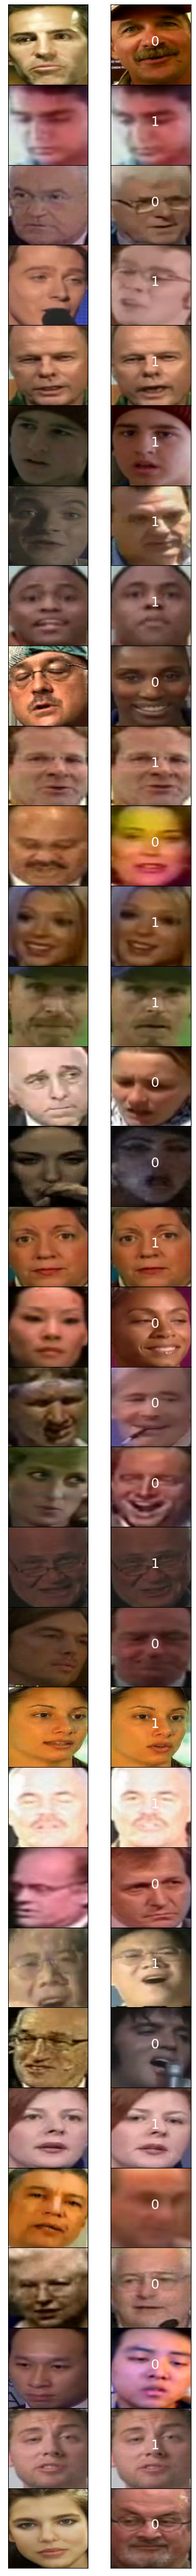

In [23]:
show_pairs(example_pairs, example_targets, deflatten=True)

### Example 2: show oneshot

In [24]:
example_pairs, example_targets = get_oneshot(N=9, train=True, embed=False, normalize=False)

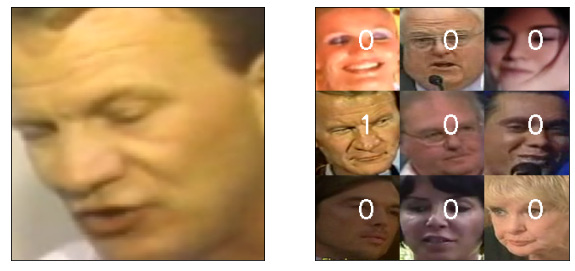

In [25]:
show_Nway(example_pairs, example_targets)

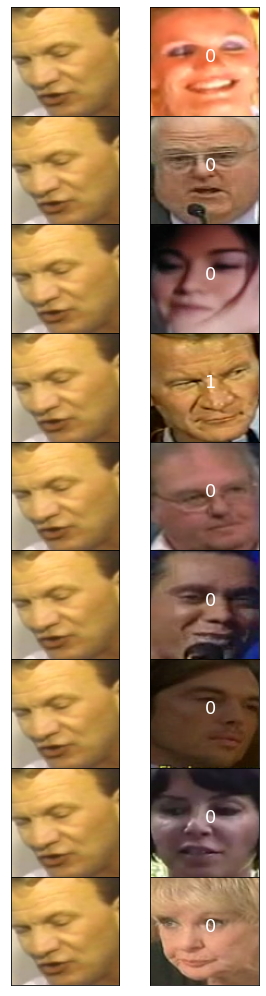

In [26]:
show_pairs(example_pairs, example_targets)

##  Test Oneshot Model

In [119]:
def test_oneshot(model, N, k, train=False, embed=False, normalize=False, do_shuffle=True, verbose=False,
                 combine=False, embed_option=None):
    """ Test average one-shot learning accuracy based on N-way
    Arguments:
    - model: Siamese Network
    - N: Number of pairs (at which only one pair matches) to be tested in each one prediction test
    - k: Number of prediction tests to perform
    - train: Boolean, True if training and False if testing
    - verbose: Boolean.
    """
    # initialize number of correct predictions
    n_correct = 0
    for i in range(k):
        inputs, targets = get_oneshot(N, train, embed=embed, normalize=normalize, do_shuffle=do_shuffle, 
                                      embed_option=embed_option)
        if combine:
             inputs = combine_pairs(inputs)
        probs = model.predict(inputs)
        print(probs, np.argmax(probs), np.argmax(targets))
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = n_correct/k
    if verbose:
        text = "train" if train else "test"
        print("[{}] oneshot learning accuracy: {}% (evaluated by {} N-Way for {} times)".format(text, 
                                                                            int(100*percent_correct), 
                                                                                            N, k))
    return percent_correct

## Siamese Model (Pairs)

In [33]:
def init_weights(shape, dtype=None, name=None):
    return np.random.normal(loc=0.0, scale=1e-2, size=shape)

def init_bias(shape, dtype=None, name=None):
    return np.random.normal(loc=0.5, scale=1e-2, size=shape)

def get_conv(input_shape, name=None, model=None, app='images', learn='before_l2'):
    if app == 'images':
        input_layer = keras.Input(input_shape, name='{}_input_layer'.format(name))
        if model == None:
            model = keras.Sequential(name='siamese_{}'.format(app))
            model.add(layers.Conv2D(64, (10,10), activation='relu', kernel_regularizer=l2(2e-4), input_shape=input_shape,
                                kernel_initializer=init_weights, bias_initializer=init_bias))
            model.add(layers.MaxPooling2D(strides=2))
            model.add(layers.Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias))
            model.add(layers.MaxPooling2D(strides=2))
            model.add(layers.Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias))
            model.add(layers.MaxPooling2D(strides=2))
            model.add(layers.Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias))
            model.add(layers.Flatten())
            model.add(layers.Dense(4096, activation='sigmoid', kernel_regularizer=l2(2e-4),
                                   kernel_initializer=init_weights, bias_initializer=init_bias))
            encoded = model(input_layer)
            return encoded, input_layer, model
        else:
            encoded = model(input_layer)
            return encoded, input_layer
    elif app == 'embeds':
        input_layer = keras.Input(input_shape, name='{}_input_layer'.format(name))
        if model == None:
            model = keras.Sequential(name='siamese_{}'.format(app))
            model.add(layers.Flatten())
            if learn == 'before_l2' or learn == 'before_after_l2':
                model.add(layers.Dense(256, activation='relu'))
            encoded = model(input_layer)
            return encoded, input_layer, model
        else:
            encoded = model(input_layer)
            return encoded, input_layer
        
    
def init_siamse_model(input_shape, app='images', learn='before_l2'):
    
    if app=='images' and (learn == 'before_l2' or learn == 'only_l2'):
        print("When app='images', learn='before_l2 and learn='only_l2' give exactly the same model")
        print(" - in both cases, a learning layers has to be added before calculating l2 distance")
    
    # encode
    left_encoded, left_input, model = get_conv(input_shape, name="left", app=app, learn=learn)
    right_encoded, right_input = get_conv(input_shape, name="right", model=model, app=app)
    
    # compute the absolute difference (cosine loss function)
    L1_layer = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]), name='abs_diff')
    L1_distance = L1_layer([left_encoded, right_encoded])
    
    if learn == 'after_l2' or learn == 'before_after_l2':
        learn_layer = layers.Dense(64, activation='sigmoid', kernel_regularizer=l2(2e-4),
                                   kernel_initializer=init_weights, bias_initializer=init_bias)(L1_distance)
        learn_layer = layers.Dense(32, activation='sigmoid', kernel_regularizer=l2(2e-4),
                                   kernel_initializer=init_weights, bias_initializer=init_bias)(learn_layer)
        y = layers.Dense(1, activation='sigmoid', bias_initializer=init_bias, name='ouput')(learn_layer)
    
    elif learn == 'only_l2' or learn == 'before_l2':
        y = layers.Dense(1, activation='sigmoid', bias_initializer=init_bias, name='ouput')(L1_distance)

    # siamese network
    siamese_net = keras.Model(inputs=[left_input, right_input], outputs=y)
    return siamese_net

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.00006)

### Images Model

In [52]:
# learn: only_l2 (same as before_l2)
images_model_only_l2 = init_siamse_model((images_shape), app='images', learn='only_l2')
images_model_only_l2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics='accuracy')
images_model_only_l2.save_weights("output/siamese_model/images_only_l2/init_weights.h5")

# learn: after_l2 (same as before_after_l2)
images_model_after_l2 = init_siamse_model((images_shape), app='images', learn='after_l2')
images_model_after_l2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics='accuracy')
images_model_after_l2.save_weights("output/siamese_model/images_after_l2/init_weights.h5")

When app='images', learn='before_l2 and learn='only_l2' give exactly the same model
 - in both cases, a learning layers has to be added before calculating l2 distance


In [53]:
images_model_only_l2.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input_layer (InputLayer)   [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
right_input_layer (InputLayer)  [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
siamese_images (Sequential)     (None, 4096)         27426112    left_input_layer[0][0]           
                                                                 right_input_layer[0][0]          
__________________________________________________________________________________________________
abs_diff (Lambda)               (None, 4096)         0           siamese_images[1][0]      

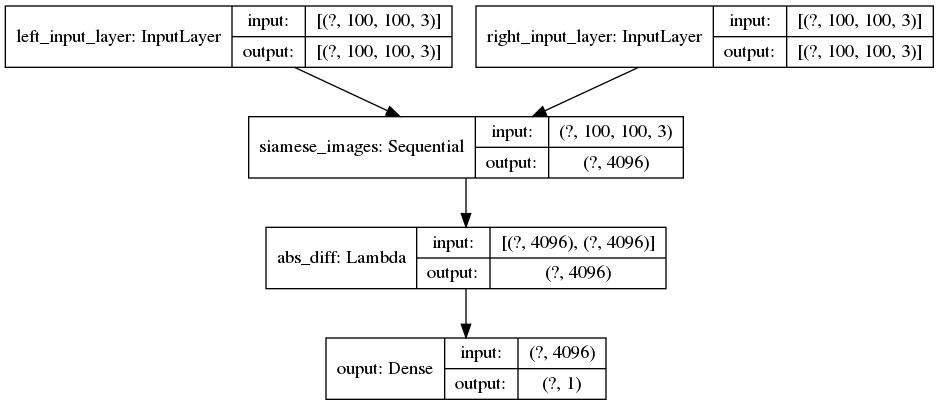

In [54]:
# requires: 1. pip install pydot and graphviz - 2. sudo apt-get install graphviz
keras.utils.plot_model(images_model_only_l2, show_shapes=True)

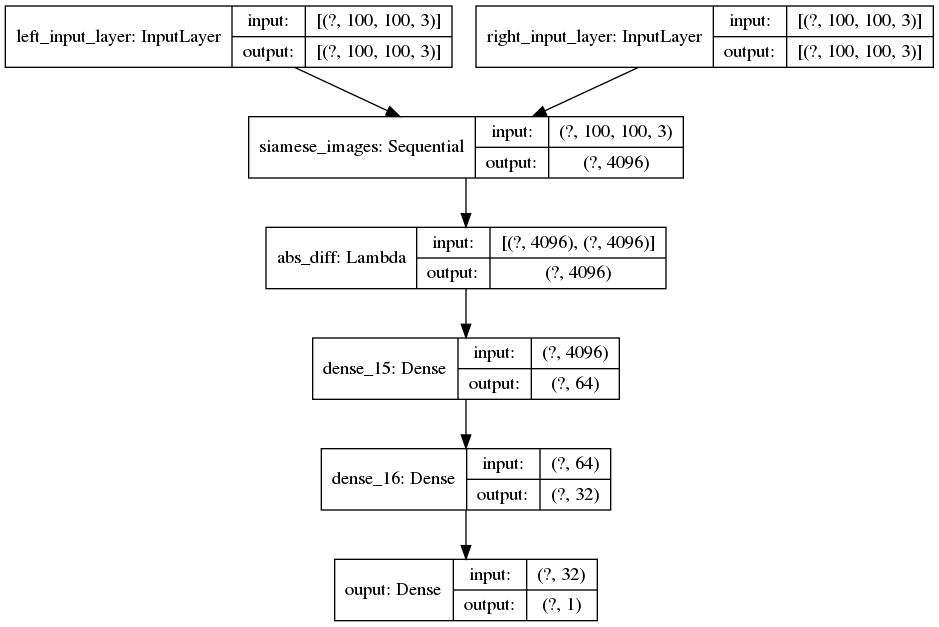

In [55]:
keras.utils.plot_model(images_model_after_l2, show_shapes=True)

### Embeds Model

In [57]:
# learn: only_l2
embeds_model_only_l2 = init_siamse_model((embeds_shape), app='embeds', learn='only_l2')
embeds_model_only_l2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics='accuracy')
embeds_model_only_l2.save_weights("output/siamese_model/embeds_only_l2/init_weights.h5")

# learn: before_l2
embeds_model_before_l2 = init_siamse_model((embeds_shape), app='embeds', learn='before_l2')
embeds_model_before_l2.compile(loss="binary_crossentropy",optimizer=optimizer, metrics='accuracy')
embeds_model_before_l2.save_weights("output/siamese_model/embeds_before_l2/init_weights.h5")

# learn: after_l2
embeds_model_after_l2 = init_siamse_model((embeds_shape), app='embeds', learn='after_l2')
embeds_model_after_l2.compile(loss="binary_crossentropy",optimizer=optimizer, metrics='accuracy')
embeds_model_after_l2.save_weights("output/siamese_model/embeds_after_l2/init_weights.h5")

# learn: before_after_l2
embeds_model_before_after_l2 = init_siamse_model((embeds_shape), app='embeds', learn='before_after_l2')
embeds_model_before_after_l2.compile(loss="binary_crossentropy",optimizer=optimizer, metrics='accuracy')
embeds_model_before_after_l2.save_weights("output/siamese_model/embeds_before_after_l2/init_weights.h5")

In [59]:
embeds_model_after_l2.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input_layer (InputLayer)   [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
right_input_layer (InputLayer)  [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
siamese_embeds (Sequential)     (None, 128)          0           left_input_layer[0][0]           
                                                                 right_input_layer[0][0]          
__________________________________________________________________________________________________
abs_diff (Lambda)               (None, 128)          0           siamese_embeds[0][0]      

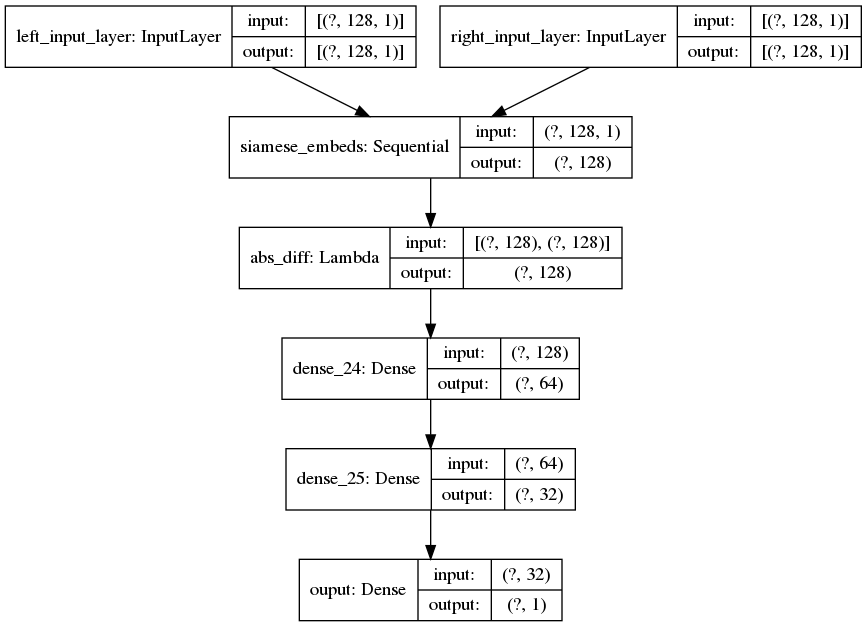

In [60]:
keras.utils.plot_model(embeds_model_after_l2, show_shapes=True)

## Siamese Network Training

In [81]:
def siamese_train(epochs=10, batch_size=64, train_type='batch', save_weights='final', eval_freq=2,
                  n_way=10, n_test=10, embed=False, normalize=False, do_shuffle=True, plot=True, 
                  embed_option='face_recognition', learn=None):
    
    test_batch_size = X_images_test.shape[0] # should not be higher than the n_persons in test data
    nway_best = 0
    test_best = 0
    
    model_path = "output/siamese_model/"
    results = {'train_loss':[], 'train_acc':[],
               'test_loss':[], 'test_acc':[],
               'n_way_train_acc':[], 'n_way_test_acc':[]}
    
    print("starting oneshot training (evaluated by {} N-Way for {} times):".format(n_way, n_test))
    start_time = time.time()
    
    if embed:
        if learn == None or learn == 'only_l2':
            model = embeds_model_only_l2
            model_name = "embeds_only_l2"
        elif learn == 'before_l2': 
            model = embeds_model_before_l2
            model_name = "embeds_before_l2"
        elif learn == 'after_l2':
            model = embeds_model_after_l2
            model_name = "embeds_after_l2"
        elif learn == 'before_after_l2':
            model = embeds_model_before_after_l2
            model_name = "embeds_before_after_l2"
        text = "embeds"
    else:
        if learn == None or learn == 'only_l2' or learn == 'before_l2':
            model = images_model_only_l2
            model_name = "images_only_l2"
        elif learn == 'after_l2' or learn == 'before_after_l2':
            model = images_model_after_l2
            model_name = "images_after_l2"
        text = "images"
    model.load_weights(os.path.join(model_path, model_name, "init_weights.h5"))
        
        
    if normalize:
        text = 'nor_'+text
    text = text+'_bs{}_ep{}'.format(batch_size,epochs)
    
    if train_type == 'batch':
        text = 'batch_'+text
        n_persons = X_images_train.shape[0] #or X_embeds_train.shape[0]
        iters_per_epoch = n_persons//batch_size # equivalent to 1 epoch
        iters = epochs*iters_per_epoch
        print(" - epochs: {} (eq.iters: {}) - eval freq: {} - batch_size: {}".format(epochs,
                                                                                     iters,
                                                                                     eval_freq, 
                                                                                     batch_size))
        eval_freq = eval_freq*iters_per_epoch
        epochs = iters
    elif train_type == 'epoch':
        text = 'epoch_'+text
        iters_per_epoch = 1
        print(" - epochs: {} - eval freq: {} - batch_size: {}".format(epochs, eval_freq, batch_size))
        
    text = embed_option+'_'+text
        
    assert n_way <= test_batch_size, "n_way should be <= n_persons in test data"
    assert epochs >= eval_freq, "epcohs should be >= eval_freq"
    
    for epoch in range(1, epochs+1):        
            
        if train_type == 'epoch':
            X_train, y_train = get_pairs(None, train=True, embed=embed, normalize=normalize, 
                                         do_shuffle=do_shuffle, embed_option=embed_option)
            outputs = model.fit(X_train, y_train, batch_size, epochs=1, verbose=0, shuffle=False)
            outputs = [outputs.history['loss'][0],outputs.history['accuracy'][0]]
            
        elif train_type == 'batch':
            X_train, y_train = get_pairs(batch_size, train=True, embed=embed, normalize=normalize, 
                                         do_shuffle=do_shuffle, embed_option=embed_option)   
            
            outputs = model.train_on_batch(X_train, y_train)
            
        if save_weights == 'step':
            if train_type == 'batch': epoch_num = epoch//iters_per_epoch
            else: epoch_num = epoch
            model.save_weights(os.path.join(model_path, model_name, "{}_epoch_{}.h5".format(text,epoch_num)))
        
        if epoch % eval_freq == 0:
            
            results['train_loss'].append(outputs[0])
            results['train_acc'].append(outputs[1])

            X_test, y_test = get_pairs(test_batch_size, train=False, embed=embed, 
                                     normalize=normalize, do_shuffle=do_shuffle, embed_option=embed_option)
            outputs = model.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=0)

            results['test_loss'].append(outputs[0])
            results['test_acc'].append(outputs[1])
            
            train_loss = round(results['train_loss'][-1],2)
            train_acc = round(results['train_acc'][-1],2)
            test_loss = round(results['test_loss'][-1],2)
            test_acc = round(results['test_acc'][-1],2)
            
            print("----------------------------------------------------------------------------------------")
            process_time = round((time.time()-start_time) / 60.0, 1)
            print("[{}mins] epoch: {} | train loss:{} | train acc:{} |".format(process_time, 
                                                                        epoch//iters_per_epoch, 
                                                                        train_loss, train_acc))
            print("                     | test loss: {} | test acc: {} |".format(test_loss,test_acc))
            
            nway_train_acc = test_oneshot(model, n_way, n_test, train=True, embed=embed, 
                                          normalize=normalize, do_shuffle=do_shuffle, 
                                          embed_option=embed_option)
            nway_test_acc = test_oneshot(model, n_way, n_test, train=False, embed=embed, 
                                         normalize=normalize, do_shuffle=do_shuffle, 
                                         embed_option=embed_option)

            print("                     | N-Way train acc:{} | N-Way test acc:{}".format(nway_train_acc, 
                                                                                         nway_test_acc))
            results['n_way_train_acc'].append(nway_train_acc)
            results['n_way_test_acc'].append(nway_test_acc)
            

            if nway_test_acc > nway_best:
                print("          | best N-Way test acc: current={} | previous={})".format(nway_test_acc,
                                                                                          nway_best))
                nway_best = nway_test_acc
                model.save_weights(os.path.join(model_path, model_name, "{}_nway_best.h5".format(text)))
                
            if test_acc > test_best:
                print("          | best test acc: current={} | previous={})".format(test_acc, test_best))
                test_best = test_acc
                model.save_weights(os.path.join(model_path, model_name, "{}_test_best.h5".format(text)))
    
    if plot:
        plt.plot(results['train_loss'], '-r', label='Train.loss')
        plt.plot(results['train_acc'], '-g', label='Train.Acc')
        plt.plot(results['test_loss'], ':r', label='Test.loss')
        plt.plot(results['test_acc'], ':g', label='Test.Acc')
        plt.plot(results['n_way_train_acc'], '-b', label='N-way.Train.Acc')
        plt.plot(results['n_way_test_acc'], ':b', label='N-way.Test.Acc')
        plt.ylim(0,1.1)
        plt.legend(bbox_to_anchor=(1, 1))
                
    if save_weights == 'final':
        model.save_weights(os.path.join(model_path, model_name, "{}_final.h5".format(text)))
    
    with open(os.path.join(model_path, model_name, "results", "{}_results.pickle".format(text)), "wb") as f:
        pickle.dump(results,f)
                  
    #return results

## Learn Only L2
    - without normalization

### embed_option: 'face_recognition'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.71 | train acc:0.5 |
                   | test loss: 0.72 | test acc: 0.5 |
                   | N-Way train acc:0.18 | N-Way test acc:0.05
          | best N-Way train acc: current=0.05 | previous=0)
          | best test acc: current=0.5 | previous=0)
----------------------------------------------------------------------------------------
[0.1mins] epoch: 80 | train loss:0.71 | train acc:0.5 |
                   | test loss: 0.71 | test acc: 0.5 |
                   | N-Way train acc:0.3 | N-Way test acc:0.19
          | best N-Way train acc: current=0.19 | previous=0.05)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.7 | train acc:0.5 |
                   

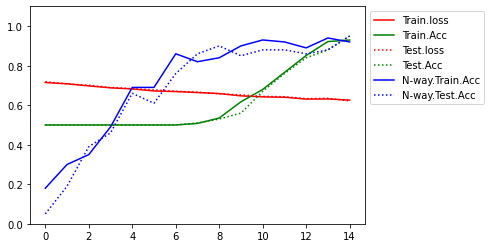

In [95]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='face_recognition', learn='only_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.71 | train acc:0.5 |
                   | test loss: 0.72 | test acc: 0.5 |
                   | N-Way train acc:0.11 | N-Way test acc:0.04
          | best N-Way train acc: current=0.04 | previous=0)
          | best test acc: current=0.5 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.7 | train acc:0.5 |
                   | test loss: 0.7 | test acc: 0.5 |
                   | N-Way train acc:0.32 | N-Way test acc:0.26
          | best N-Way train acc: current=0.26 | previous=0.04)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.69 | train acc:0.5 |
                   | test loss: 0.69

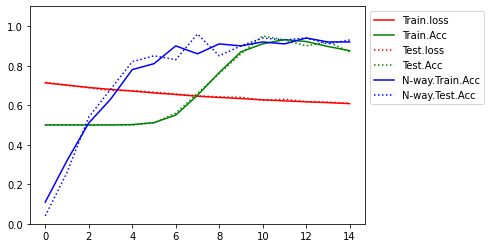

In [83]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='face_recognition', learn='only_l2')

### embed_option: 'facenet1'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.66 | train acc:0.59 |
                   | test loss: 0.64 | test acc: 0.62 |
                   | N-Way train acc:0.29 | N-Way test acc:0.21
          | best N-Way train acc: current=0.21 | previous=0)
          | best test acc: current=0.62 | previous=0)
----------------------------------------------------------------------------------------
[0.1mins] epoch: 80 | train loss:0.66 | train acc:0.58 |
                   | test loss: 0.67 | test acc: 0.53 |
                   | N-Way train acc:0.26 | N-Way test acc:0.23
          | best N-Way train acc: current=0.23 | previous=0.21)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.68 | train acc:0.59 |
           

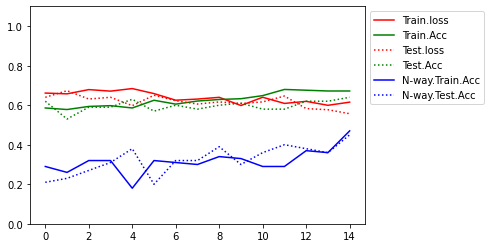

In [84]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='only_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.67 | train acc:0.6 |
                   | test loss: 0.73 | test acc: 0.57 |
                   | N-Way train acc:0.19 | N-Way test acc:0.23
          | best N-Way train acc: current=0.23 | previous=0)
          | best test acc: current=0.57 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.67 | train acc:0.6 |
                   | test loss: 0.66 | test acc: 0.6 |
                   | N-Way train acc:0.25 | N-Way test acc:0.26
          | best N-Way train acc: current=0.26 | previous=0.23)
          | best test acc: current=0.6 | previous=0.57)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss

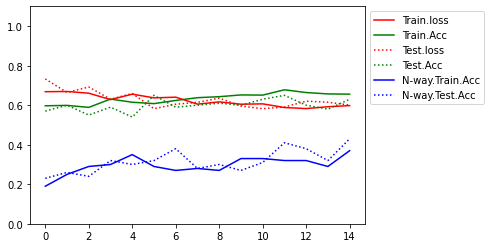

In [85]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='only_l2')

### embed_option: 'facenet2'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.65 | train acc:0.59 |
                   | test loss: 0.66 | test acc: 0.6 |
                   | N-Way train acc:0.25 | N-Way test acc:0.28
          | best N-Way train acc: current=0.28 | previous=0)
          | best test acc: current=0.6 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.67 | train acc:0.62 |
                   | test loss: 0.63 | test acc: 0.59 |
                   | N-Way train acc:0.2 | N-Way test acc:0.26
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.63 | train acc:0.62 |
                   | test loss: 0.65 | test acc: 0.63 |
                   | N

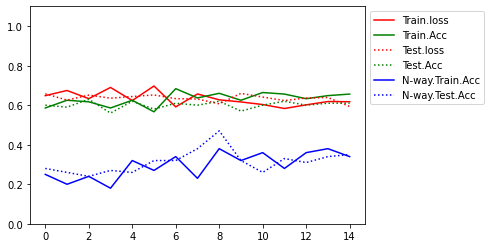

In [86]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='only_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.68 | train acc:0.59 |
                   | test loss: 0.59 | test acc: 0.6 |
                   | N-Way train acc:0.19 | N-Way test acc:0.24
          | best N-Way train acc: current=0.24 | previous=0)
          | best test acc: current=0.6 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.66 | train acc:0.6 |
                   | test loss: 0.64 | test acc: 0.61 |
                   | N-Way train acc:0.24 | N-Way test acc:0.25
          | best N-Way train acc: current=0.25 | previous=0.24)
          | best test acc: current=0.61 | previous=0.6)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss

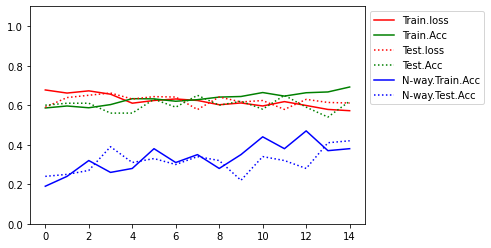

In [87]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet2', learn='only_l2')

## Learn before L2
    - without normalization

### embed_option: 'face_recognition'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.57 | train acc:0.93 |
                   | test loss: 0.56 | test acc: 0.93 |
                   | N-Way train acc:0.94 | N-Way test acc:0.93
          | best N-Way train acc: current=0.93 | previous=0)
          | best test acc: current=0.93 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.53 | train acc:0.85 |
                   | test loss: 0.51 | test acc: 0.89 |
                   | N-Way train acc:0.95 | N-Way test acc:0.91
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.51 | train acc:0.82 |
                   | test loss: 0.51 | test acc: 0.82 |
                   

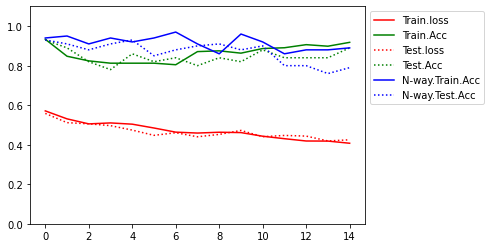

In [89]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='face_recognition', learn='before_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.61 | train acc:0.9 |
                   | test loss: 0.61 | test acc: 0.86 |
                   | N-Way train acc:0.95 | N-Way test acc:0.9
          | best N-Way train acc: current=0.9 | previous=0)
          | best test acc: current=0.86 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.57 | train acc:0.92 |
                   | test loss: 0.56 | test acc: 0.9 |
                   | N-Way train acc:0.93 | N-Way test acc:0.96
          | best N-Way train acc: current=0.96 | previous=0.9)
          | best test acc: current=0.9 | previous=0.86)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0

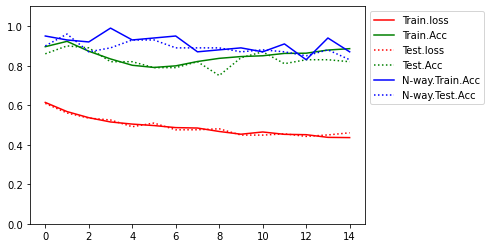

In [90]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='face_recognition', learn='before_l2')

### embed_option: 'facenet1'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.48 | train acc:0.8 |
                   | test loss: 0.54 | test acc: 0.71 |
                   | N-Way train acc:0.81 | N-Way test acc:0.62
          | best N-Way train acc: current=0.62 | previous=0)
          | best test acc: current=0.71 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.41 | train acc:0.92 |
                   | test loss: 0.55 | test acc: 0.76 |
                   | N-Way train acc:0.91 | N-Way test acc:0.68
          | best N-Way train acc: current=0.68 | previous=0.62)
          | best test acc: current=0.76 | previous=0.71)
----------------------------------------------------------------------------------------
[0.3mins] epo

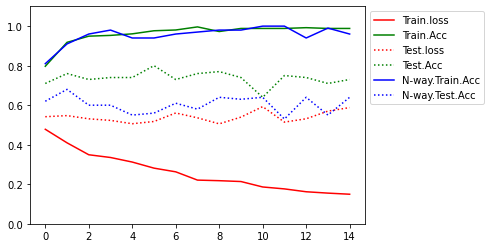

In [91]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='before_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.52 | train acc:0.73 |
                   | test loss: 0.57 | test acc: 0.71 |
                   | N-Way train acc:0.78 | N-Way test acc:0.63
          | best N-Way train acc: current=0.63 | previous=0)
          | best test acc: current=0.71 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.47 | train acc:0.81 |
                   | test loss: 0.55 | test acc: 0.7 |
                   | N-Way train acc:0.8 | N-Way test acc:0.54
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.43 | train acc:0.87 |
                   | test loss: 0.52 | test acc: 0.74 |
                   | N-Way train acc:0

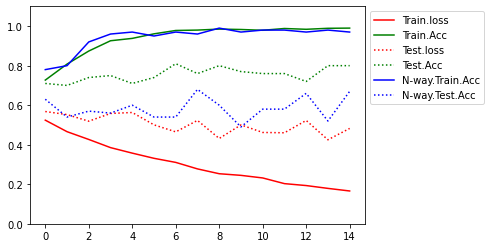

In [92]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='before_l2')

### embed_option: 'facenet2'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.56 | train acc:0.7 |
                   | test loss: 0.58 | test acc: 0.69 |
                   | N-Way train acc:0.63 | N-Way test acc:0.54
          | best N-Way train acc: current=0.54 | previous=0)
          | best test acc: current=0.69 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.49 | train acc:0.79 |
                   | test loss: 0.58 | test acc: 0.65 |
                   | N-Way train acc:0.83 | N-Way test acc:0.54
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.47 | train acc:0.81 |
                   | test loss: 0.59 | test acc: 0.73 |
                   |

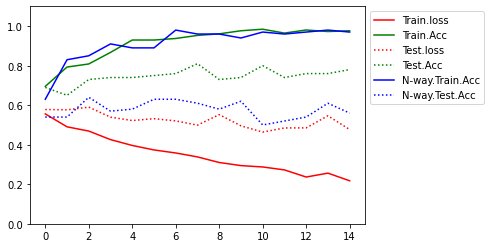

In [93]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet2', learn='before_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.53 | train acc:0.72 |
                   | test loss: 0.6 | test acc: 0.62 |
                   | N-Way train acc:0.62 | N-Way test acc:0.53
          | best N-Way train acc: current=0.53 | previous=0)
          | best test acc: current=0.62 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.48 | train acc:0.79 |
                   | test loss: 0.57 | test acc: 0.71 |
                   | N-Way train acc:0.81 | N-Way test acc:0.52
          | best test acc: current=0.71 | previous=0.62)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.44 | train acc:0.85 |
                   | test loss: 0.59

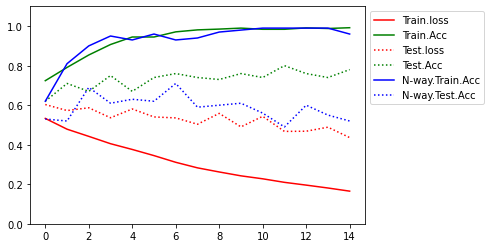

In [94]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet2', learn='before_l2')

## Learn Before and After L2
    - without normalization

### embed_option: 'face_recognition'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.67 | train acc:0.73 |
                   | test loss: 0.68 | test acc: 0.71 |
                   | N-Way train acc:0.97 | N-Way test acc:0.96
          | best N-Way train acc: current=0.96 | previous=0)
          | best test acc: current=0.71 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.6 | train acc:0.79 |
                   | test loss: 0.61 | test acc: 0.77 |
                   | N-Way train acc:0.86 | N-Way test acc:0.91
          | best test acc: current=0.77 | previous=0.71)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.5 | train acc:0.88 |
                   |

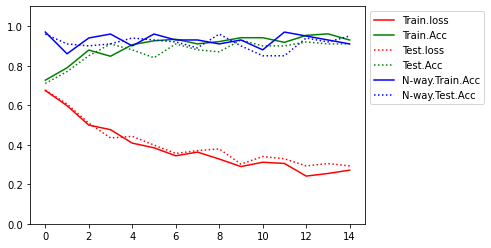

In [96]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='face_recognition', learn='before_after_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.69 | train acc:0.83 |
                   | test loss: 0.69 | test acc: 0.81 |
                   | N-Way train acc:0.92 | N-Way test acc:0.92
          | best N-Way train acc: current=0.92 | previous=0)
          | best test acc: current=0.81 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.69 | train acc:0.72 |
                   | test loss: 0.69 | test acc: 0.63 |
                   | N-Way train acc:0.99 | N-Way test acc:0.97
          | best N-Way train acc: current=0.97 | previous=0.92)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.69 | train acc:0.59 |
                   | test lo

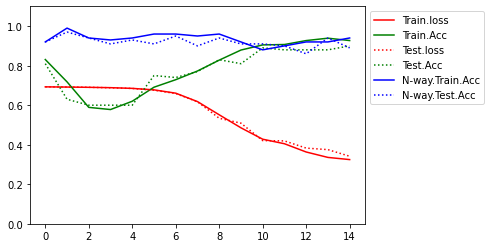

In [97]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='face_recognition', learn='before_after_l2')

### embed_option: 'facenet1'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.61 | train acc:0.84 |
                   | test loss: 0.62 | test acc: 0.79 |
                   | N-Way train acc:0.99 | N-Way test acc:0.98
          | best N-Way train acc: current=0.98 | previous=0)
          | best test acc: current=0.79 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.54 | train acc:0.95 |
                   | test loss: 0.54 | test acc: 0.94 |
                   | N-Way train acc:0.98 | N-Way test acc:0.88
          | best test acc: current=0.94 | previous=0.79)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.49 | train acc:0.97 |
                  

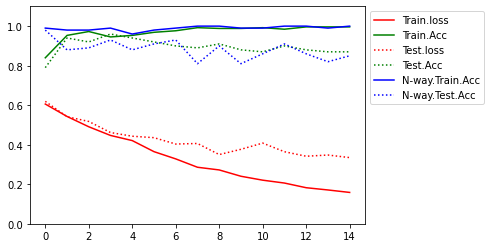

In [98]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='before_after_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.63 | train acc:0.89 |
                   | test loss: 0.63 | test acc: 0.85 |
                   | N-Way train acc:0.96 | N-Way test acc:0.96
          | best N-Way train acc: current=0.96 | previous=0)
          | best test acc: current=0.85 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.55 | train acc:0.95 |
                   | test loss: 0.56 | test acc: 0.92 |
                   | N-Way train acc:0.97 | N-Way test acc:0.91
          | best test acc: current=0.92 | previous=0.85)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.49 | train acc:0.96 |
                   | test loss: 0.5

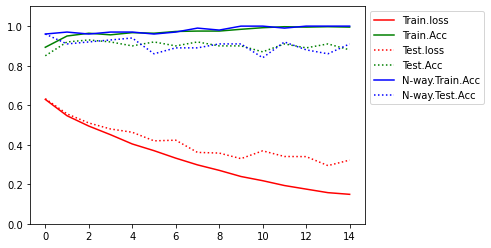

In [99]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='before_after_l2')

### embed_option: 'facenet2'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.66 | train acc:0.84 |
                   | test loss: 0.66 | test acc: 0.83 |
                   | N-Way train acc:0.95 | N-Way test acc:0.97
          | best N-Way train acc: current=0.97 | previous=0)
          | best test acc: current=0.83 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.57 | train acc:0.95 |
                   | test loss: 0.58 | test acc: 0.94 |
                   | N-Way train acc:0.96 | N-Way test acc:0.96
          | best test acc: current=0.94 | previous=0.83)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.53 | train acc:0.95 |
                  

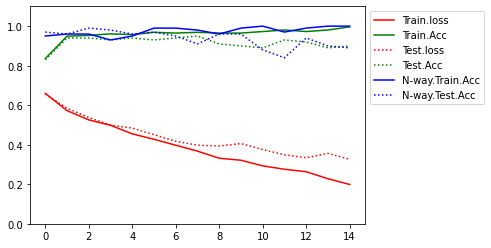

In [100]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet2', learn='before_after_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.64 | train acc:0.9 |
                   | test loss: 0.64 | test acc: 0.89 |
                   | N-Way train acc:0.97 | N-Way test acc:0.9
          | best N-Way train acc: current=0.9 | previous=0)
          | best test acc: current=0.89 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.56 | train acc:0.94 |
                   | test loss: 0.55 | test acc: 0.96 |
                   | N-Way train acc:0.95 | N-Way test acc:0.96
          | best N-Way train acc: current=0.96 | previous=0.9)
          | best test acc: current=0.96 | previous=0.89)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss

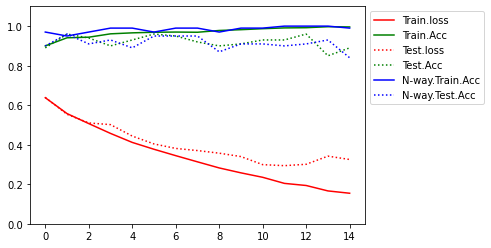

In [101]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet2', learn='before_after_l2')

## Learn After L2
    - without normalization

### embed_option: 'face_recognition'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.69 | train acc:0.8 |
                   | test loss: 0.69 | test acc: 0.82 |
                   | N-Way train acc:0.93 | N-Way test acc:0.92
          | best N-Way train acc: current=0.92 | previous=0)
          | best test acc: current=0.82 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.68 | train acc:0.74 |
                   | test loss: 0.68 | test acc: 0.71 |
                   | N-Way train acc:0.97 | N-Way test acc:0.96
          | best N-Way train acc: current=0.96 | previous=0.92)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.67 | train acc:0.74 |
            

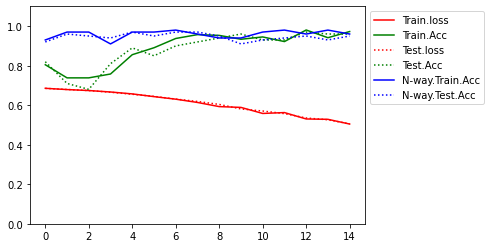

In [102]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='face_recognition', learn='after_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.69 | train acc:0.82 |
                   | test loss: 0.69 | test acc: 0.77 |
                   | N-Way train acc:0.99 | N-Way test acc:0.95
          | best N-Way train acc: current=0.95 | previous=0)
          | best test acc: current=0.77 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.69 | train acc:0.84 |
                   | test loss: 0.69 | test acc: 0.76 |
                   | N-Way train acc:0.94 | N-Way test acc:0.94
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.69 | train acc:0.73 |
                   | test loss: 0.69 | test acc: 0.73 |
                   | N-Way train acc

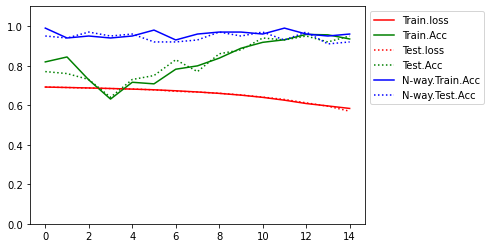

In [103]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='face_recognition', learn='after_l2')

### embed_option: 'facenet1'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.59 | train acc:0.81 |
                   | test loss: 0.59 | test acc: 0.78 |
                   | N-Way train acc:0.98 | N-Way test acc:0.99
          | best N-Way train acc: current=0.99 | previous=0)
          | best test acc: current=0.78 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.53 | train acc:0.93 |
                   | test loss: 0.53 | test acc: 0.96 |
                   | N-Way train acc:0.96 | N-Way test acc:0.95
          | best test acc: current=0.96 | previous=0.78)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.48 | train acc:0.94 |
                  

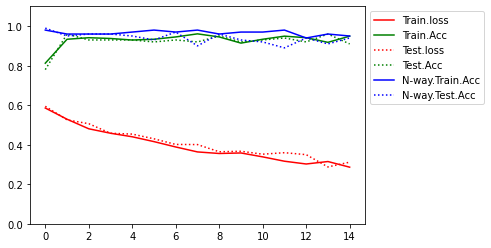

In [104]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='after_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.59 | train acc:0.82 |
                   | test loss: 0.59 | test acc: 0.82 |
                   | N-Way train acc:0.97 | N-Way test acc:0.94
          | best N-Way train acc: current=0.94 | previous=0)
          | best test acc: current=0.82 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.52 | train acc:0.92 |
                   | test loss: 0.54 | test acc: 0.94 |
                   | N-Way train acc:0.91 | N-Way test acc:0.98
          | best N-Way train acc: current=0.98 | previous=0.94)
          | best test acc: current=0.94 | previous=0.82)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train 

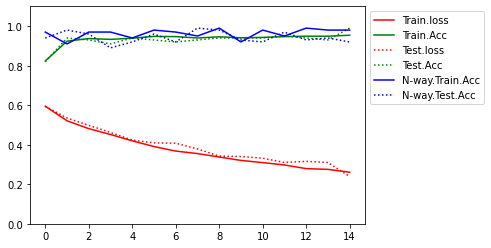

In [105]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet1', learn='after_l2')

### embed_option: 'facenet2'

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 (eq.iters: 1800) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.64 | train acc:0.73 |
                   | test loss: 0.64 | test acc: 0.73 |
                   | N-Way train acc:0.96 | N-Way test acc:0.91
          | best N-Way train acc: current=0.91 | previous=0)
          | best test acc: current=0.73 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.55 | train acc:0.9 |
                   | test loss: 0.55 | test acc: 0.92 |
                   | N-Way train acc:0.98 | N-Way test acc:0.97
          | best N-Way train acc: current=0.97 | previous=0.91)
          | best test acc: current=0.92 | previous=0.73)
----------------------------------------------------------------------------------------
[0.3mins] epo

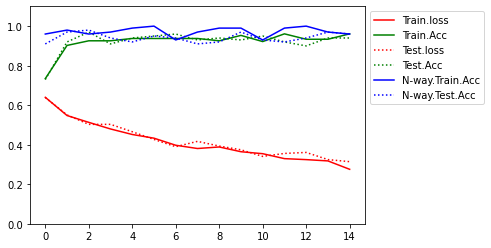

In [106]:
siamese_train(epochs=600, batch_size=256, train_type='batch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet2', learn='after_l2')

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 600 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.6 | train acc:0.83 |
                   | test loss: 0.6 | test acc: 0.81 |
                   | N-Way train acc:0.95 | N-Way test acc:0.96
          | best N-Way train acc: current=0.96 | previous=0)
          | best test acc: current=0.81 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.52 | train acc:0.93 |
                   | test loss: 0.54 | test acc: 0.91 |
                   | N-Way train acc:0.97 | N-Way test acc:0.99
          | best N-Way train acc: current=0.99 | previous=0.96)
          | best test acc: current=0.91 | previous=0.81)
----------------------------------------------------------------------------------------
[0.4mins] epoch: 120 | train lo

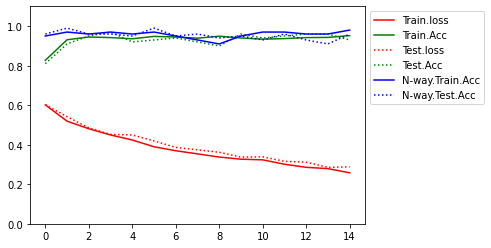

In [107]:
siamese_train(epochs=600, batch_size=256, train_type='epoch', eval_freq=40, n_way=10, n_test=100, 
              embed=True, normalize=False, do_shuffle=True, 
              embed_option='facenet2', learn='after_l2')

## Load Model Weights

In [120]:
def test_trained_models(model=None, model_type="image"):

    weights_path = "output/siamese_model/embeds_after_l2"
    model_weights = [name for name in os.listdir(weights_path) if model_type in name and name[-3:] == '.h5']
    
    for i, model_weight in enumerate(model_weights, start=1):
        print("test {} - model: {}".format(i, model_weight))
        model.load_weights(os.path.join(weights_path, model_weight))
        
        if 'nor' in model_weight:
            normalize = True
        else:
            normalize = False
        
        if 'embed' in model_weight:
            embed = True
        else:
            embed = False
            
        if 'face_recognition' in model_weight:
            embed_option = 'face_recognition'
        elif 'facenet1' in model_weight:
            embed_option = 'facenet1'
        elif 'facenet2' in model_weight:
            embed_option = 'facenet2'
        
        n_persons = (X_images_test.shape[0]//2)+1
        N_ways = np.arange(0, n_persons, 5)
        N_ways[0] = 1
        trials = 10

        test_accs, train_accs, = [], []
        for N_way in N_ways:    
            train_accs.append(100*test_oneshot(model, N_way, trials, True, embed, normalize, verbose=False,
                                               embed_option=embed_option))
            test_accs.append(100*test_oneshot(model, N_way, trials, False, embed, normalize, verbose=False,
                                               embed_option=embed_option))
        
        fig,ax = plt.subplots(1, figsize=(10,5))
        ax.plot(N_ways, test_accs, "m", label="Test.Acc")
        ax.plot(N_ways, train_accs, "y", label="Train.Acc")
        ax.plot(N_ways, 100.0/N_ways, "g", label="Random guessing")
        plt.xlabel("Number of possible classes in one-shot task")
        plt.ylabel("% Accuracy")
        plt.title("One-Shot Learning ({})".format(model_weight))
        ax.legend(loc='upper right')
        plt.show()

test 1 - model: face_recognition_epoch_embeds_bs256_ep600_final.h5
[[0.62264746]] 0 0
[[0.6141706]] 0 0
[[0.642676]] 0 0
[[0.5947295]] 0 0
[[0.6347615]] 0 0
[[0.5429779]] 0 0
[[0.5201928]] 0 0
[[0.5907507]] 0 0
[[0.5485714]] 0 0
[[0.67050254]] 0 0
[[0.5648851]] 0 0
[[0.6175763]] 0 0
[[0.6291949]] 0 0
[[0.623396]] 0 0
[[0.6240966]] 0 0
[[0.6175763]] 0 0
[[0.55487645]] 0 0
[[0.5961333]] 0 0
[[0.5781392]] 0 0
[[0.57001245]] 0 0
[[0.44465992]
 [0.46135044]
 [0.4310054 ]
 [0.6431652 ]
 [0.42828655]] 3 3
[[0.43006012]
 [0.45770186]
 [0.6581445 ]
 [0.42634347]
 [0.47518763]] 2 2
[[0.48934862]
 [0.40993547]
 [0.49216813]
 [0.4055378 ]
 [0.56205463]] 4 4
[[0.549904  ]
 [0.45129818]
 [0.39532   ]
 [0.36930844]
 [0.49063534]] 0 0
[[0.43553093]
 [0.4214335 ]
 [0.3731264 ]
 [0.6790326 ]
 [0.3819441 ]] 3 3
[[0.46043655]
 [0.43029377]
 [0.40780336]
 [0.4088115 ]
 [0.54429173]] 4 4
[[0.6274179 ]
 [0.4901017 ]
 [0.413686  ]
 [0.36341134]
 [0.36430836]] 0 0
[[0.42005897]
 [0.48138714]
 [0.6147734 ]
 [0.

[[0.40292177]
 [0.47545514]
 [0.3837922 ]
 [0.41966835]
 [0.36932704]
 [0.35799783]
 [0.44204843]
 [0.4124642 ]
 [0.44968152]
 [0.33039623]
 [0.3838317 ]
 [0.4227037 ]
 [0.4033831 ]
 [0.46415094]
 [0.41549823]
 [0.42316565]
 [0.42220888]
 [0.40678594]
 [0.3538544 ]
 [0.4664856 ]] 1 19
[[0.41100806]
 [0.3799654 ]
 [0.35056567]
 [0.3657673 ]
 [0.37840718]
 [0.40146953]
 [0.38153097]
 [0.41647053]
 [0.51247317]
 [0.40601844]
 [0.47246468]
 [0.4038285 ]
 [0.48488387]
 [0.3819117 ]
 [0.388306  ]
 [0.39977798]
 [0.34768856]
 [0.40351054]
 [0.63686913]
 [0.39730445]] 18 18
[[0.40318635]
 [0.45583826]
 [0.3905685 ]
 [0.45263   ]
 [0.40005708]
 [0.41787118]
 [0.34690505]
 [0.40904862]
 [0.4161547 ]
 [0.3984728 ]
 [0.47485682]
 [0.3868266 ]
 [0.6156035 ]
 [0.38437754]
 [0.39398426]
 [0.4416812 ]
 [0.42088017]
 [0.41544232]
 [0.40337977]
 [0.48745033]] 12 12
[[0.39938685]
 [0.5296466 ]
 [0.436934  ]
 [0.41297284]
 [0.43165216]
 [0.39225474]
 [0.37615052]
 [0.38317275]
 [0.38720047]
 [0.41176745]


[[0.40167785]
 [0.4383958 ]
 [0.40761447]
 [0.40910393]
 [0.40920126]
 [0.40934741]
 [0.6240965 ]
 [0.40622252]
 [0.41369793]
 [0.43203363]
 [0.37636346]
 [0.39891198]
 [0.43260255]
 [0.4217661 ]
 [0.39570177]
 [0.42023212]
 [0.42829362]
 [0.44341564]
 [0.47050443]
 [0.42562532]
 [0.41220027]
 [0.40655026]
 [0.431932  ]
 [0.39311436]
 [0.38067695]] 6 6
[[0.444619  ]
 [0.49198365]
 [0.4288031 ]
 [0.39045063]
 [0.50484   ]
 [0.43173277]
 [0.48041582]
 [0.44593066]
 [0.4415807 ]
 [0.46878678]
 [0.46199074]
 [0.5141141 ]
 [0.45787746]
 [0.48998418]
 [0.4083684 ]
 [0.46927792]
 [0.41985032]
 [0.44938055]
 [0.44293255]
 [0.47156218]
 [0.45445514]
 [0.3746056 ]
 [0.47514868]
 [0.46703163]
 [0.45330018]] 11 11
[[0.35516697]
 [0.51893544]
 [0.41138273]
 [0.38682908]
 [0.40337878]
 [0.43758717]
 [0.39108086]
 [0.39838845]
 [0.3963436 ]
 [0.3669134 ]
 [0.43001568]
 [0.4060142 ]
 [0.44007313]
 [0.37853274]
 [0.37023443]
 [0.4074251 ]
 [0.46930426]
 [0.48906666]
 [0.4252166 ]
 [0.44134456]
 [0.6507

[[0.431611  ]
 [0.4537685 ]
 [0.44830406]
 [0.38299757]
 [0.43322366]
 [0.44071287]
 [0.41532174]
 [0.4221524 ]
 [0.44059336]
 [0.36996192]
 [0.3926046 ]
 [0.51971596]
 [0.43499267]
 [0.46002477]
 [0.41287187]
 [0.47141647]
 [0.4585885 ]
 [0.4253892 ]
 [0.44172713]
 [0.43363878]
 [0.45941412]
 [0.37748873]
 [0.3944708 ]
 [0.46161157]
 [0.38421834]
 [0.44061452]
 [0.42191428]
 [0.42206654]
 [0.44608447]
 [0.43430912]] 11 11
[[0.44689322]
 [0.45340386]
 [0.40477926]
 [0.4525877 ]
 [0.40347686]
 [0.39643145]
 [0.49840185]
 [0.4305424 ]
 [0.4236818 ]
 [0.39383414]
 [0.4236663 ]
 [0.4416471 ]
 [0.47347435]
 [0.42112404]
 [0.48708448]
 [0.40381163]
 [0.4845652 ]
 [0.39199585]
 [0.4577127 ]
 [0.4255197 ]
 [0.40957692]
 [0.4284651 ]
 [0.44218102]
 [0.42049944]
 [0.4537373 ]
 [0.42740035]
 [0.43824363]
 [0.44167268]
 [0.37708312]
 [0.48748973]] 6 6
[[0.4350134 ]
 [0.3939172 ]
 [0.40363443]
 [0.4594698 ]
 [0.4280632 ]
 [0.3987292 ]
 [0.44156045]
 [0.4369288 ]
 [0.4400429 ]
 [0.45006266]
 [0.3992

[[0.41661417]
 [0.5886862 ]
 [0.44106138]
 [0.3815245 ]
 [0.42990747]
 [0.4531195 ]
 [0.46145514]
 [0.45153782]
 [0.41715148]
 [0.43653098]
 [0.36622077]
 [0.41135144]
 [0.44922507]
 [0.4117295 ]
 [0.41856936]
 [0.4695809 ]
 [0.41986772]
 [0.37921482]
 [0.37167928]
 [0.46603996]
 [0.41338772]
 [0.37389746]
 [0.46841672]
 [0.35197002]
 [0.39010882]
 [0.44468462]
 [0.3839598 ]
 [0.4140014 ]
 [0.39386606]
 [0.47051838]
 [0.42813945]
 [0.444178  ]
 [0.41622832]
 [0.39926523]
 [0.41677147]] 1 1
[[0.48358425]
 [0.43297008]
 [0.4372129 ]
 [0.4586538 ]
 [0.4121524 ]
 [0.44030884]
 [0.5111623 ]
 [0.47689462]
 [0.45535752]
 [0.41375217]
 [0.60555345]
 [0.4604297 ]
 [0.4180665 ]
 [0.4757078 ]
 [0.41877106]
 [0.4515123 ]
 [0.4270779 ]
 [0.457174  ]
 [0.41989207]
 [0.4162397 ]
 [0.43979028]
 [0.4513089 ]
 [0.4308387 ]
 [0.44760403]
 [0.47077632]
 [0.3908348 ]
 [0.48957774]
 [0.37903777]
 [0.45053518]
 [0.45902067]
 [0.47162297]
 [0.38934374]
 [0.46181887]
 [0.4910865 ]
 [0.43700773]] 10 10
[[0.3791

[[0.46328405]
 [0.46191415]
 [0.39926434]
 [0.42897493]
 [0.4187659 ]
 [0.42945927]
 [0.42217797]
 [0.37488878]
 [0.38876906]
 [0.4290903 ]
 [0.39431995]
 [0.4342855 ]
 [0.3830087 ]
 [0.43317828]
 [0.45240554]
 [0.42350483]
 [0.4216161 ]
 [0.4567794 ]
 [0.3963604 ]
 [0.44275722]
 [0.4676168 ]
 [0.43459386]
 [0.6581536 ]
 [0.3789534 ]
 [0.4110685 ]
 [0.46698767]
 [0.4651754 ]
 [0.42981791]
 [0.4399349 ]
 [0.46307144]
 [0.39982843]
 [0.4565618 ]
 [0.40790138]
 [0.47212318]
 [0.43084812]
 [0.48723653]
 [0.4031959 ]
 [0.37890166]
 [0.49144623]
 [0.4315824 ]] 22 22
[[0.41935703]
 [0.40608728]
 [0.41977087]
 [0.5865989 ]
 [0.4537448 ]
 [0.42496005]
 [0.46184742]
 [0.41734672]
 [0.45772976]
 [0.405251  ]
 [0.48149225]
 [0.4187054 ]
 [0.39828962]
 [0.42267114]
 [0.38074183]
 [0.4656195 ]
 [0.45343998]
 [0.42381197]
 [0.45468545]
 [0.384075  ]
 [0.42172867]
 [0.4120223 ]
 [0.4075554 ]
 [0.4121524 ]
 [0.3973526 ]
 [0.48139983]
 [0.4672623 ]
 [0.3799016 ]
 [0.4099723 ]
 [0.4586826 ]
 [0.38934338]

[[0.44426626]
 [0.38758522]
 [0.41981474]
 [0.37243283]
 [0.45681238]
 [0.48646548]
 [0.43066648]
 [0.42285395]
 [0.7010329 ]
 [0.52114743]
 [0.43156326]
 [0.3946545 ]
 [0.4579068 ]
 [0.50207627]
 [0.46428636]
 [0.48529518]
 [0.42231715]
 [0.44007698]
 [0.3666349 ]
 [0.4037989 ]
 [0.46630067]
 [0.43724072]
 [0.4952728 ]
 [0.48865348]
 [0.3859939 ]
 [0.40251336]
 [0.3869191 ]
 [0.4213587 ]
 [0.45313153]
 [0.4296794 ]
 [0.39621824]
 [0.47994077]
 [0.38333797]
 [0.40183496]
 [0.483254  ]
 [0.49272022]
 [0.40590525]
 [0.38846374]
 [0.40401632]
 [0.40244204]
 [0.45744675]
 [0.38717887]
 [0.43122816]
 [0.4052048 ]
 [0.47972974]] 8 8
[[0.4344078 ]
 [0.41851494]
 [0.45892167]
 [0.48923412]
 [0.50740504]
 [0.45959094]
 [0.43316305]
 [0.41883752]
 [0.42259806]
 [0.44341734]
 [0.44764975]
 [0.44910538]
 [0.51081103]
 [0.42481053]
 [0.44693142]
 [0.5230838 ]
 [0.43283045]
 [0.44146207]
 [0.44009772]
 [0.48382285]
 [0.39957908]
 [0.418949  ]
 [0.4434057 ]
 [0.52710474]
 [0.4735537 ]
 [0.46765813]
 

[[0.6323017 ]
 [0.4156701 ]
 [0.3894822 ]
 [0.4073464 ]
 [0.4229405 ]
 [0.35640627]
 [0.3794928 ]
 [0.44932926]
 [0.42832926]
 [0.40034497]
 [0.42399448]
 [0.39456135]
 [0.3926459 ]
 [0.50645936]
 [0.3573126 ]
 [0.4038532 ]
 [0.4477238 ]
 [0.46532202]
 [0.41174257]
 [0.46768975]
 [0.42661566]
 [0.43130276]
 [0.39522094]
 [0.40565646]
 [0.40177578]
 [0.48112902]
 [0.42872757]
 [0.37517035]
 [0.40188017]
 [0.41233253]
 [0.40494886]
 [0.38461664]
 [0.38899556]
 [0.4024005 ]
 [0.38968855]
 [0.38399518]
 [0.4495979 ]
 [0.36939067]
 [0.44910693]
 [0.39683023]
 [0.47989586]
 [0.39630622]
 [0.37424228]
 [0.39774576]
 [0.3313064 ]
 [0.38921678]
 [0.3598988 ]
 [0.40033036]
 [0.38280317]
 [0.4334018 ]] 0 0
[[0.46413413]
 [0.41531932]
 [0.42934266]
 [0.42592883]
 [0.42756146]
 [0.36765552]
 [0.4496576 ]
 [0.4287143 ]
 [0.4002774 ]
 [0.4688484 ]
 [0.41356555]
 [0.41075307]
 [0.39001435]
 [0.42561033]
 [0.47417384]
 [0.39092344]
 [0.41650122]
 [0.44772905]
 [0.47126612]
 [0.44761434]
 [0.51855147]
 

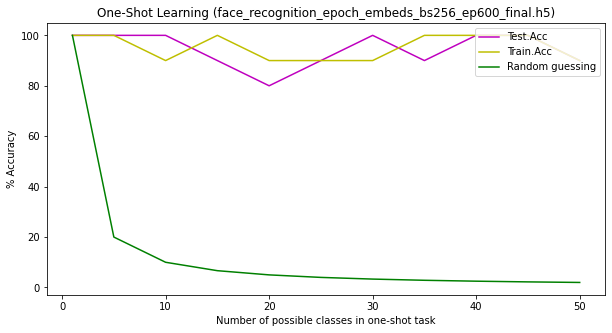

test 2 - model: facenet1_epoch_embeds_bs256_ep600_test_best.h5
[[0.9356917]] 0 0
[[0.6215359]] 0 0
[[0.7188095]] 0 0
[[0.8554563]] 0 0
[[0.7703936]] 0 0
[[0.93091077]] 0 0
[[0.7717721]] 0 0
[[0.95564336]] 0 0
[[0.9549702]] 0 0
[[0.9129783]] 0 0
[[0.3693054]] 0 0
[[0.94600475]] 0 0
[[0.92534196]] 0 0
[[0.94886845]] 0 0
[[0.92916536]] 0 0
[[0.5808252]] 0 0
[[0.93352085]] 0 0
[[0.826357]] 0 0
[[0.7141206]] 0 0
[[0.8223965]] 0 0
[[0.21537744]
 [0.19820966]
 [0.2193522 ]
 [0.21155836]
 [0.61855906]] 4 4
[[0.12378758]
 [0.3401775 ]
 [0.6654332 ]
 [0.28259426]
 [0.2996027 ]] 2 2
[[0.18708521]
 [0.18882842]
 [0.16394071]
 [0.9466993 ]
 [0.1713784 ]] 3 3
[[0.19910957]
 [0.25371802]
 [0.9475792 ]
 [0.244404  ]
 [0.16189434]] 2 2
[[0.9413234 ]
 [0.16206968]
 [0.29254207]
 [0.17310087]
 [0.30474874]] 0 0
[[0.2645927 ]
 [0.33961052]
 [0.18721472]
 [0.9448346 ]
 [0.29340938]] 3 3
[[0.2087048 ]
 [0.15451188]
 [0.8672983 ]
 [0.17848574]
 [0.3181617 ]] 2 2
[[0.1726932 ]
 [0.1666224 ]
 [0.95132285]
 [0.

[[0.16873929]
 [0.1312539 ]
 [0.16323337]
 [0.17815754]
 [0.16737413]
 [0.19839665]
 [0.17674291]
 [0.12258157]
 [0.14939229]
 [0.15306848]
 [0.92916536]
 [0.3382501 ]
 [0.16942608]
 [0.18034044]
 [0.1670101 ]] 10 10
[[0.22109452]
 [0.45741147]
 [0.23436302]
 [0.18053374]
 [0.14816031]
 [0.30283648]
 [0.300964  ]
 [0.193611  ]
 [0.21743497]
 [0.26692843]
 [0.6796474 ]
 [0.16829526]
 [0.27269396]
 [0.28785375]
 [0.24493447]] 10 10
[[0.21428815]
 [0.13620183]
 [0.6410433 ]
 [0.11278608]
 [0.13974091]
 [0.20710996]
 [0.16668957]
 [0.13655412]
 [0.243917  ]
 [0.14994791]
 [0.12854664]
 [0.17779438]
 [0.15828991]
 [0.12442686]
 [0.15377201]] 2 2
[[0.31888562]
 [0.17984444]
 [0.15673864]
 [0.17595714]
 [0.16386622]
 [0.1646379 ]
 [0.18275562]
 [0.23223782]
 [0.95266485]
 [0.29707396]
 [0.19944286]
 [0.2583924 ]
 [0.19334602]
 [0.15102094]
 [0.20015442]
 [0.18721592]
 [0.17392655]
 [0.27776477]
 [0.16551228]
 [0.23024057]] 8 8
[[0.22855869]
 [0.17324519]
 [0.36334145]
 [0.15076125]
 [0.156408

[[0.28165925]
 [0.3294102 ]
 [0.33472067]
 [0.19466668]
 [0.16667676]
 [0.26811075]
 [0.25094143]
 [0.2447679 ]
 [0.1610907 ]
 [0.21383524]
 [0.1995025 ]
 [0.20534861]
 [0.18140966]
 [0.21354637]
 [0.22648424]
 [0.28734255]
 [0.19138244]
 [0.18804872]
 [0.14460948]
 [0.1822741 ]
 [0.14642826]
 [0.2623207 ]
 [0.91704154]
 [0.20633075]
 [0.20729886]] 22 22
[[0.2550903 ]
 [0.21367118]
 [0.3025323 ]
 [0.25275066]
 [0.20764127]
 [0.16442695]
 [0.23304895]
 [0.15704346]
 [0.18869123]
 [0.6412916 ]
 [0.18279123]
 [0.22205079]
 [0.21174034]
 [0.19920632]
 [0.2483725 ]
 [0.18722197]
 [0.22022343]
 [0.15091544]
 [0.25959504]
 [0.12157127]
 [0.16779518]
 [0.15561435]
 [0.2202537 ]
 [0.1730279 ]
 [0.19623217]] 9 9
[[0.2254124 ]
 [0.5119133 ]
 [0.2673552 ]
 [0.33980602]
 [0.24662003]
 [0.26408482]
 [0.30035105]
 [0.23144823]
 [0.22827134]
 [0.31968907]
 [0.3035497 ]
 [0.27237606]
 [0.27345178]
 [0.3169346 ]
 [0.31684345]
 [0.34886023]
 [0.60193264]
 [0.27638876]
 [0.58609295]
 [0.30246252]
 [0.6352

[[0.2604305 ]
 [0.31844568]
 [0.19236243]
 [0.18490022]
 [0.26632345]
 [0.21013746]
 [0.20379502]
 [0.22753316]
 [0.21630207]
 [0.12630683]
 [0.18917823]
 [0.15194687]
 [0.24137312]
 [0.29237574]
 [0.25746495]
 [0.21890053]
 [0.27973676]
 [0.9514102 ]
 [0.196823  ]
 [0.22978956]
 [0.2401861 ]
 [0.23102045]
 [0.19240493]
 [0.16054252]
 [0.1891994 ]
 [0.12448006]
 [0.34918278]
 [0.28303114]
 [0.24146505]
 [0.13515824]] 17 17
[[0.22738147]
 [0.48737407]
 [0.165683  ]
 [0.26366842]
 [0.236821  ]
 [0.6357834 ]
 [0.34059054]
 [0.5402174 ]
 [0.23810184]
 [0.18903312]
 [0.3398689 ]
 [0.26040906]
 [0.21351025]
 [0.20709771]
 [0.19091368]
 [0.25133646]
 [0.30277085]
 [0.25554004]
 [0.294509  ]
 [0.16477421]
 [0.19522017]
 [0.15326467]
 [0.36538744]
 [0.2390168 ]
 [0.16030383]
 [0.2234444 ]
 [0.39286673]
 [0.20140134]
 [0.28391784]
 [0.22098969]] 5 5
[[0.15131912]
 [0.13883328]
 [0.2688169 ]
 [0.14345974]
 [0.17208669]
 [0.27844036]
 [0.2470043 ]
 [0.23164448]
 [0.15255284]
 [0.12961742]
 [0.1287

[[0.151804  ]
 [0.2526737 ]
 [0.9262112 ]
 [0.14901295]
 [0.3051266 ]
 [0.26456645]
 [0.14972046]
 [0.2872713 ]
 [0.25152236]
 [0.23285323]
 [0.22898418]
 [0.26044393]
 [0.35098538]
 [0.34998137]
 [0.34883794]
 [0.20959061]
 [0.18815896]
 [0.15825161]
 [0.3528068 ]
 [0.16926575]
 [0.29471448]
 [0.1513665 ]
 [0.21935242]
 [0.24029735]
 [0.18621936]
 [0.28675282]
 [0.2707355 ]
 [0.21210817]
 [0.22352904]
 [0.14382899]
 [0.2558318 ]
 [0.2247648 ]
 [0.23481569]
 [0.2547569 ]
 [0.28070253]] 2 2
[[0.22089455]
 [0.236821  ]
 [0.36534262]
 [0.1764364 ]
 [0.1430091 ]
 [0.34733856]
 [0.61867684]
 [0.28783804]
 [0.3196152 ]
 [0.22782528]
 [0.30285886]
 [0.39157814]
 [0.18768495]
 [0.14870724]
 [0.24936458]
 [0.2771687 ]
 [0.25852674]
 [0.18306464]
 [0.3194801 ]
 [0.25419587]
 [0.32446876]
 [0.2685554 ]
 [0.15848845]
 [0.14204168]
 [0.29522526]
 [0.15031552]
 [0.22369409]
 [0.20118877]
 [0.19268218]
 [0.22227779]
 [0.21246627]
 [0.21966916]
 [0.2987792 ]
 [0.33176726]
 [0.16459168]] 6 6
[[0.262133

[[0.18805978]
 [0.20066085]
 [0.28783804]
 [0.20530212]
 [0.17262411]
 [0.16125461]
 [0.2208798 ]
 [0.18715   ]
 [0.16144854]
 [0.17170975]
 [0.22186407]
 [0.2155064 ]
 [0.3452626 ]
 [0.22537273]
 [0.25313437]
 [0.18224892]
 [0.26630116]
 [0.21768391]
 [0.13977882]
 [0.23051456]
 [0.94800127]
 [0.3138218 ]
 [0.16128805]
 [0.2526737 ]
 [0.22281742]
 [0.23600942]
 [0.22311074]
 [0.19423312]
 [0.24672914]
 [0.15724277]
 [0.16475907]
 [0.19937545]
 [0.22610047]
 [0.15413254]
 [0.15281823]
 [0.14585787]
 [0.16501448]
 [0.20131987]
 [0.28801167]
 [0.15695581]] 20 20
[[0.16686931]
 [0.24257824]
 [0.13017386]
 [0.14827174]
 [0.18149108]
 [0.17493173]
 [0.12276268]
 [0.15249833]
 [0.17583534]
 [0.17007685]
 [0.21239504]
 [0.18753064]
 [0.23793367]
 [0.3585265 ]
 [0.20515731]
 [0.72922534]
 [0.15324348]
 [0.12789527]
 [0.23435593]
 [0.15687847]
 [0.170652  ]
 [0.19266263]
 [0.27281874]
 [0.14937684]
 [0.18462041]
 [0.16789678]
 [0.16848007]
 [0.13824183]
 [0.2766289 ]
 [0.12281871]
 [0.2648111 ]

[[0.27548558]
 [0.23899221]
 [0.28256136]
 [0.15305361]
 [0.18214989]
 [0.30654618]
 [0.1950944 ]
 [0.1880854 ]
 [0.14244217]
 [0.9311153 ]
 [0.19310582]
 [0.2379314 ]
 [0.20143133]
 [0.18380028]
 [0.24503627]
 [0.2441895 ]
 [0.20716378]
 [0.23855072]
 [0.33585364]
 [0.19717917]
 [0.23074731]
 [0.19409883]
 [0.21932778]
 [0.2660922 ]
 [0.31702685]
 [0.43239504]
 [0.15105549]
 [0.32556587]
 [0.2814303 ]
 [0.18416393]
 [0.3823862 ]
 [0.16567785]
 [0.15982679]
 [0.22236493]
 [0.38476062]
 [0.21330869]
 [0.39392614]
 [0.22392774]
 [0.20458058]
 [0.20851085]
 [0.13667665]
 [0.19390826]
 [0.2487626 ]
 [0.18745784]
 [0.20908915]] 9 9
[[0.16122478]
 [0.15958712]
 [0.12297478]
 [0.26599377]
 [0.12191865]
 [0.1449889 ]
 [0.15815341]
 [0.12207314]
 [0.14220724]
 [0.1150648 ]
 [0.10798278]
 [0.18124464]
 [0.14597991]
 [0.21797007]
 [0.14247984]
 [0.13367066]
 [0.1638425 ]
 [0.14510721]
 [0.12679172]
 [0.12089008]
 [0.12175849]
 [0.11171165]
 [0.12594408]
 [0.24501333]
 [0.15407747]
 [0.17132455]
 

[[0.22087699]
 [0.22759753]
 [0.2980265 ]
 [0.33461362]
 [0.27297652]
 [0.2253282 ]
 [0.389621  ]
 [0.18487436]
 [0.37058994]
 [0.22444046]
 [0.22228241]
 [0.3225575 ]
 [0.23018792]
 [0.19765505]
 [0.17312095]
 [0.1806002 ]
 [0.3969016 ]
 [0.33646363]
 [0.19274947]
 [0.1831739 ]
 [0.19537291]
 [0.33077213]
 [0.37553236]
 [0.22545558]
 [0.2477336 ]
 [0.22330901]
 [0.21120897]
 [0.18683195]
 [0.26342082]
 [0.26120085]
 [0.19583306]
 [0.18428704]
 [0.35689092]
 [0.24275666]
 [0.20313817]
 [0.22879934]
 [0.25203395]
 [0.33556002]
 [0.35309643]
 [0.5743778 ]
 [0.32562602]
 [0.9351069 ]
 [0.19209549]
 [0.21957111]
 [0.26180542]
 [0.294519  ]
 [0.16762227]
 [0.3506605 ]
 [0.1975969 ]
 [0.21437858]] 41 41
[[0.17919204]
 [0.18765658]
 [0.3059929 ]
 [0.27698505]
 [0.16593659]
 [0.24790236]
 [0.26758263]
 [0.15788364]
 [0.23336267]
 [0.15061927]
 [0.34226263]
 [0.37162772]
 [0.1886478 ]
 [0.3017872 ]
 [0.19288582]
 [0.39422294]
 [0.2878666 ]
 [0.22700465]
 [0.29653537]
 [0.19191492]
 [0.22416407]

[[0.18288046]
 [0.19570169]
 [0.18011394]
 [0.16013679]
 [0.9227245 ]
 [0.17436215]
 [0.16595235]
 [0.34711024]
 [0.30156225]
 [0.27973676]
 [0.20417449]
 [0.20513129]
 [0.2080012 ]
 [0.3218963 ]
 [0.29787573]
 [0.23891613]
 [0.1602825 ]
 [0.21273038]
 [0.33780771]
 [0.16695008]
 [0.13283506]
 [0.44048643]
 [0.15817136]
 [0.16486126]
 [0.14404073]
 [0.1379112 ]
 [0.23226291]
 [0.21418834]
 [0.15632501]
 [0.2118687 ]
 [0.21331355]
 [0.24936116]
 [0.17971665]
 [0.17088196]
 [0.16684031]
 [0.16095227]
 [0.18726763]
 [0.22766149]
 [0.14559615]
 [0.1520744 ]
 [0.18283752]
 [0.1592794 ]
 [0.18805957]
 [0.27770686]
 [0.18872851]
 [0.15451252]
 [0.19129986]
 [0.18587124]
 [0.19474803]
 [0.17234665]] 4 4
[[0.22633743]
 [0.35185617]
 [0.22616887]
 [0.33513784]
 [0.20143133]
 [0.27937585]
 [0.16866493]
 [0.4042825 ]
 [0.24642599]
 [0.3775409 ]
 [0.16358358]
 [0.22073564]
 [0.40479177]
 [0.2385664 ]
 [0.17160696]
 [0.23857129]
 [0.24148968]
 [0.17512584]
 [0.28692317]
 [0.18764389]
 [0.30530173]
 

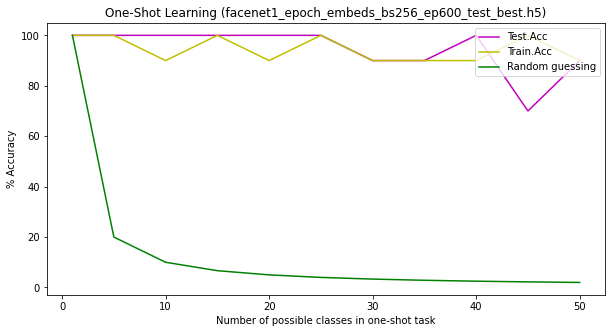

test 3 - model: face_recognition_epoch_embeds_bs256_ep600_test_best.h5
[[0.60136276]] 0 0
[[0.5229278]] 0 0
[[0.5444934]] 0 0
[[0.59866136]] 0 0
[[0.615728]] 0 0
[[0.516278]] 0 0
[[0.61420673]] 0 0
[[0.5839364]] 0 0
[[0.537522]] 0 0
[[0.5740742]] 0 0
[[0.50303555]] 0 0
[[0.60574365]] 0 0
[[0.5743176]] 0 0
[[0.609236]] 0 0
[[0.61391336]] 0 0
[[0.49544814]] 0 0
[[0.5891254]] 0 0
[[0.6245344]] 0 0
[[0.5062882]] 0 0
[[0.56228626]] 0 0
[[0.48131233]
 [0.4826624 ]
 [0.4258283 ]
 [0.6287715 ]
 [0.45566893]] 3 3
[[0.47234935]
 [0.47156036]
 [0.5583805 ]
 [0.42875502]
 [0.4587498 ]] 2 2
[[0.54083556]
 [0.508575  ]
 [0.45086783]
 [0.45076308]
 [0.47803745]] 0 0
[[0.41192067]
 [0.53308594]
 [0.46710387]
 [0.5273939 ]
 [0.49405876]] 1 1
[[0.56680524]
 [0.42599958]
 [0.5072096 ]
 [0.4658813 ]
 [0.49781606]] 0 0
[[0.5551929 ]
 [0.49755618]
 [0.4776579 ]
 [0.45751885]
 [0.46724686]] 0 0
[[0.44766125]
 [0.41866374]
 [0.6025975 ]
 [0.4551365 ]
 [0.45805457]] 2 2
[[0.4523582 ]
 [0.59768474]
 [0.45965207

[[0.48291573]
 [0.50305617]
 [0.46205702]
 [0.46383741]
 [0.44189245]
 [0.48676595]
 [0.49038875]
 [0.472     ]
 [0.4822648 ]
 [0.46781173]
 [0.4570255 ]
 [0.46848541]
 [0.47837457]
 [0.44953737]
 [0.5389776 ]] 14 14
[[0.44931182]
 [0.4959498 ]
 [0.4630204 ]
 [0.48954692]
 [0.43993294]
 [0.48774615]
 [0.6093522 ]
 [0.47681302]
 [0.43308803]
 [0.46878964]
 [0.45668343]
 [0.44110858]
 [0.4904285 ]
 [0.4697415 ]
 [0.4138046 ]] 6 6
[[0.4166901 ]
 [0.4767037 ]
 [0.47742823]
 [0.47167578]
 [0.46727535]
 [0.44567162]
 [0.4497497 ]
 [0.43650442]
 [0.43799877]
 [0.45883903]
 [0.47340772]
 [0.6037097 ]
 [0.499247  ]
 [0.4067046 ]
 [0.4311814 ]
 [0.48999503]
 [0.44407225]
 [0.43582192]
 [0.43751827]
 [0.41456416]] 11 11
[[0.4277437 ]
 [0.43397072]
 [0.45847014]
 [0.44380397]
 [0.43982172]
 [0.42984694]
 [0.42676443]
 [0.42853576]
 [0.4267694 ]
 [0.47058985]
 [0.44999602]
 [0.43589926]
 [0.447528  ]
 [0.43839255]
 [0.4206211 ]
 [0.43627402]
 [0.44405267]
 [0.45763475]
 [0.569151  ]
 [0.4520484 ]] 

[[0.46336943]
 [0.41578335]
 [0.4314705 ]
 [0.41390768]
 [0.41140628]
 [0.38811415]
 [0.43298456]
 [0.408732  ]
 [0.41763538]
 [0.42652267]
 [0.4472151 ]
 [0.43156517]
 [0.39886943]
 [0.41586924]
 [0.4412038 ]
 [0.4285321 ]
 [0.5652037 ]
 [0.4352441 ]
 [0.39909565]
 [0.45770752]
 [0.44158426]
 [0.38514787]
 [0.4227935 ]
 [0.44030103]
 [0.44904086]] 16 16
[[0.48844582]
 [0.459374  ]
 [0.4711609 ]
 [0.4817995 ]
 [0.45061326]
 [0.49776128]
 [0.47352597]
 [0.4855853 ]
 [0.45625657]
 [0.5023081 ]
 [0.43852025]
 [0.46031395]
 [0.49036467]
 [0.44512686]
 [0.5000665 ]
 [0.44192696]
 [0.444932  ]
 [0.49525073]
 [0.507692  ]
 [0.45577002]
 [0.5062371 ]
 [0.42024612]
 [0.47527885]
 [0.57280946]
 [0.45091346]] 23 23
[[0.4341062 ]
 [0.42029858]
 [0.41790727]
 [0.47660783]
 [0.44517642]
 [0.4840005 ]
 [0.4356956 ]
 [0.42296612]
 [0.5000064 ]
 [0.41377753]
 [0.45641685]
 [0.45254844]
 [0.4299354 ]
 [0.48856354]
 [0.4309272 ]
 [0.39227003]
 [0.47759032]
 [0.59575325]
 [0.43855634]
 [0.44744894]
 [0.44

[[0.46752688]
 [0.42880574]
 [0.43736348]
 [0.44330254]
 [0.4509044 ]
 [0.42950293]
 [0.4489586 ]
 [0.46641743]
 [0.44079545]
 [0.46772805]
 [0.5006928 ]
 [0.4809181 ]
 [0.502708  ]
 [0.4296171 ]
 [0.44912297]
 [0.4696544 ]
 [0.4958473 ]
 [0.47441894]
 [0.47165647]
 [0.48932007]
 [0.50223213]
 [0.47364756]
 [0.46027365]
 [0.47170475]
 [0.39809942]
 [0.5150814 ]
 [0.44058686]
 [0.60399824]
 [0.4385694 ]
 [0.42085657]] 27 27
[[0.45363718]
 [0.45716956]
 [0.50628006]
 [0.44958693]
 [0.48294294]
 [0.48072785]
 [0.46597075]
 [0.5056194 ]
 [0.45502135]
 [0.4473734 ]
 [0.46547267]
 [0.4404408 ]
 [0.47710043]
 [0.5181841 ]
 [0.47866112]
 [0.46392488]
 [0.47686636]
 [0.49076644]
 [0.44689488]
 [0.49760425]
 [0.43445617]
 [0.4495964 ]
 [0.46741146]
 [0.49461216]
 [0.46549204]
 [0.4980928 ]
 [0.5137033 ]
 [0.46771976]
 [0.48289365]
 [0.58163625]] 29 29
[[0.4382075 ]
 [0.49417627]
 [0.44767463]
 [0.44755775]
 [0.45467076]
 [0.4350436 ]
 [0.49585682]
 [0.45286757]
 [0.45104045]
 [0.48143604]
 [0.48

[[0.46308187]
 [0.45898   ]
 [0.4520108 ]
 [0.46068946]
 [0.4317599 ]
 [0.45268485]
 [0.48976362]
 [0.5012927 ]
 [0.48936197]
 [0.46953258]
 [0.5323472 ]
 [0.48549995]
 [0.5237542 ]
 [0.4644472 ]
 [0.4641763 ]
 [0.49568626]
 [0.47114897]
 [0.46724063]
 [0.5157041 ]
 [0.4710877 ]
 [0.4798874 ]
 [0.4533832 ]
 [0.4401629 ]
 [0.47021276]
 [0.47329035]
 [0.45784682]
 [0.46429795]
 [0.47991908]
 [0.48677188]
 [0.48811707]
 [0.43794024]
 [0.5002728 ]
 [0.4839601 ]
 [0.47039393]
 [0.4835184 ]] 10 12
[[0.4717414 ]
 [0.41380462]
 [0.45855337]
 [0.4585222 ]
 [0.4363512 ]
 [0.47609365]
 [0.5142231 ]
 [0.4697415 ]
 [0.42700958]
 [0.4339052 ]
 [0.4630204 ]
 [0.5021299 ]
 [0.6093522 ]
 [0.4887471 ]
 [0.48315185]
 [0.46126276]
 [0.46534806]
 [0.47147226]
 [0.47937763]
 [0.46224836]
 [0.4959498 ]
 [0.46008286]
 [0.45274422]
 [0.47031292]
 [0.46377635]
 [0.47941408]
 [0.48656577]
 [0.50478554]
 [0.4675514 ]
 [0.49634886]
 [0.51110446]
 [0.46718553]
 [0.50110304]
 [0.50572073]
 [0.42775083]] 12 12
[[0.43

[[0.45749247]
 [0.48241785]
 [0.45559198]
 [0.4273911 ]
 [0.47186598]
 [0.48017934]
 [0.49174508]
 [0.60873353]
 [0.50242436]
 [0.48489565]
 [0.4512243 ]
 [0.4840462 ]
 [0.4396117 ]
 [0.4682785 ]
 [0.47289848]
 [0.48403344]
 [0.4784892 ]
 [0.46713668]
 [0.47346592]
 [0.4490541 ]
 [0.44359213]
 [0.45181036]
 [0.4518134 ]
 [0.4578399 ]
 [0.47695798]
 [0.46816412]
 [0.447504  ]
 [0.4681841 ]
 [0.45342332]
 [0.43601623]
 [0.48609474]
 [0.45506907]
 [0.45489365]
 [0.45074192]
 [0.49195054]
 [0.47243127]
 [0.45855564]
 [0.51710474]
 [0.44803792]
 [0.4405813 ]] 7 7
[[0.47913992]
 [0.5199412 ]
 [0.4740359 ]
 [0.46907467]
 [0.4828326 ]
 [0.5024779 ]
 [0.4731099 ]
 [0.5053144 ]
 [0.4687318 ]
 [0.45923555]
 [0.50628006]
 [0.47213167]
 [0.48072785]
 [0.46549204]
 [0.42932975]
 [0.40254498]
 [0.4904569 ]
 [0.48667318]
 [0.49892473]
 [0.46771973]
 [0.5038546 ]
 [0.45416784]
 [0.4660112 ]
 [0.45716956]
 [0.4760924 ]
 [0.5019012 ]
 [0.494382  ]
 [0.44488347]
 [0.49245313]
 [0.47070634]
 [0.46464306]
 

[[0.4397592 ]
 [0.47832158]
 [0.44621462]
 [0.4777988 ]
 [0.45456764]
 [0.47671026]
 [0.46826103]
 [0.48433158]
 [0.44067392]
 [0.4327338 ]
 [0.42766294]
 [0.48741576]
 [0.47453958]
 [0.4777052 ]
 [0.47779852]
 [0.453902  ]
 [0.46854037]
 [0.4811657 ]
 [0.44220525]
 [0.48791865]
 [0.46292174]
 [0.43246555]
 [0.45555186]
 [0.43202198]
 [0.42688727]
 [0.46713677]
 [0.48825526]
 [0.45977187]
 [0.43495807]
 [0.4754861 ]
 [0.42937902]
 [0.44264334]
 [0.48171175]
 [0.44399637]
 [0.45503408]
 [0.4518162 ]
 [0.46002638]
 [0.5228453 ]
 [0.46513876]
 [0.4939424 ]
 [0.46954808]
 [0.48181847]
 [0.46395454]
 [0.44637626]
 [0.43890873]] 37 19
[[0.4534342 ]
 [0.41789803]
 [0.4641104 ]
 [0.466898  ]
 [0.4453984 ]
 [0.4680801 ]
 [0.41526902]
 [0.4531043 ]
 [0.44146103]
 [0.46508688]
 [0.43434352]
 [0.4407123 ]
 [0.46612227]
 [0.44433236]
 [0.4403491 ]
 [0.41168165]
 [0.44894516]
 [0.6338491 ]
 [0.44452694]
 [0.48918468]
 [0.47534046]
 [0.4543448 ]
 [0.45661014]
 [0.472674  ]
 [0.42868233]
 [0.4697131 ]

[[0.44454888]
 [0.48534384]
 [0.47402176]
 [0.42978948]
 [0.4958999 ]
 [0.41970026]
 [0.454456  ]
 [0.46454287]
 [0.49084327]
 [0.46631908]
 [0.43840608]
 [0.5127393 ]
 [0.43944997]
 [0.43590432]
 [0.452783  ]
 [0.47201103]
 [0.45218715]
 [0.4252119 ]
 [0.4966473 ]
 [0.48650098]
 [0.43190047]
 [0.50317025]
 [0.5103602 ]
 [0.5065718 ]
 [0.4711015 ]
 [0.48453766]
 [0.43722108]
 [0.46389365]
 [0.5045677 ]
 [0.5293449 ]
 [0.4174294 ]
 [0.5032711 ]
 [0.43224466]
 [0.44998157]
 [0.48525524]
 [0.43273157]
 [0.4999877 ]
 [0.46319264]
 [0.52060425]
 [0.4205033 ]
 [0.4267538 ]
 [0.49699783]
 [0.47891822]
 [0.47106713]
 [0.46965155]
 [0.48009792]
 [0.43759486]
 [0.4813525 ]
 [0.49325335]
 [0.51127476]] 29 29
[[0.4764008 ]
 [0.43409503]
 [0.4694275 ]
 [0.4996543 ]
 [0.5624399 ]
 [0.44179565]
 [0.46814105]
 [0.47356915]
 [0.46858326]
 [0.51473784]
 [0.429444  ]
 [0.47030026]
 [0.41716298]
 [0.49550173]
 [0.45039868]
 [0.47895175]
 [0.47533682]
 [0.44799116]
 [0.45504245]
 [0.44611403]
 [0.4386335 ]

[[0.4951972 ]
 [0.47791657]
 [0.4512613 ]
 [0.46624053]
 [0.49274632]
 [0.43294963]
 [0.42042798]
 [0.42467266]
 [0.4991071 ]
 [0.44113562]
 [0.457016  ]
 [0.45352334]
 [0.4337249 ]
 [0.44206437]
 [0.46482384]
 [0.46109724]
 [0.48507372]
 [0.42128533]
 [0.46652755]
 [0.48246735]
 [0.42152748]
 [0.4815703 ]
 [0.44615677]
 [0.59175783]
 [0.41154888]
 [0.4777213 ]
 [0.49210876]
 [0.45893773]
 [0.47053978]
 [0.4478314 ]
 [0.4447341 ]
 [0.44280866]
 [0.48393065]
 [0.41898388]
 [0.4276771 ]
 [0.47955135]
 [0.42970645]
 [0.4404221 ]
 [0.47913998]
 [0.41609162]
 [0.45348096]
 [0.45944604]
 [0.48278457]
 [0.44919315]
 [0.45891508]
 [0.444096  ]
 [0.49236104]
 [0.4851761 ]
 [0.44049895]
 [0.44610167]] 23 23
[[0.4386588 ]
 [0.46523663]
 [0.45920128]
 [0.43536377]
 [0.46840316]
 [0.44132107]
 [0.47912467]
 [0.4898352 ]
 [0.44328278]
 [0.44163877]
 [0.454039  ]
 [0.41751367]
 [0.4522546 ]
 [0.4505922 ]
 [0.4457854 ]
 [0.42755803]
 [0.45591956]
 [0.4445928 ]
 [0.4578633 ]
 [0.45569855]
 [0.44685215]

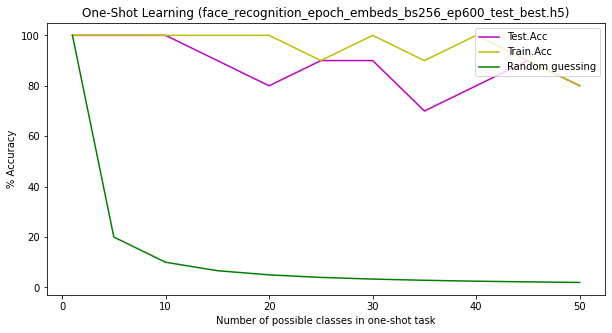

test 4 - model: facenet2_batch_embeds_bs256_ep600_test_best.h5
[[0.74448025]] 0 0
[[0.67300475]] 0 0
[[0.46603617]] 0 0
[[0.47674584]] 0 0
[[0.633999]] 0 0
[[0.6239042]] 0 0
[[0.72303736]] 0 0
[[0.6766823]] 0 0
[[0.4784229]] 0 0
[[0.70453995]] 0 0
[[0.51744676]] 0 0
[[0.7077518]] 0 0
[[0.69764626]] 0 0
[[0.53499645]] 0 0
[[0.7047885]] 0 0
[[0.578569]] 0 0
[[0.40681088]] 0 0
[[0.5873259]] 0 0
[[0.47041866]] 0 0
[[0.61804575]] 0 0
[[0.40756202]
 [0.7241214 ]
 [0.419698  ]
 [0.3799356 ]
 [0.38771078]] 1 1
[[0.3772196 ]
 [0.35555142]
 [0.4036208 ]
 [0.6704664 ]
 [0.40448913]] 3 3
[[0.40910605]
 [0.37142128]
 [0.44564247]
 [0.38794178]
 [0.5776658 ]] 4 4
[[0.40035126]
 [0.47602662]
 [0.45415372]
 [0.37398952]
 [0.42842135]] 1 1
[[0.39571232]
 [0.38682386]
 [0.5012109 ]
 [0.5148282 ]
 [0.41310525]] 3 3
[[0.41724715]
 [0.38159776]
 [0.6327236 ]
 [0.42487964]
 [0.39247137]] 2 2
[[0.4303524 ]
 [0.5212759 ]
 [0.39605522]
 [0.3993896 ]
 [0.42115706]] 1 1
[[0.76304996]
 [0.38709354]
 [0.41896367]


[[0.41419178]
 [0.42662388]
 [0.6543205 ]
 [0.3881693 ]
 [0.37498868]
 [0.39264682]
 [0.3773463 ]
 [0.4404894 ]
 [0.39248347]
 [0.420442  ]
 [0.41976386]
 [0.39611897]
 [0.39810246]
 [0.44746536]
 [0.3806158 ]] 2 2
[[0.37638438]
 [0.43506974]
 [0.41398627]
 [0.3921497 ]
 [0.44960803]
 [0.3966245 ]
 [0.42329693]
 [0.45397562]
 [0.3934744 ]
 [0.42715034]
 [0.37008575]
 [0.39927754]
 [0.37757364]
 [0.38811022]
 [0.3955744 ]] 7 4
[[0.4394881 ]
 [0.367941  ]
 [0.38448688]
 [0.39330903]
 [0.393087  ]
 [0.3932077 ]
 [0.39102346]
 [0.39160955]
 [0.37033102]
 [0.3920405 ]
 [0.3893927 ]
 [0.41926908]
 [0.41617966]
 [0.4186458 ]
 [0.37477738]
 [0.3844642 ]
 [0.38590357]
 [0.7156331 ]
 [0.3826794 ]
 [0.40334916]] 17 17
[[0.39814752]
 [0.38395053]
 [0.3775476 ]
 [0.39472818]
 [0.39379284]
 [0.3921384 ]
 [0.42416868]
 [0.38547128]
 [0.37079775]
 [0.4319436 ]
 [0.38557166]
 [0.6689629 ]
 [0.40296692]
 [0.41464376]
 [0.38223845]
 [0.38734546]
 [0.37549594]
 [0.41743767]
 [0.3902214 ]
 [0.41136384]] 11

[[0.53269184]
 [0.42255887]
 [0.41848272]
 [0.4349514 ]
 [0.45203882]
 [0.43410856]
 [0.47384784]
 [0.42932338]
 [0.4456789 ]
 [0.404829  ]
 [0.4447825 ]
 [0.43073267]
 [0.43657252]
 [0.40806937]
 [0.4556722 ]
 [0.42750412]
 [0.4250649 ]
 [0.42836702]
 [0.39945048]
 [0.4425547 ]
 [0.40502155]
 [0.41784424]
 [0.4541835 ]
 [0.48800004]
 [0.4496101 ]] 0 19
[[0.7047885 ]
 [0.41206843]
 [0.40147907]
 [0.4066486 ]
 [0.4213927 ]
 [0.42694145]
 [0.4088118 ]
 [0.4017782 ]
 [0.41039446]
 [0.43468636]
 [0.42468712]
 [0.40657237]
 [0.36910284]
 [0.41072986]
 [0.38746047]
 [0.39733618]
 [0.38120285]
 [0.4456789 ]
 [0.3989993 ]
 [0.38801035]
 [0.4046545 ]
 [0.3981908 ]
 [0.41329658]
 [0.4361387 ]
 [0.39603898]] 0 0
[[0.4112019 ]
 [0.39689207]
 [0.39576188]
 [0.4398384 ]
 [0.72246647]
 [0.40443426]
 [0.4460274 ]
 [0.41188174]
 [0.43379578]
 [0.411164  ]
 [0.39890477]
 [0.39855033]
 [0.41992933]
 [0.3767927 ]
 [0.3989473 ]
 [0.407656  ]
 [0.4313264 ]
 [0.40346998]
 [0.42633954]
 [0.46191898]
 [0.39633

[[0.36590677]
 [0.6803322 ]
 [0.42640668]
 [0.37937957]
 [0.3967799 ]
 [0.40713045]
 [0.38010845]
 [0.41042164]
 [0.38993782]
 [0.40058288]
 [0.39155155]
 [0.3843224 ]
 [0.3891759 ]
 [0.40234745]
 [0.43085134]
 [0.41176632]
 [0.3918084 ]
 [0.43078837]
 [0.3748032 ]
 [0.40644538]
 [0.4075374 ]
 [0.4357804 ]
 [0.409195  ]
 [0.39571244]
 [0.39299136]
 [0.39916176]
 [0.4056976 ]
 [0.3699272 ]
 [0.39848462]
 [0.380761  ]] 1 1
[[0.41683996]
 [0.38163355]
 [0.4280666 ]
 [0.41658527]
 [0.38724363]
 [0.39877227]
 [0.3920635 ]
 [0.39092183]
 [0.46231657]
 [0.3715511 ]
 [0.37852758]
 [0.50861865]
 [0.4465404 ]
 [0.4115175 ]
 [0.35861546]
 [0.39167327]
 [0.3820163 ]
 [0.37854126]
 [0.4052037 ]
 [0.4010966 ]
 [0.40450865]
 [0.3942045 ]
 [0.42970726]
 [0.431059  ]
 [0.39404824]
 [0.4239575 ]
 [0.41999874]
 [0.38785568]
 [0.41909847]
 [0.4011855 ]] 11 11
[[0.40376908]
 [0.41784006]
 [0.39519542]
 [0.42770204]
 [0.3948888 ]
 [0.38345525]
 [0.44160596]
 [0.4637852 ]
 [0.44035676]
 [0.4447325 ]
 [0.3966

[[0.37973428]
 [0.40271983]
 [0.38902608]
 [0.3763399 ]
 [0.41190523]
 [0.4411653 ]
 [0.38459772]
 [0.38652354]
 [0.38502863]
 [0.3852333 ]
 [0.37508777]
 [0.3683311 ]
 [0.3750756 ]
 [0.4183125 ]
 [0.38700682]
 [0.3889499 ]
 [0.39097962]
 [0.40037867]
 [0.4058386 ]
 [0.36843836]
 [0.40426034]
 [0.38489863]
 [0.37844765]
 [0.36037892]
 [0.40096697]
 [0.39736736]
 [0.37127247]
 [0.7047885 ]
 [0.39527854]
 [0.4463504 ]
 [0.40005767]
 [0.39714217]
 [0.39237577]
 [0.43160546]
 [0.42000383]] 27 27
[[0.386357  ]
 [0.38241196]
 [0.3741179 ]
 [0.4016632 ]
 [0.41141793]
 [0.37784868]
 [0.37619993]
 [0.40748852]
 [0.40230182]
 [0.4055895 ]
 [0.43408877]
 [0.4131436 ]
 [0.39207405]
 [0.3733507 ]
 [0.3845671 ]
 [0.39533174]
 [0.37644055]
 [0.43390667]
 [0.40880898]
 [0.4020235 ]
 [0.3682037 ]
 [0.4432319 ]
 [0.3829037 ]
 [0.41034865]
 [0.39195696]
 [0.41950053]
 [0.46111077]
 [0.40255395]
 [0.42145285]
 [0.3898689 ]
 [0.3845009 ]
 [0.43691528]
 [0.38493943]
 [0.43240872]
 [0.40037712]] 26 3
[[0.391

[[0.3928243 ]
 [0.3736321 ]
 [0.3959652 ]
 [0.3979724 ]
 [0.40240332]
 [0.38811022]
 [0.41951936]
 [0.39527804]
 [0.39644444]
 [0.4023255 ]
 [0.40319476]
 [0.39059612]
 [0.72256726]
 [0.39022094]
 [0.39336205]
 [0.40622258]
 [0.39261475]
 [0.41233492]
 [0.407431  ]
 [0.37865242]
 [0.42028844]
 [0.41030645]
 [0.39237708]
 [0.37211657]
 [0.39171502]
 [0.36501166]
 [0.40913126]
 [0.38973838]
 [0.3843891 ]
 [0.40670508]
 [0.3751289 ]
 [0.42122698]
 [0.42104065]
 [0.39023775]
 [0.3837732 ]
 [0.42665994]
 [0.3979467 ]
 [0.40103832]
 [0.40562505]
 [0.40976354]] 12 12
[[0.40879133]
 [0.4050013 ]
 [0.40860355]
 [0.39805773]
 [0.383478  ]
 [0.3790965 ]
 [0.41855663]
 [0.37250805]
 [0.4041254 ]
 [0.39708441]
 [0.4042955 ]
 [0.44508824]
 [0.3716725 ]
 [0.38563445]
 [0.6838635 ]
 [0.3769837 ]
 [0.38883746]
 [0.3880435 ]
 [0.42608672]
 [0.39675367]
 [0.43523365]
 [0.39936465]
 [0.36072552]
 [0.40041372]
 [0.40925312]
 [0.39438176]
 [0.39079553]
 [0.4041279 ]
 [0.40313923]
 [0.39362133]
 [0.38544324]

[[0.38816667]
 [0.46716666]
 [0.41570452]
 [0.39619613]
 [0.38956678]
 [0.36822253]
 [0.37907636]
 [0.39801672]
 [0.39538088]
 [0.44038773]
 [0.40373313]
 [0.41293466]
 [0.38219315]
 [0.42548102]
 [0.41478127]
 [0.43022722]
 [0.39111465]
 [0.40859538]
 [0.41373163]
 [0.39721525]
 [0.39968598]
 [0.39572904]
 [0.41830784]
 [0.38891077]
 [0.40361583]
 [0.39725664]
 [0.401222  ]
 [0.37757626]
 [0.3981035 ]
 [0.40000814]
 [0.3898649 ]
 [0.41741642]
 [0.4243173 ]
 [0.37018484]
 [0.39810452]
 [0.4149545 ]
 [0.39901224]
 [0.39084834]
 [0.4514245 ]
 [0.4195484 ]
 [0.40466967]
 [0.37343708]
 [0.35575277]
 [0.38532138]
 [0.4006366 ]] 1 38
[[0.36088246]
 [0.41259107]
 [0.4010966 ]
 [0.4058697 ]
 [0.38493973]
 [0.37176862]
 [0.40146664]
 [0.39316168]
 [0.42987472]
 [0.39450222]
 [0.3755949 ]
 [0.43530658]
 [0.37745452]
 [0.3770628 ]
 [0.37405464]
 [0.4031617 ]
 [0.35692233]
 [0.38166678]
 [0.3869187 ]
 [0.40443027]
 [0.36845046]
 [0.5447769 ]
 [0.37360668]
 [0.3568871 ]
 [0.3757973 ]
 [0.45563442]


[[0.3983597 ]
 [0.37567693]
 [0.39887264]
 [0.38982165]
 [0.40672684]
 [0.4466611 ]
 [0.44120952]
 [0.41337657]
 [0.39886034]
 [0.39395073]
 [0.4058874 ]
 [0.44728366]
 [0.41728777]
 [0.39492318]
 [0.43474668]
 [0.4201774 ]
 [0.44515157]
 [0.3846257 ]
 [0.42622006]
 [0.39485896]
 [0.41988844]
 [0.45710218]
 [0.40514463]
 [0.39424986]
 [0.4045977 ]
 [0.40371668]
 [0.4168957 ]
 [0.45776618]
 [0.40063563]
 [0.379256  ]
 [0.40603414]
 [0.45340735]
 [0.40464297]
 [0.37955272]
 [0.40067744]
 [0.3894938 ]
 [0.4302255 ]
 [0.4118362 ]
 [0.40821153]
 [0.39547575]
 [0.44784614]
 [0.38229644]
 [0.41002366]
 [0.3705568 ]
 [0.4326682 ]
 [0.4082897 ]
 [0.39679724]
 [0.47011605]
 [0.44554248]
 [0.47885245]] 49 40
[[0.36113307]
 [0.4152729 ]
 [0.38257274]
 [0.3719728 ]
 [0.36683255]
 [0.40566206]
 [0.39431575]
 [0.41920853]
 [0.4270014 ]
 [0.40090588]
 [0.37399516]
 [0.4152705 ]
 [0.3985293 ]
 [0.39616475]
 [0.39722425]
 [0.3829037 ]
 [0.40040275]
 [0.36849165]
 [0.3678665 ]
 [0.36604378]
 [0.3805777 ]

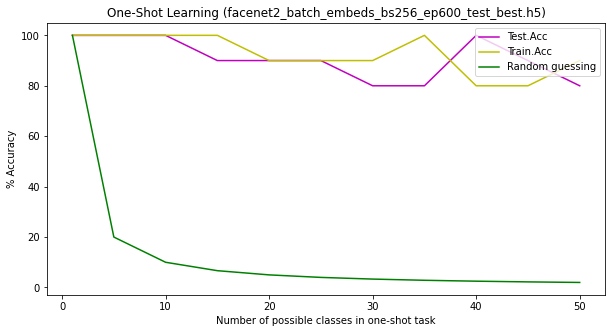

test 5 - model: facenet1_epoch_embeds_bs256_ep600_nway_best.h5
[[0.54602784]] 0 0
[[0.72963136]] 0 0
[[0.66888744]] 0 0
[[0.8431049]] 0 0
[[0.7962386]] 0 0
[[0.52266926]] 0 0
[[0.7691789]] 0 0
[[0.9140768]] 0 0
[[0.49122855]] 0 0
[[0.35813025]] 0 0
[[0.89239573]] 0 0
[[0.8533781]] 0 0
[[0.36410207]] 0 0
[[0.7804381]] 0 0
[[0.91225064]] 0 0
[[0.879453]] 0 0
[[0.7061894]] 0 0
[[0.71361935]] 0 0
[[0.8846041]] 0 0
[[0.67026955]] 0 0
[[0.26067087]
 [0.7430186 ]
 [0.28501564]
 [0.2780013 ]
 [0.32312036]] 1 1
[[0.40050578]
 [0.34236982]
 [0.28287345]
 [0.2600745 ]
 [0.27926078]] 0 0
[[0.24344125]
 [0.32369718]
 [0.33697903]
 [0.8843841 ]
 [0.3133686 ]] 3 3
[[0.28343946]
 [0.2626879 ]
 [0.23762082]
 [0.3367542 ]
 [0.2382566 ]] 3 3
[[0.27374366]
 [0.42563835]
 [0.29716063]
 [0.428612  ]
 [0.2603569 ]] 3 3
[[0.33328977]
 [0.66888744]
 [0.25678843]
 [0.32581154]
 [0.3174182 ]] 1 1
[[0.91889447]
 [0.28146392]
 [0.30341676]
 [0.27897632]
 [0.26372236]] 0 0
[[0.3004238 ]
 [0.3179956 ]
 [0.27213877]


[[0.32368404]
 [0.2901778 ]
 [0.2885446 ]
 [0.34033215]
 [0.2649638 ]
 [0.38156253]
 [0.3328676 ]
 [0.31592345]
 [0.32576   ]
 [0.31067687]
 [0.6702696 ]
 [0.3597788 ]
 [0.30897373]
 [0.30374104]
 [0.31440032]] 10 10
[[0.43700862]
 [0.23923635]
 [0.33580273]
 [0.3700528 ]
 [0.25605682]
 [0.28056002]
 [0.36384338]
 [0.44226894]
 [0.43896404]
 [0.32881072]
 [0.32789817]
 [0.37340787]
 [0.28256312]
 [0.30953616]
 [0.25651392]] 7 0
[[0.25443906]
 [0.26718593]
 [0.30720082]
 [0.25617027]
 [0.31733465]
 [0.25385284]
 [0.23936719]
 [0.25832647]
 [0.42291987]
 [0.29663584]
 [0.31232566]
 [0.22578874]
 [0.28405067]
 [0.26798877]
 [0.33278722]
 [0.24722758]
 [0.26167226]
 [0.2667007 ]
 [0.29031166]
 [0.9426438 ]] 19 19
[[0.2828303 ]
 [0.2961677 ]
 [0.4521921 ]
 [0.31167185]
 [0.32161665]
 [0.26387745]
 [0.26972663]
 [0.3010578 ]
 [0.286834  ]
 [0.311705  ]
 [0.4397536 ]
 [0.4226014 ]
 [0.33050597]
 [0.29252702]
 [0.3177883 ]
 [0.25212917]
 [0.32980692]
 [0.83846766]
 [0.44464543]
 [0.30344042]] 

[[0.28156516]
 [0.22201931]
 [0.23875383]
 [0.2707225 ]
 [0.24145746]
 [0.25595176]
 [0.2553962 ]
 [0.31968272]
 [0.2851553 ]
 [0.28327537]
 [0.894076  ]
 [0.41108775]
 [0.2602772 ]
 [0.29409784]
 [0.24586135]
 [0.3371966 ]
 [0.24967113]
 [0.3116756 ]
 [0.26202464]
 [0.24820355]
 [0.26039505]
 [0.3221088 ]
 [0.36645472]
 [0.2543373 ]
 [0.24361694]] 10 10
[[0.32472348]
 [0.82702434]
 [0.28516567]
 [0.2529961 ]
 [0.364438  ]
 [0.24063617]
 [0.28003556]
 [0.2754658 ]
 [0.25429463]
 [0.4081843 ]
 [0.23699152]
 [0.29895633]
 [0.3418213 ]
 [0.31516087]
 [0.28126264]
 [0.2397339 ]
 [0.38227874]
 [0.29268986]
 [0.32804823]
 [0.29576516]
 [0.25885797]
 [0.33954778]
 [0.32308954]
 [0.32145473]
 [0.29250613]] 1 1
[[0.29721928]
 [0.36597514]
 [0.37896326]
 [0.32274926]
 [0.25612134]
 [0.31544328]
 [0.33485514]
 [0.29911882]
 [0.36210713]
 [0.30767345]
 [0.3769766 ]
 [0.33377403]
 [0.3252688 ]
 [0.43232638]
 [0.31527698]
 [0.28912103]
 [0.35317084]
 [0.31331083]
 [0.32685506]
 [0.73439026]
 [0.3002

[[0.39454418]
 [0.2628187 ]
 [0.3203923 ]
 [0.2529332 ]
 [0.59077287]
 [0.29688925]
 [0.33969122]
 [0.30590153]
 [0.28189433]
 [0.2749962 ]
 [0.29623187]
 [0.25287217]
 [0.31447148]
 [0.28408206]
 [0.41659546]
 [0.28929284]
 [0.27035862]
 [0.30684572]
 [0.2633469 ]
 [0.29848057]
 [0.28609586]
 [0.4183212 ]
 [0.2733193 ]
 [0.35481513]
 [0.22020692]
 [0.29064643]
 [0.2600328 ]
 [0.27830803]
 [0.3143514 ]
 [0.24347812]] 4 4
[[0.28374934]
 [0.5971989 ]
 [0.28650337]
 [0.31740385]
 [0.28765234]
 [0.30827928]
 [0.26310396]
 [0.2763514 ]
 [0.31123942]
 [0.28544843]
 [0.31627667]
 [0.30689156]
 [0.2700745 ]
 [0.39338183]
 [0.33302063]
 [0.28563595]
 [0.27201465]
 [0.27713883]
 [0.24219328]
 [0.4124915 ]
 [0.2686615 ]
 [0.31077504]
 [0.3378998 ]
 [0.30125874]
 [0.28988817]
 [0.26373968]
 [0.27265194]
 [0.28916833]
 [0.28521475]
 [0.36169085]] 1 1
[[0.30520463]
 [0.3701492 ]
 [0.2595273 ]
 [0.3361295 ]
 [0.243646  ]
 [0.32082686]
 [0.28628665]
 [0.28142256]
 [0.27138305]
 [0.31340587]
 [0.254690

[[0.3221088 ]
 [0.27454573]
 [0.2694661 ]
 [0.3247838 ]
 [0.38217276]
 [0.3114344 ]
 [0.27566263]
 [0.35505104]
 [0.34954935]
 [0.33324766]
 [0.33232123]
 [0.2899022 ]
 [0.29388216]
 [0.32988703]
 [0.35347575]
 [0.29285896]
 [0.28646863]
 [0.30868667]
 [0.5061805 ]
 [0.29963022]
 [0.39217737]
 [0.40982282]
 [0.27660215]
 [0.2988137 ]
 [0.29770905]
 [0.28867507]
 [0.31778198]
 [0.35196823]
 [0.40677527]
 [0.3204438 ]
 [0.33286983]
 [0.28900468]
 [0.30674148]
 [0.3523413 ]
 [0.40790552]] 18 18
[[0.36961812]
 [0.2780136 ]
 [0.28647032]
 [0.2815442 ]
 [0.28014943]
 [0.25311932]
 [0.29018188]
 [0.30059206]
 [0.26434433]
 [0.336627  ]
 [0.3359655 ]
 [0.26005086]
 [0.33594117]
 [0.27902377]
 [0.25019485]
 [0.2694906 ]
 [0.26943517]
 [0.31527522]
 [0.2970131 ]
 [0.3718518 ]
 [0.29890472]
 [0.3980906 ]
 [0.33289504]
 [0.2835098 ]
 [0.2531907 ]
 [0.3123166 ]
 [0.34735662]
 [0.24191463]
 [0.28789502]
 [0.84788066]
 [0.30022663]
 [0.26331437]
 [0.32284677]
 [0.33208555]
 [0.3026527 ]] 29 29
[[0.42

[[0.3370682 ]
 [0.26277637]
 [0.24658442]
 [0.2587914 ]
 [0.32026902]
 [0.2849422 ]
 [0.38643473]
 [0.25235364]
 [0.28534418]
 [0.31038737]
 [0.3383181 ]
 [0.32046252]
 [0.7111689 ]
 [0.3058092 ]
 [0.31036377]
 [0.2912981 ]
 [0.33842808]
 [0.33319306]
 [0.3734032 ]
 [0.26015538]
 [0.31067425]
 [0.37684894]
 [0.26883328]
 [0.2970168 ]
 [0.43556145]
 [0.2877888 ]
 [0.32238483]
 [0.25056538]
 [0.28386503]
 [0.4032879 ]
 [0.321426  ]
 [0.33462885]
 [0.27873245]
 [0.271731  ]
 [0.35172826]
 [0.27481407]
 [0.37547293]
 [0.2822758 ]
 [0.29842407]
 [0.34930575]] 12 12
[[0.29528338]
 [0.30547982]
 [0.2876447 ]
 [0.3453563 ]
 [0.37366635]
 [0.28259218]
 [0.2708723 ]
 [0.24983412]
 [0.32979095]
 [0.25463864]
 [0.30753726]
 [0.26521412]
 [0.24337846]
 [0.34272838]
 [0.24106047]
 [0.25539738]
 [0.24598128]
 [0.2834558 ]
 [0.2915673 ]
 [0.34167546]
 [0.2920696 ]
 [0.28489766]
 [0.26211473]
 [0.31328088]
 [0.3186754 ]
 [0.24012151]
 [0.29912427]
 [0.28010815]
 [0.35831952]
 [0.46524647]
 [0.32971975]

[[0.28512594]
 [0.29677778]
 [0.29961973]
 [0.2626811 ]
 [0.22752064]
 [0.2456199 ]
 [0.32315412]
 [0.22107157]
 [0.26718074]
 [0.29773894]
 [0.29000503]
 [0.27632016]
 [0.24834317]
 [0.25501084]
 [0.3032121 ]
 [0.24870107]
 [0.26561826]
 [0.2624732 ]
 [0.27879414]
 [0.2947024 ]
 [0.23873568]
 [0.26140386]
 [0.2514794 ]
 [0.24657959]
 [0.25376636]
 [0.26745626]
 [0.24970642]
 [0.28366828]
 [0.23540962]
 [0.28111017]
 [0.3512448 ]
 [0.26204   ]
 [0.26277918]
 [0.29284632]
 [0.23865622]
 [0.26246482]
 [0.3895122 ]
 [0.32598543]
 [0.24956316]
 [0.28190333]
 [0.26277065]
 [0.25074422]
 [0.773202  ]
 [0.25993454]
 [0.2776807 ]] 42 42
[[0.27500868]
 [0.27128798]
 [0.25488687]
 [0.3265277 ]
 [0.83619666]
 [0.28182518]
 [0.26687872]
 [0.2665035 ]
 [0.26349783]
 [0.3098414 ]
 [0.33612078]
 [0.2522933 ]
 [0.27745324]
 [0.34900463]
 [0.29772264]
 [0.41179746]
 [0.28979394]
 [0.29786748]
 [0.32693124]
 [0.28484213]
 [0.2808816 ]
 [0.25572723]
 [0.29338   ]
 [0.26252323]
 [0.24542162]
 [0.27681333]

[[0.27244532]
 [0.27100685]
 [0.29426086]
 [0.3868568 ]
 [0.2855518 ]
 [0.30523062]
 [0.2449027 ]
 [0.28120685]
 [0.30402043]
 [0.28926882]
 [0.29054832]
 [0.27706712]
 [0.28071225]
 [0.32414526]
 [0.2446627 ]
 [0.2362679 ]
 [0.31458807]
 [0.23157772]
 [0.29525065]
 [0.3256682 ]
 [0.2554387 ]
 [0.37242788]
 [0.2714432 ]
 [0.26310915]
 [0.30761164]
 [0.2848721 ]
 [0.25246432]
 [0.88478786]
 [0.31970102]
 [0.3179494 ]
 [0.33256808]
 [0.25973797]
 [0.23879448]
 [0.25657332]
 [0.27753937]
 [0.32555783]
 [0.32724994]
 [0.39507607]
 [0.2581612 ]
 [0.2918982 ]
 [0.30385268]
 [0.26307467]
 [0.2662456 ]
 [0.2508114 ]
 [0.2729034 ]
 [0.30549666]
 [0.28170115]
 [0.22688675]
 [0.25414568]
 [0.26065263]] 27 27
[[0.30869213]
 [0.33956277]
 [0.3087645 ]
 [0.294546  ]
 [0.35525864]
 [0.34069145]
 [0.32138157]
 [0.32891703]
 [0.23193407]
 [0.3305117 ]
 [0.29757679]
 [0.4245354 ]
 [0.32970905]
 [0.365196  ]
 [0.33791375]
 [0.27506322]
 [0.2856061 ]
 [0.25158346]
 [0.2904525 ]
 [0.27722245]
 [0.27346683]

[[0.2439611 ]
 [0.23963207]
 [0.26572755]
 [0.30505216]
 [0.3712513 ]
 [0.29001   ]
 [0.23751074]
 [0.281105  ]
 [0.23566684]
 [0.31244436]
 [0.233581  ]
 [0.24082172]
 [0.7061894 ]
 [0.3100373 ]
 [0.26214844]
 [0.2930491 ]
 [0.297692  ]
 [0.30284482]
 [0.31238192]
 [0.41228434]
 [0.26379174]
 [0.24760622]
 [0.2441723 ]
 [0.2538649 ]
 [0.2429927 ]
 [0.31461567]
 [0.2628951 ]
 [0.37668377]
 [0.26274988]
 [0.28991807]
 [0.3218006 ]
 [0.2968973 ]
 [0.27641875]
 [0.30414206]
 [0.28876007]
 [0.34684247]
 [0.22936139]
 [0.24548757]
 [0.2654717 ]
 [0.2763479 ]
 [0.2658772 ]
 [0.31224763]
 [0.3039662 ]
 [0.29576784]
 [0.23653117]
 [0.37930137]
 [0.3083976 ]
 [0.3885003 ]
 [0.3028287 ]
 [0.26292786]] 12 12
[[0.30195084]
 [0.28158873]
 [0.263119  ]
 [0.28967732]
 [0.30235544]
 [0.31679177]
 [0.25397927]
 [0.30753726]
 [0.33083767]
 [0.6529508 ]
 [0.39842263]
 [0.30839434]
 [0.3185662 ]
 [0.33160275]
 [0.27174467]
 [0.2674009 ]
 [0.3849999 ]
 [0.28413832]
 [0.28022552]
 [0.29588795]
 [0.2673702 ]

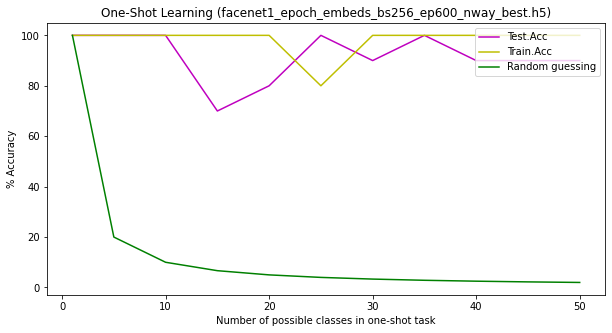

test 6 - model: facenet1_batch_embeds_bs256_ep600_final.h5
[[0.88722557]] 0 0
[[0.7536165]] 0 0
[[0.39883158]] 0 0
[[0.67241627]] 0 0
[[0.921782]] 0 0
[[0.92074686]] 0 0
[[0.5558162]] 0 0
[[0.23966745]] 0 0
[[0.94572806]] 0 0
[[0.6050537]] 0 0
[[0.5265736]] 0 0
[[0.9414401]] 0 0
[[0.921507]] 0 0
[[0.92347187]] 0 0
[[0.81652945]] 0 0
[[0.83711934]] 0 0
[[0.91566503]] 0 0
[[0.5265736]] 0 0
[[0.55420065]] 0 0
[[0.89693356]] 0 0
[[0.47099894]
 [0.226709  ]
 [0.2116571 ]
 [0.15582696]
 [0.21380913]] 0 0
[[0.23016489]
 [0.26862362]
 [0.26105627]
 [0.91876364]
 [0.32182613]] 3 3
[[0.24759641]
 [0.20986018]
 [0.5431226 ]
 [0.16837627]
 [0.1755958 ]] 2 2
[[0.3386517 ]
 [0.4547362 ]
 [0.17320389]
 [0.26010147]
 [0.932121  ]] 4 4
[[0.21380319]
 [0.2646094 ]
 [0.18019003]
 [0.1844912 ]
 [0.24710669]] 1 4
[[0.37280503]
 [0.6266855 ]
 [0.17801441]
 [0.19138187]
 [0.23211078]] 1 1
[[0.2753879 ]
 [0.17204045]
 [0.81673217]
 [0.1877458 ]
 [0.1574223 ]] 2 2
[[0.50421095]
 [0.18915594]
 [0.25651988]
 [0.

[[0.24403638]
 [0.32964373]
 [0.18995836]
 [0.24644461]
 [0.27437603]
 [0.77947885]
 [0.22971314]
 [0.21856487]
 [0.39280623]
 [0.1843149 ]
 [0.22774065]
 [0.1918342 ]
 [0.28846684]
 [0.23087214]
 [0.23089372]] 5 5
[[0.2225165 ]
 [0.1618163 ]
 [0.31724787]
 [0.31419984]
 [0.54418355]
 [0.24999154]
 [0.19395861]
 [0.20203966]
 [0.18575418]
 [0.2153084 ]
 [0.17064674]
 [0.4141549 ]
 [0.3302916 ]
 [0.35306725]
 [0.2182674 ]] 4 4
[[0.32342368]
 [0.20075643]
 [0.24888784]
 [0.20162475]
 [0.18740901]
 [0.22602686]
 [0.2538864 ]
 [0.3370205 ]
 [0.19238022]
 [0.19058582]
 [0.18818715]
 [0.2622035 ]
 [0.29561812]
 [0.1663655 ]
 [0.9481407 ]
 [0.27735692]
 [0.24196067]
 [0.21240234]
 [0.24892709]
 [0.30061516]] 14 14
[[0.64153564]
 [0.23535356]
 [0.20722595]
 [0.20587662]
 [0.231832  ]
 [0.6089228 ]
 [0.2011903 ]
 [0.22326654]
 [0.20437011]
 [0.21070352]
 [0.17807451]
 [0.29404885]
 [0.3284191 ]
 [0.24345803]
 [0.21365133]
 [0.19952026]
 [0.33785123]
 [0.21391997]
 [0.1965831 ]
 [0.27560443]] 0 

[[0.28154674]
 [0.34130907]
 [0.19800022]
 [0.24372873]
 [0.21983185]
 [0.337089  ]
 [0.262056  ]
 [0.34899366]
 [0.24111795]
 [0.2669019 ]
 [0.18568754]
 [0.23087901]
 [0.20013088]
 [0.39301613]
 [0.21735469]
 [0.19983882]
 [0.211683  ]
 [0.22817439]
 [0.29877245]
 [0.25194252]
 [0.83619285]
 [0.2297982 ]
 [0.23213598]
 [0.21303564]
 [0.14110287]] 20 20
[[0.21602798]
 [0.25861907]
 [0.24214345]
 [0.23360056]
 [0.28671658]
 [0.28955275]
 [0.26862228]
 [0.20242813]
 [0.22535184]
 [0.28904378]
 [0.1798172 ]
 [0.19818884]
 [0.24171391]
 [0.22865075]
 [0.20689198]
 [0.4110445 ]
 [0.1830005 ]
 [0.911961  ]
 [0.2334488 ]
 [0.23685402]
 [0.29065472]
 [0.2827436 ]
 [0.20529374]
 [0.17147094]
 [0.3139993 ]] 17 17
[[0.3028853 ]
 [0.29539514]
 [0.23289123]
 [0.21825549]
 [0.27373865]
 [0.5276822 ]
 [0.2638595 ]
 [0.52657354]
 [0.29734707]
 [0.27060503]
 [0.2440629 ]
 [0.38385728]
 [0.23423138]
 [0.34689015]
 [0.23196226]
 [0.40834332]
 [0.33428654]
 [0.3087964 ]
 [0.4066081 ]
 [0.22796252]
 [0.28

[[0.20904845]
 [0.3497998 ]
 [0.28738487]
 [0.40988111]
 [0.26181918]
 [0.21462569]
 [0.26603818]
 [0.19270933]
 [0.26039743]
 [0.23956063]
 [0.205582  ]
 [0.26680538]
 [0.21656051]
 [0.47060627]
 [0.27469915]
 [0.2500376 ]
 [0.24365821]
 [0.27069664]
 [0.6638825 ]
 [0.1910145 ]
 [0.22749278]
 [0.27012283]
 [0.22247109]
 [0.29948217]
 [0.23673177]
 [0.31958476]
 [0.22984982]
 [0.4099498 ]
 [0.2342021 ]
 [0.25561464]] 18 18
[[0.17186436]
 [0.24808258]
 [0.44017795]
 [0.19636294]
 [0.16341248]
 [0.39855146]
 [0.15677977]
 [0.22039518]
 [0.17001644]
 [0.16362813]
 [0.18265054]
 [0.3021686 ]
 [0.2320959 ]
 [0.17365259]
 [0.20308557]
 [0.1459595 ]
 [0.1898902 ]
 [0.14826775]
 [0.14582554]
 [0.14437792]
 [0.15965116]
 [0.26468617]
 [0.2230052 ]
 [0.19353136]
 [0.21663217]
 [0.1952903 ]
 [0.20448235]
 [0.17714424]
 [0.16574095]
 [0.21162522]] 2 11
[[0.27686584]
 [0.20703498]
 [0.2851718 ]
 [0.18192601]
 [0.29180622]
 [0.26998055]
 [0.36371517]
 [0.22148722]
 [0.21960849]
 [0.19007519]
 [0.196

[[0.17377084]
 [0.22971314]
 [0.22260278]
 [0.23886704]
 [0.261655  ]
 [0.22049403]
 [0.18155679]
 [0.16218895]
 [0.21119854]
 [0.17201313]
 [0.17629868]
 [0.22326371]
 [0.15617299]
 [0.27815437]
 [0.15453634]
 [0.19053927]
 [0.16656175]
 [0.18460226]
 [0.20462611]
 [0.24346477]
 [0.945488  ]
 [0.20236826]
 [0.21004292]
 [0.2054506 ]
 [0.24718675]
 [0.19514123]
 [0.18777892]
 [0.15138942]
 [0.41385597]
 [0.20289949]
 [0.17281103]
 [0.16386569]
 [0.16992454]
 [0.23789096]
 [0.2239401 ]] 20 20
[[0.27591392]
 [0.3106624 ]
 [0.23362267]
 [0.2531337 ]
 [0.24783376]
 [0.43165672]
 [0.30664843]
 [0.27117157]
 [0.7794857 ]
 [0.20897993]
 [0.26156932]
 [0.30736992]
 [0.3265398 ]
 [0.2591229 ]
 [0.21670043]
 [0.2915629 ]
 [0.27212277]
 [0.20649484]
 [0.24014723]
 [0.25212544]
 [0.64790034]
 [0.3643199 ]
 [0.25074244]
 [0.335833  ]
 [0.29503715]
 [0.2444902 ]
 [0.51935333]
 [0.2617182 ]
 [0.23298028]
 [0.43549755]
 [0.29117265]
 [0.25578445]
 [0.2629201 ]
 [0.21872565]
 [0.2624266 ]] 8 8
[[0.2454

[[0.3150658 ]
 [0.1769486 ]
 [0.24228454]
 [0.21829596]
 [0.17229062]
 [0.17559543]
 [0.28794998]
 [0.2873503 ]
 [0.27512282]
 [0.9107076 ]
 [0.19111618]
 [0.2504698 ]
 [0.2279262 ]
 [0.19387525]
 [0.22968748]
 [0.21745428]
 [0.2288881 ]
 [0.2264404 ]
 [0.2656086 ]
 [0.21135011]
 [0.15882793]
 [0.15597168]
 [0.2612545 ]
 [0.18632892]
 [0.16430908]
 [0.17411491]
 [0.22728378]
 [0.18141457]
 [0.16050068]
 [0.14208406]
 [0.21605107]
 [0.19157687]
 [0.26237524]
 [0.21527609]
 [0.1804398 ]
 [0.1928083 ]
 [0.18031195]
 [0.19488996]
 [0.2034767 ]
 [0.2468436 ]
 [0.23608167]
 [0.31631628]
 [0.22305961]
 [0.23946694]
 [0.21027926]] 9 9
[[0.91824615]
 [0.18282118]
 [0.25494018]
 [0.29674062]
 [0.18613827]
 [0.22986019]
 [0.25671166]
 [0.1907644 ]
 [0.22327903]
 [0.25756574]
 [0.17273432]
 [0.23274627]
 [0.15515068]
 [0.23368701]
 [0.27492118]
 [0.18372121]
 [0.18366933]
 [0.27587527]
 [0.15459353]
 [0.17765221]
 [0.1822539 ]
 [0.22539175]
 [0.2149351 ]
 [0.20656672]
 [0.22002557]
 [0.17525825]
 

[[0.28156185]
 [0.30322385]
 [0.1874798 ]
 [0.23247498]
 [0.2212959 ]
 [0.28070477]
 [0.19760713]
 [0.3313927 ]
 [0.22417009]
 [0.26785088]
 [0.29012877]
 [0.18266639]
 [0.40011185]
 [0.6890949 ]
 [0.2809565 ]
 [0.33977687]
 [0.2310738 ]
 [0.28529823]
 [0.278826  ]
 [0.32517198]
 [0.31923127]
 [0.35383046]
 [0.18593302]
 [0.1898    ]
 [0.31033075]
 [0.27337205]
 [0.25824648]
 [0.24716252]
 [0.17177215]
 [0.22596028]
 [0.25424886]
 [0.2732433 ]
 [0.2070328 ]
 [0.16831818]
 [0.18654367]
 [0.3190707 ]
 [0.22007981]
 [0.20540276]
 [0.16088331]
 [0.1910632 ]
 [0.23059759]
 [0.27744976]
 [0.17933692]
 [0.23857147]
 [0.30625564]] 13 13
[[0.21891329]
 [0.20737523]
 [0.17832804]
 [0.31315833]
 [0.1958501 ]
 [0.22431222]
 [0.16592687]
 [0.25462484]
 [0.23388705]
 [0.20296016]
 [0.1599232 ]
 [0.26618725]
 [0.22321206]
 [0.2117565 ]
 [0.21492726]
 [0.21340784]
 [0.19671002]
 [0.20918697]
 [0.21617666]
 [0.7537396 ]
 [0.2102738 ]
 [0.20357141]
 [0.23629865]
 [0.2122744 ]
 [0.17712304]
 [0.20649397]

[[0.31169546]
 [0.337221  ]
 [0.34093285]
 [0.20300263]
 [0.3372904 ]
 [0.22468361]
 [0.26417416]
 [0.19648418]
 [0.28583655]
 [0.20126364]
 [0.9159671 ]
 [0.28554747]
 [0.25890023]
 [0.21194363]
 [0.21461558]
 [0.28618246]
 [0.29893553]
 [0.20603567]
 [0.19800395]
 [0.22843581]
 [0.33436984]
 [0.20964843]
 [0.23481792]
 [0.24060476]
 [0.19640145]
 [0.19545844]
 [0.19780755]
 [0.3061903 ]
 [0.14071006]
 [0.19111344]
 [0.2678898 ]
 [0.20919469]
 [0.18588072]
 [0.24306756]
 [0.22929266]
 [0.22410643]
 [0.29488325]
 [0.21771836]
 [0.26619524]
 [0.25098044]
 [0.23441604]
 [0.24245143]
 [0.20394841]
 [0.28554377]
 [0.1809318 ]
 [0.22323725]
 [0.2799963 ]
 [0.27695382]
 [0.41928375]
 [0.40309715]] 10 10
[[0.34083915]
 [0.21752849]
 [0.2730656 ]
 [0.39650702]
 [0.34109265]
 [0.25175816]
 [0.34676516]
 [0.38015518]
 [0.34622246]
 [0.26080233]
 [0.21917543]
 [0.2012926 ]
 [0.20549598]
 [0.3387205 ]
 [0.1967527 ]
 [0.24438334]
 [0.29427034]
 [0.3012787 ]
 [0.26190156]
 [0.19745901]
 [0.37737423]

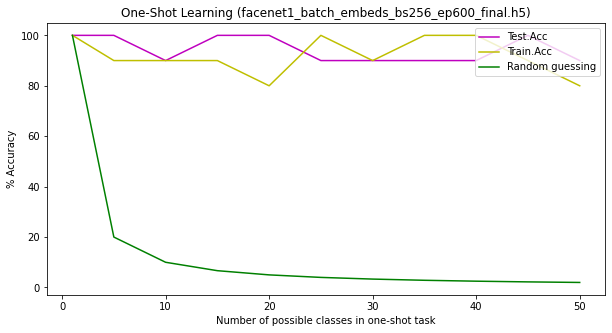

test 7 - model: facenet2_batch_embeds_bs256_ep600_final.h5
[[0.71646297]] 0 0
[[0.7079925]] 0 0
[[0.61766905]] 0 0
[[0.92923564]] 0 0
[[0.6991959]] 0 0
[[0.9388808]] 0 0
[[0.56858265]] 0 0
[[0.6691649]] 0 0
[[0.9515215]] 0 0
[[0.9167299]] 0 0
[[0.9016876]] 0 0
[[0.93702674]] 0 0
[[0.94251627]] 0 0
[[0.9241344]] 0 0
[[0.7923313]] 0 0
[[0.38786286]] 0 0
[[0.78669447]] 0 0
[[0.7318798]] 0 0
[[0.61632204]] 0 0
[[0.8973197]] 0 0
[[0.31713974]
 [0.8691565 ]
 [0.34280238]
 [0.26688483]
 [0.33874473]] 1 1
[[0.21624239]
 [0.8085091 ]
 [0.3086503 ]
 [0.33479455]
 [0.23630513]] 1 1
[[0.19828737]
 [0.22212735]
 [0.20121785]
 [0.8989662 ]
 [0.2740238 ]] 3 3
[[0.30728406]
 [0.32367685]
 [0.6819957 ]
 [0.2905465 ]
 [0.19715019]] 2 2
[[0.49944004]
 [0.23285796]
 [0.3612331 ]
 [0.29065588]
 [0.68683785]] 4 4
[[0.9146801 ]
 [0.21055727]
 [0.2881911 ]
 [0.31483677]
 [0.4145963 ]] 0 0
[[0.2582291 ]
 [0.17556342]
 [0.33171678]
 [0.3182239 ]
 [0.5066256 ]] 4 4
[[0.26217934]
 [0.18825677]
 [0.23011531]
 [0.9

[[0.3095123 ]
 [0.2926188 ]
 [0.28069025]
 [0.2697404 ]
 [0.29128438]
 [0.20066884]
 [0.28364813]
 [0.3547837 ]
 [0.21614715]
 [0.23671374]
 [0.29407096]
 [0.21990994]
 [0.21222979]
 [0.34104162]
 [0.3540331 ]
 [0.27794427]
 [0.2914827 ]
 [0.37697414]
 [0.2551405 ]
 [0.37181225]] 17 19
[[0.26835173]
 [0.18300024]
 [0.32285273]
 [0.20324072]
 [0.26370516]
 [0.16321802]
 [0.83827215]
 [0.25137073]
 [0.26893783]
 [0.18605629]
 [0.2818122 ]
 [0.19548163]
 [0.2528063 ]
 [0.1920811 ]
 [0.22421277]
 [0.18991828]
 [0.2056982 ]
 [0.1962309 ]
 [0.17141625]
 [0.1971176 ]] 6 6
[[0.19568679]
 [0.24555361]
 [0.21536556]
 [0.8846644 ]
 [0.18532044]
 [0.17713097]
 [0.17430186]
 [0.24829194]
 [0.18395895]
 [0.27493557]
 [0.2292887 ]
 [0.21835959]
 [0.19516951]
 [0.32998627]
 [0.21759287]
 [0.21449924]
 [0.26634213]
 [0.28894523]
 [0.17393105]
 [0.21262594]] 3 3
[[0.9049202 ]
 [0.20951384]
 [0.22891942]
 [0.23435754]
 [0.20910528]
 [0.26933092]
 [0.33994704]
 [0.25406462]
 [0.2879957 ]
 [0.3284913 ]
 [0

[[0.23096257]
 [0.29199368]
 [0.291555  ]
 [0.287534  ]
 [0.34786266]
 [0.22287318]
 [0.24989095]
 [0.24856049]
 [0.17708853]
 [0.24991736]
 [0.24661833]
 [0.22618753]
 [0.26638383]
 [0.22992915]
 [0.23162138]
 [0.23683178]
 [0.24854028]
 [0.22059277]
 [0.89905614]
 [0.19395187]
 [0.38045472]
 [0.18134758]
 [0.22314715]
 [0.36903697]
 [0.2894794 ]] 18 18
[[0.19587249]
 [0.2968328 ]
 [0.25325647]
 [0.20563608]
 [0.33030015]
 [0.20112798]
 [0.29563802]
 [0.1669159 ]
 [0.25108135]
 [0.26234245]
 [0.22935182]
 [0.23836976]
 [0.23608866]
 [0.22507024]
 [0.2299015 ]
 [0.30031615]
 [0.23426956]
 [0.32088196]
 [0.23999932]
 [0.17408457]
 [0.18437418]
 [0.19923213]
 [0.8516497 ]
 [0.21189675]
 [0.25856066]] 22 22
[[0.29531866]
 [0.20027453]
 [0.21471477]
 [0.21689507]
 [0.2373729 ]
 [0.2393238 ]
 [0.24739161]
 [0.2190944 ]
 [0.22252554]
 [0.22326258]
 [0.25051793]
 [0.29423854]
 [0.28162178]
 [0.21424568]
 [0.21110305]
 [0.19265407]
 [0.1783545 ]
 [0.26637542]
 [0.19374114]
 [0.308467  ]
 [0.21

[[0.25711685]
 [0.22230574]
 [0.19024685]
 [0.21181491]
 [0.20385292]
 [0.19729042]
 [0.1689902 ]
 [0.19443765]
 [0.26063168]
 [0.19067198]
 [0.3132648 ]
 [0.89905614]
 [0.29971075]
 [0.24602723]
 [0.22814775]
 [0.17582646]
 [0.17364976]
 [0.21572235]
 [0.20183581]
 [0.20998952]
 [0.30349192]
 [0.16731966]
 [0.30928242]
 [0.20372301]
 [0.21108595]
 [0.1942876 ]
 [0.2203451 ]
 [0.21864262]
 [0.20303887]
 [0.21282016]] 11 11
[[0.23068196]
 [0.2687035 ]
 [0.25836122]
 [0.24282497]
 [0.23621577]
 [0.2038779 ]
 [0.18237555]
 [0.2567513 ]
 [0.23704669]
 [0.22249061]
 [0.29468167]
 [0.26413423]
 [0.21878397]
 [0.16952753]
 [0.20192331]
 [0.18929276]
 [0.20033377]
 [0.15953803]
 [0.22329998]
 [0.28931367]
 [0.23444879]
 [0.1611332 ]
 [0.23555705]
 [0.20192382]
 [0.25105888]
 [0.27095848]
 [0.16859002]
 [0.23280054]
 [0.3201592 ]
 [0.78669447]] 29 29
[[0.23539439]
 [0.29673523]
 [0.3826866 ]
 [0.33396953]
 [0.19108865]
 [0.21287647]
 [0.22333634]
 [0.1892035 ]
 [0.20844045]
 [0.2179192 ]
 [0.21

[[0.25679836]
 [0.25575787]
 [0.24657166]
 [0.21704787]
 [0.23658073]
 [0.1857208 ]
 [0.25281274]
 [0.3054893 ]
 [0.24432155]
 [0.22077805]
 [0.2336725 ]
 [0.25419563]
 [0.21815091]
 [0.25006378]
 [0.30165017]
 [0.21592954]
 [0.2751488 ]
 [0.23355767]
 [0.2529639 ]
 [0.3074485 ]
 [0.2978581 ]
 [0.27425867]
 [0.20162556]
 [0.2817912 ]
 [0.22150326]
 [0.22009176]
 [0.369585  ]
 [0.23802236]
 [0.24526629]
 [0.30898476]
 [0.39701974]
 [0.272268  ]
 [0.91228515]
 [0.20583351]
 [0.24015364]] 32 32
[[0.2915855 ]
 [0.2001931 ]
 [0.21569145]
 [0.19372588]
 [0.2064949 ]
 [0.21342078]
 [0.2324523 ]
 [0.22659272]
 [0.312927  ]
 [0.20342764]
 [0.27695844]
 [0.28687227]
 [0.24074835]
 [0.20257905]
 [0.3041935 ]
 [0.17220038]
 [0.21586382]
 [0.2558101 ]
 [0.23829156]
 [0.21355012]
 [0.20613134]
 [0.8973197 ]
 [0.2832178 ]
 [0.18159682]
 [0.2520435 ]
 [0.29971743]
 [0.20466971]
 [0.32066038]
 [0.24118155]
 [0.29807127]
 [0.27607957]
 [0.26805425]
 [0.18487339]
 [0.26225534]
 [0.27276757]] 21 21
[[0.45

[[0.22395667]
 [0.22045395]
 [0.21133131]
 [0.21321857]
 [0.19434333]
 [0.21001565]
 [0.23077485]
 [0.24133807]
 [0.23635292]
 [0.26925194]
 [0.22072122]
 [0.28999767]
 [0.26476482]
 [0.2087324 ]
 [0.33609986]
 [0.18157265]
 [0.22795928]
 [0.60920334]
 [0.2256892 ]
 [0.20030826]
 [0.23691583]
 [0.28180045]
 [0.20748517]
 [0.21961564]
 [0.2505126 ]
 [0.20508608]
 [0.26137817]
 [0.21238741]
 [0.546971  ]
 [0.3428195 ]
 [0.23652378]
 [0.2275596 ]
 [0.29232022]
 [0.2544835 ]
 [0.26106125]
 [0.27470613]
 [0.22873533]
 [0.27485982]
 [0.18474063]
 [0.2777914 ]] 17 17
[[0.2509538 ]
 [0.19422567]
 [0.1811932 ]
 [0.22711343]
 [0.30488944]
 [0.24581581]
 [0.20309013]
 [0.2137301 ]
 [0.22529018]
 [0.23383385]
 [0.21268964]
 [0.20940733]
 [0.1800524 ]
 [0.29683942]
 [0.20103401]
 [0.24711794]
 [0.23880377]
 [0.2189211 ]
 [0.2823157 ]
 [0.29261738]
 [0.31779617]
 [0.24236083]
 [0.9225771 ]
 [0.2509299 ]
 [0.25816393]
 [0.2326788 ]
 [0.20523745]
 [0.27823842]
 [0.27301773]
 [0.26973218]
 [0.23392397]

[[0.23160961]
 [0.27377272]
 [0.22345677]
 [0.19691473]
 [0.21099618]
 [0.37581807]
 [0.19260108]
 [0.27349114]
 [0.19628981]
 [0.22087675]
 [0.24014789]
 [0.19887018]
 [0.4033199 ]
 [0.21848002]
 [0.2087704 ]
 [0.19540742]
 [0.26778215]
 [0.2453346 ]
 [0.31724703]
 [0.24059781]
 [0.2503506 ]
 [0.23175654]
 [0.2350305 ]
 [0.2753548 ]
 [0.29081288]
 [0.3753952 ]
 [0.3011409 ]
 [0.26432797]
 [0.21512535]
 [0.19068477]
 [0.2800378 ]
 [0.19349891]
 [0.22956637]
 [0.26816016]
 [0.23694173]
 [0.22005534]
 [0.22988406]
 [0.21687534]
 [0.20660374]
 [0.35108846]
 [0.28717968]
 [0.25075784]
 [0.629753  ]
 [0.2978581 ]
 [0.21450464]] 42 42
[[0.3254123 ]
 [0.32708466]
 [0.35065556]
 [0.23826173]
 [0.22950971]
 [0.40331042]
 [0.20347649]
 [0.2779265 ]
 [0.25439852]
 [0.24149683]
 [0.23663706]
 [0.23011485]
 [0.27643535]
 [0.26386273]
 [0.21954492]
 [0.2879604 ]
 [0.40616578]
 [0.23405457]
 [0.29071468]
 [0.21080971]
 [0.20086396]
 [0.39791334]
 [0.6291734 ]
 [0.2857464 ]
 [0.3687899 ]
 [0.23355198]

[[0.30872035]
 [0.267955  ]
 [0.27502102]
 [0.7314936 ]
 [0.25329095]
 [0.2224724 ]
 [0.2785072 ]
 [0.18090093]
 [0.35086226]
 [0.2849209 ]
 [0.29673392]
 [0.29262632]
 [0.3588762 ]
 [0.25114495]
 [0.33502972]
 [0.24444944]
 [0.26098928]
 [0.28017008]
 [0.20623142]
 [0.22905546]
 [0.35275084]
 [0.34875828]
 [0.23911613]
 [0.2714784 ]
 [0.42140776]
 [0.30487996]
 [0.35851276]
 [0.25696343]
 [0.34804612]
 [0.26416323]
 [0.3469621 ]
 [0.3046904 ]
 [0.19045502]
 [0.26370686]
 [0.27519304]
 [0.2903461 ]
 [0.26237187]
 [0.24545494]
 [0.41890776]
 [0.20516458]
 [0.26035008]
 [0.38585687]
 [0.2004624 ]
 [0.2923599 ]
 [0.28456557]
 [0.21793634]
 [0.30818012]
 [0.2631791 ]
 [0.28161827]
 [0.22446021]] 3 3
[[0.18917194]
 [0.3081309 ]
 [0.20702755]
 [0.8053055 ]
 [0.20132008]
 [0.20729622]
 [0.2655357 ]
 [0.23627499]
 [0.4943799 ]
 [0.24701971]
 [0.21666256]
 [0.28667724]
 [0.15345085]
 [0.25021195]
 [0.21721712]
 [0.2753703 ]
 [0.21657157]
 [0.30437165]
 [0.36689422]
 [0.18233559]
 [0.23362935]
 

[[0.19795698]
 [0.20280007]
 [0.24086073]
 [0.20221615]
 [0.2434273 ]
 [0.2145504 ]
 [0.26958364]
 [0.36230183]
 [0.23059675]
 [0.4744365 ]
 [0.24197191]
 [0.34154356]
 [0.26836616]
 [0.2934133 ]
 [0.2200909 ]
 [0.28021455]
 [0.25266576]
 [0.35511625]
 [0.29430738]
 [0.30645883]
 [0.3742101 ]
 [0.21111134]
 [0.32098413]
 [0.3448736 ]
 [0.22234553]
 [0.24241439]
 [0.3138011 ]
 [0.41830045]
 [0.25442767]
 [0.31671095]
 [0.28041917]
 [0.2109549 ]
 [0.31461933]
 [0.28877202]
 [0.20372301]
 [0.21958464]
 [0.2363672 ]
 [0.2315161 ]
 [0.2001324 ]
 [0.2814014 ]
 [0.20789781]
 [0.2560516 ]
 [0.3046831 ]
 [0.25599712]
 [0.7318798 ]
 [0.33599705]
 [0.23734441]
 [0.23414141]
 [0.38537017]
 [0.21220478]] 44 44


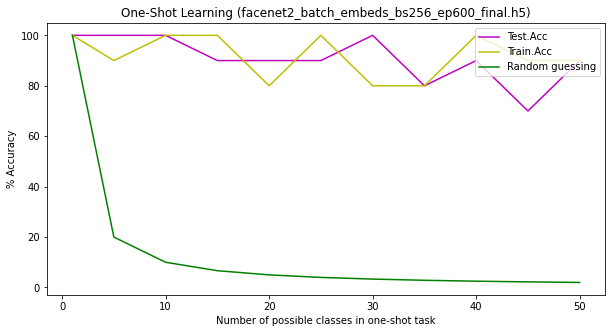

test 8 - model: face_recognition_batch_embeds_bs256_ep600_nway_best.h5
[[0.54536885]] 0 0
[[0.5647785]] 0 0
[[0.5585443]] 0 0
[[0.5486364]] 0 0
[[0.52837867]] 0 0
[[0.52868545]] 0 0
[[0.53619075]] 0 0
[[0.54726946]] 0 0
[[0.55215913]] 0 0
[[0.5304304]] 0 0
[[0.5482675]] 0 0
[[0.5271578]] 0 0
[[0.5346451]] 0 0
[[0.54524785]] 0 0
[[0.5260351]] 0 0
[[0.5394471]] 0 0
[[0.55500364]] 0 0
[[0.5583133]] 0 0
[[0.5582351]] 0 0
[[0.56367314]] 0 0
[[0.49979517]
 [0.51350135]
 [0.4966533 ]
 [0.5304256 ]
 [0.49005967]] 3 3
[[0.49832335]
 [0.48920766]
 [0.50723773]
 [0.54035854]
 [0.49809593]] 3 3
[[0.4894656 ]
 [0.5019603 ]
 [0.50127524]
 [0.55969393]
 [0.4861563 ]] 3 3
[[0.4972877 ]
 [0.4948306 ]
 [0.53795135]
 [0.48672646]
 [0.48391208]] 2 2
[[0.5391392 ]
 [0.5062897 ]
 [0.49699607]
 [0.50439423]
 [0.49515623]] 0 0
[[0.51002383]
 [0.4997694 ]
 [0.49868205]
 [0.58152175]
 [0.4929673 ]] 3 3
[[0.46842837]
 [0.47088784]
 [0.55878115]
 [0.46852604]
 [0.4951555 ]] 2 2
[[0.5449561 ]
 [0.5050793 ]
 [0.497

[[0.47260588]
 [0.500593  ]
 [0.5025268 ]
 [0.48388246]
 [0.46360397]
 [0.492338  ]
 [0.4831481 ]
 [0.50751513]
 [0.49970835]
 [0.48392758]
 [0.48491195]
 [0.48730513]
 [0.47665432]
 [0.48197517]
 [0.5079413 ]] 14 14
[[0.50092274]
 [0.5050786 ]
 [0.49788755]
 [0.49176875]
 [0.51024663]
 [0.4803901 ]
 [0.48219794]
 [0.5155918 ]
 [0.5269085 ]
 [0.4779923 ]
 [0.5833074 ]
 [0.50920576]
 [0.49192512]
 [0.4982071 ]
 [0.47395685]] 10 10
[[0.51871955]
 [0.49400753]
 [0.49125686]
 [0.48401868]
 [0.5051769 ]
 [0.49311203]
 [0.5043668 ]
 [0.50644684]
 [0.505669  ]
 [0.49937814]
 [0.51227844]
 [0.48867217]
 [0.5025284 ]
 [0.4981284 ]
 [0.5076213 ]] 0 10
[[0.5664797 ]
 [0.495735  ]
 [0.51577425]
 [0.5057754 ]
 [0.5058216 ]
 [0.49155915]
 [0.48137784]
 [0.50298536]
 [0.4931921 ]
 [0.49202645]
 [0.48159352]
 [0.4931354 ]
 [0.5069387 ]
 [0.5064212 ]
 [0.48213837]] 0 0
[[0.50405234]
 [0.48982355]
 [0.47702906]
 [0.4883992 ]
 [0.48624355]
 [0.48414466]
 [0.47151038]
 [0.4863348 ]
 [0.49757853]
 [0.50745

[[0.50843894]
 [0.55991817]
 [0.49934423]
 [0.4952042 ]
 [0.48201838]
 [0.49295312]
 [0.48379374]
 [0.49752906]
 [0.4857338 ]
 [0.5199845 ]
 [0.4927762 ]
 [0.51045704]
 [0.47262308]
 [0.49992967]
 [0.49311665]
 [0.48962367]
 [0.49516848]
 [0.488409  ]
 [0.48844758]
 [0.48235098]
 [0.47594878]
 [0.5001673 ]
 [0.5218543 ]
 [0.50967413]
 [0.4981244 ]] 1 1
[[0.5045141 ]
 [0.49937066]
 [0.50633186]
 [0.5003184 ]
 [0.48906273]
 [0.5039982 ]
 [0.49972984]
 [0.48396444]
 [0.50854886]
 [0.5105956 ]
 [0.49286658]
 [0.48896646]
 [0.56367314]
 [0.51891166]
 [0.48872948]
 [0.5026953 ]
 [0.50644684]
 [0.4899612 ]
 [0.5125221 ]
 [0.50711256]
 [0.48963225]
 [0.51578397]
 [0.49190652]
 [0.48092926]
 [0.48069915]] 12 12
[[0.50543   ]
 [0.4990446 ]
 [0.5076335 ]
 [0.49742812]
 [0.48412502]
 [0.48757792]
 [0.4632127 ]
 [0.52139896]
 [0.48669702]
 [0.51649475]
 [0.4784766 ]
 [0.5156473 ]
 [0.4983213 ]
 [0.50473124]
 [0.48335508]
 [0.47622508]
 [0.48974356]
 [0.51777977]
 [0.5302732 ]
 [0.47559294]
 [0.4995

[[0.49261233]
 [0.48967874]
 [0.5170063 ]
 [0.51393294]
 [0.49462757]
 [0.5034514 ]
 [0.49081317]
 [0.50023186]
 [0.5416313 ]
 [0.503557  ]
 [0.5065897 ]
 [0.5024129 ]
 [0.49901676]
 [0.4876398 ]
 [0.50524354]
 [0.5165811 ]
 [0.50113523]
 [0.47922385]
 [0.49522337]
 [0.49864808]
 [0.51663035]
 [0.52230823]
 [0.51399493]
 [0.49420616]
 [0.4937955 ]
 [0.51630807]
 [0.49358782]
 [0.4980669 ]
 [0.5156748 ]
 [0.50406235]] 8 8
[[0.51275605]
 [0.495735  ]
 [0.49300644]
 [0.4970188 ]
 [0.5260351 ]
 [0.50781703]
 [0.50433326]
 [0.47842875]
 [0.49336082]
 [0.48596513]
 [0.48595056]
 [0.47303697]
 [0.486559  ]
 [0.49596813]
 [0.5109251 ]
 [0.5026203 ]
 [0.51216817]
 [0.50452775]
 [0.5210881 ]
 [0.48560107]
 [0.46621007]
 [0.49548873]
 [0.49546206]
 [0.47152904]
 [0.48547083]
 [0.48934636]
 [0.4827049 ]
 [0.49189374]
 [0.48253974]
 [0.49011227]] 4 4
[[0.5031413 ]
 [0.48995078]
 [0.48833957]
 [0.4852496 ]
 [0.4811123 ]
 [0.49717322]
 [0.48324972]
 [0.4819295 ]
 [0.48417085]
 [0.48343685]
 [0.494193

[[0.4760791 ]
 [0.4970436 ]
 [0.4923717 ]
 [0.48663706]
 [0.49918094]
 [0.4858434 ]
 [0.5202386 ]
 [0.48547396]
 [0.5187726 ]
 [0.50016236]
 [0.48162192]
 [0.4916232 ]
 [0.4902726 ]
 [0.47603983]
 [0.4966251 ]
 [0.49514312]
 [0.4879443 ]
 [0.49620193]
 [0.49663016]
 [0.49752343]
 [0.4851803 ]
 [0.55960155]
 [0.46888077]
 [0.48040092]
 [0.4869967 ]
 [0.49019155]
 [0.49499044]
 [0.4879386 ]
 [0.50447243]
 [0.482786  ]
 [0.5112592 ]
 [0.4783399 ]
 [0.48792234]
 [0.5002131 ]
 [0.4680105 ]] 21 21
[[0.49151763]
 [0.4877608 ]
 [0.50132823]
 [0.49627253]
 [0.46024874]
 [0.47890824]
 [0.5445876 ]
 [0.48612225]
 [0.4895139 ]
 [0.49937594]
 [0.48346817]
 [0.4823143 ]
 [0.47462243]
 [0.48805428]
 [0.47592676]
 [0.4872791 ]
 [0.5045382 ]
 [0.47673428]
 [0.49382582]
 [0.49675664]
 [0.49097258]
 [0.51191247]
 [0.49356306]
 [0.4908309 ]
 [0.51859796]
 [0.47863495]
 [0.48597938]
 [0.49013302]
 [0.49909696]
 [0.47350326]
 [0.5049842 ]
 [0.49140376]
 [0.50359523]
 [0.49130934]
 [0.4926353 ]] 6 6
[[0.4687

[[0.5138557 ]
 [0.4937102 ]
 [0.49927092]
 [0.49300268]
 [0.49385646]
 [0.48833957]
 [0.51053417]
 [0.49490926]
 [0.48446193]
 [0.49295682]
 [0.5137359 ]
 [0.5009323 ]
 [0.48664638]
 [0.49839202]
 [0.48778582]
 [0.51144665]
 [0.5156852 ]
 [0.50279856]
 [0.49599418]
 [0.47894835]
 [0.48666027]
 [0.46870288]
 [0.50104   ]
 [0.49240455]
 [0.4876041 ]
 [0.48998147]
 [0.49125415]
 [0.4986867 ]
 [0.5029454 ]
 [0.49473208]
 [0.49420613]
 [0.4801104 ]
 [0.4929908 ]
 [0.499699  ]
 [0.55196923]
 [0.48634508]
 [0.49773288]
 [0.49287587]
 [0.48767743]
 [0.5029166 ]] 34 34
[[0.51115483]
 [0.49390996]
 [0.4813053 ]
 [0.50654453]
 [0.4789749 ]
 [0.4890422 ]
 [0.49817908]
 [0.49779132]
 [0.49262118]
 [0.50411564]
 [0.50924104]
 [0.48405424]
 [0.47713438]
 [0.48409095]
 [0.48533973]
 [0.49856105]
 [0.5496886 ]
 [0.5054226 ]
 [0.48822656]
 [0.49919614]
 [0.4845831 ]
 [0.5066551 ]
 [0.49531096]
 [0.48219174]
 [0.5079075 ]
 [0.49596813]
 [0.50096345]
 [0.5026241 ]
 [0.47676405]
 [0.5057706 ]
 [0.5113702 ]

[[0.49496064]
 [0.49411434]
 [0.48721892]
 [0.49176717]
 [0.5160261 ]
 [0.512131  ]
 [0.5672754 ]
 [0.48799625]
 [0.47979718]
 [0.49108344]
 [0.48616582]
 [0.47748333]
 [0.49161676]
 [0.4924109 ]
 [0.47817022]
 [0.49232432]
 [0.49985102]
 [0.51359624]
 [0.48348758]
 [0.48945212]
 [0.5024728 ]
 [0.49010813]
 [0.4836271 ]
 [0.5167104 ]
 [0.49466264]
 [0.48452798]
 [0.5025577 ]
 [0.5056121 ]
 [0.5018607 ]
 [0.5018862 ]
 [0.5055756 ]
 [0.50207007]
 [0.5173636 ]
 [0.5182916 ]
 [0.48265025]
 [0.4951561 ]
 [0.47555158]
 [0.47421873]
 [0.5002519 ]
 [0.4794724 ]
 [0.51000184]
 [0.5122533 ]
 [0.51542234]
 [0.48365495]
 [0.49321872]] 6 6
[[0.5018385 ]
 [0.4998961 ]
 [0.49581665]
 [0.5654681 ]
 [0.50585794]
 [0.49936482]
 [0.5116731 ]
 [0.49266857]
 [0.4931738 ]
 [0.5216108 ]
 [0.49572444]
 [0.48336637]
 [0.4854148 ]
 [0.48496363]
 [0.4940043 ]
 [0.49033108]
 [0.48294538]
 [0.49480352]
 [0.4767165 ]
 [0.5007298 ]
 [0.49455938]
 [0.49530095]
 [0.47340474]
 [0.50043577]
 [0.50371736]
 [0.47536075]
 

[[0.47987723]
 [0.48041004]
 [0.45756716]
 [0.4810766 ]
 [0.49526164]
 [0.49038586]
 [0.48540035]
 [0.48927405]
 [0.49136716]
 [0.5099548 ]
 [0.50248164]
 [0.4918191 ]
 [0.4905992 ]
 [0.4980047 ]
 [0.49859136]
 [0.50224715]
 [0.49756986]
 [0.48435876]
 [0.48161536]
 [0.50141996]
 [0.49321195]
 [0.5048686 ]
 [0.48826528]
 [0.4926983 ]
 [0.491089  ]
 [0.5134889 ]
 [0.49522576]
 [0.488966  ]
 [0.5044573 ]
 [0.49408466]
 [0.4858449 ]
 [0.49323094]
 [0.50085086]
 [0.4847583 ]
 [0.4899905 ]
 [0.49069265]
 [0.50267714]
 [0.5036559 ]
 [0.50361896]
 [0.561394  ]
 [0.5037539 ]
 [0.4849161 ]
 [0.5205621 ]
 [0.48343045]
 [0.4819837 ]] 39 39
[[0.5048602 ]
 [0.5131775 ]
 [0.48558983]
 [0.5048919 ]
 [0.49628857]
 [0.5126409 ]
 [0.507505  ]
 [0.5066743 ]
 [0.49588123]
 [0.5042405 ]
 [0.49276227]
 [0.49511948]
 [0.5109734 ]
 [0.5045394 ]
 [0.5207567 ]
 [0.5094799 ]
 [0.48856324]
 [0.5111328 ]
 [0.5062573 ]
 [0.49856997]
 [0.48820654]
 [0.5034346 ]
 [0.50497216]
 [0.4868415 ]
 [0.52341694]
 [0.5081032 ]

[[0.48176673]
 [0.48173553]
 [0.4916386 ]
 [0.47481626]
 [0.5006311 ]
 [0.4787612 ]
 [0.5010061 ]
 [0.4934757 ]
 [0.49009603]
 [0.49473116]
 [0.48594543]
 [0.49673313]
 [0.5083534 ]
 [0.5147374 ]
 [0.49889225]
 [0.48194745]
 [0.49248287]
 [0.49844685]
 [0.4934078 ]
 [0.49928826]
 [0.5093694 ]
 [0.4949067 ]
 [0.48499787]
 [0.49201202]
 [0.50675166]
 [0.4773992 ]
 [0.50465626]
 [0.491141  ]
 [0.48134592]
 [0.47960365]
 [0.485828  ]
 [0.4965964 ]
 [0.4987243 ]
 [0.49641067]
 [0.46232605]
 [0.49168283]
 [0.4949635 ]
 [0.50685555]
 [0.488192  ]
 [0.48791578]
 [0.47670466]
 [0.4939875 ]
 [0.4964479 ]
 [0.4964035 ]
 [0.4826243 ]
 [0.49065664]
 [0.47777665]
 [0.5015721 ]
 [0.48050416]
 [0.47578758]] 13 20
[[0.47985858]
 [0.4804051 ]
 [0.49099824]
 [0.48980644]
 [0.49453983]
 [0.4824608 ]
 [0.50718635]
 [0.50296503]
 [0.55444205]
 [0.49177223]
 [0.5129542 ]
 [0.48710972]
 [0.49026158]
 [0.50514776]
 [0.48188314]
 [0.48560658]
 [0.49424753]
 [0.4733089 ]
 [0.49870637]
 [0.50574774]
 [0.49125236]

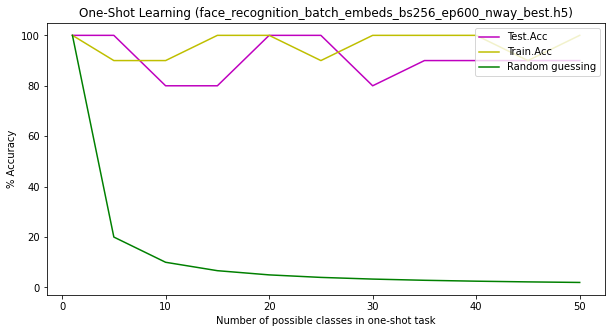

test 9 - model: facenet2_epoch_embeds_bs256_ep600_nway_best.h5
[[0.5075992]] 0 0
[[0.5995957]] 0 0
[[0.46660626]] 0 0
[[0.5886976]] 0 0
[[0.48894066]] 0 0
[[0.5516173]] 0 0
[[0.49643797]] 0 0
[[0.6925147]] 0 0
[[0.53016007]] 0 0
[[0.43538943]] 0 0
[[0.5022949]] 0 0
[[0.7327058]] 0 0
[[0.44483173]] 0 0
[[0.68177193]] 0 0
[[0.5553988]] 0 0
[[0.6771404]] 0 0
[[0.57242334]] 0 0
[[0.42613885]] 0 0
[[0.724351]] 0 0
[[0.6494182]] 0 0
[[0.44519588]
 [0.42611462]
 [0.69672257]
 [0.41171253]
 [0.4390871 ]] 2 2
[[0.40120125]
 [0.44651857]
 [0.4500812 ]
 [0.68436915]
 [0.4126833 ]] 3 3
[[0.60563755]
 [0.40815437]
 [0.3763141 ]
 [0.43662703]
 [0.4226167 ]] 0 0
[[0.41645682]
 [0.4415466 ]
 [0.3792681 ]
 [0.38038146]
 [0.4573986 ]] 4 4
[[0.4009098 ]
 [0.39096445]
 [0.4282627 ]
 [0.6921149 ]
 [0.3970157 ]] 3 3
[[0.38345778]
 [0.40099698]
 [0.4065448 ]
 [0.44852257]
 [0.3924813 ]] 3 3
[[0.38349754]
 [0.386335  ]
 [0.39298388]
 [0.5804701 ]
 [0.37178114]] 3 3
[[0.4182642 ]
 [0.41521534]
 [0.41469944]
 [

[[0.4048096 ]
 [0.41890538]
 [0.46814942]
 [0.40821606]
 [0.48809528]
 [0.42859396]
 [0.4276805 ]
 [0.43190938]
 [0.3757814 ]
 [0.4293482 ]
 [0.39357665]
 [0.402523  ]
 [0.406673  ]
 [0.41573754]
 [0.3980629 ]
 [0.39259106]
 [0.41231647]
 [0.4374772 ]
 [0.4392567 ]
 [0.4334457 ]] 4 4
[[0.39207226]
 [0.38182122]
 [0.39953738]
 [0.64326537]
 [0.38112003]
 [0.46026018]
 [0.39617643]
 [0.40198755]
 [0.423796  ]
 [0.40695193]
 [0.39618468]
 [0.3976756 ]
 [0.3842481 ]
 [0.40870345]
 [0.39288113]
 [0.43313813]
 [0.4341287 ]
 [0.39987278]
 [0.3929086 ]
 [0.3869483 ]] 3 3
[[0.4140035 ]
 [0.4245618 ]
 [0.44380772]
 [0.397127  ]
 [0.39733014]
 [0.42289367]
 [0.4241028 ]
 [0.4418503 ]
 [0.40369022]
 [0.39322644]
 [0.45447114]
 [0.43982902]
 [0.6332525 ]
 [0.4422969 ]
 [0.4120283 ]
 [0.41815662]
 [0.45576906]
 [0.45021695]
 [0.44963527]
 [0.41298681]] 12 12
[[0.4519067 ]
 [0.4207397 ]
 [0.41340107]
 [0.4668152 ]
 [0.44042072]
 [0.61878794]
 [0.39673924]
 [0.42200923]
 [0.51926315]
 [0.4412354 ]
 [0

[[0.39348722]
 [0.40144   ]
 [0.39565998]
 [0.42332327]
 [0.36727202]
 [0.43117464]
 [0.3884697 ]
 [0.590246  ]
 [0.37343454]
 [0.40790322]
 [0.42259678]
 [0.40927583]
 [0.3949817 ]
 [0.41560745]
 [0.39079434]
 [0.41310316]
 [0.43396315]
 [0.38869274]
 [0.38849622]
 [0.41252112]
 [0.41679955]
 [0.3823368 ]
 [0.4164212 ]
 [0.4192555 ]
 [0.39726493]] 7 7
[[0.40268904]
 [0.38578632]
 [0.41305324]
 [0.4236004 ]
 [0.43754667]
 [0.45105162]
 [0.4042824 ]
 [0.37541768]
 [0.3955385 ]
 [0.41479748]
 [0.38590223]
 [0.3782451 ]
 [0.37910825]
 [0.41054392]
 [0.3893371 ]
 [0.4051238 ]
 [0.39556146]
 [0.380839  ]
 [0.415869  ]
 [0.38677353]
 [0.39623493]
 [0.41139823]
 [0.3985327 ]
 [0.57242334]
 [0.4355511 ]] 23 23
[[0.39785683]
 [0.40437043]
 [0.45869997]
 [0.375981  ]
 [0.40785915]
 [0.38847587]
 [0.40845296]
 [0.42330784]
 [0.48570266]
 [0.39162454]
 [0.3680377 ]
 [0.39054838]
 [0.3891216 ]
 [0.44121256]
 [0.3860878 ]
 [0.40288204]
 [0.42782825]
 [0.40703115]
 [0.4384135 ]
 [0.39707077]
 [0.3982

[[0.39564303]
 [0.40148473]
 [0.40468085]
 [0.41653976]
 [0.40165907]
 [0.38278067]
 [0.40917343]
 [0.38001195]
 [0.41060486]
 [0.41808355]
 [0.38093483]
 [0.39848042]
 [0.45691317]
 [0.3820381 ]
 [0.401493  ]
 [0.44233635]
 [0.40197235]
 [0.3854488 ]
 [0.36535925]
 [0.45191807]
 [0.42480662]
 [0.41073328]
 [0.67083013]
 [0.43410334]
 [0.40926945]
 [0.42090055]
 [0.39599502]
 [0.43976265]
 [0.39875886]
 [0.41305822]] 22 22
[[0.41312116]
 [0.3950409 ]
 [0.41862735]
 [0.3733489 ]
 [0.42390037]
 [0.41469377]
 [0.40215477]
 [0.3787547 ]
 [0.41130185]
 [0.3919534 ]
 [0.3791361 ]
 [0.39820588]
 [0.3992037 ]
 [0.41504845]
 [0.3972009 ]
 [0.3985592 ]
 [0.40805176]
 [0.39417267]
 [0.40598232]
 [0.4013829 ]
 [0.41237476]
 [0.38938507]
 [0.4140644 ]
 [0.38205722]
 [0.41190878]
 [0.6724818 ]
 [0.4087994 ]
 [0.37171736]
 [0.395876  ]
 [0.42243809]] 25 25
[[0.3985085 ]
 [0.42359522]
 [0.38922033]
 [0.4297693 ]
 [0.39805692]
 [0.38055766]
 [0.38409427]
 [0.39304712]
 [0.41209128]
 [0.4473532 ]
 [0.50

[[0.43194112]
 [0.44958028]
 [0.39781475]
 [0.3833194 ]
 [0.41908526]
 [0.39247543]
 [0.3890267 ]
 [0.38907835]
 [0.40773588]
 [0.41165137]
 [0.43606403]
 [0.38873035]
 [0.39551467]
 [0.39867017]
 [0.39343488]
 [0.37711024]
 [0.50473315]
 [0.37219012]
 [0.3717888 ]
 [0.404584  ]
 [0.4038648 ]
 [0.4458353 ]
 [0.42777923]
 [0.42865542]
 [0.38132402]
 [0.42074782]
 [0.42998853]
 [0.38185298]
 [0.429395  ]
 [0.40044773]
 [0.3940732 ]
 [0.40850946]
 [0.36141455]
 [0.40352592]
 [0.4188273 ]] 16 16
[[0.4238442 ]
 [0.39535624]
 [0.3912097 ]
 [0.3959873 ]
 [0.42816132]
 [0.39813235]
 [0.40216404]
 [0.3915562 ]
 [0.4214863 ]
 [0.39594656]
 [0.3875322 ]
 [0.42219758]
 [0.3943432 ]
 [0.38981003]
 [0.3874895 ]
 [0.42981464]
 [0.40624505]
 [0.40036792]
 [0.40595078]
 [0.40692213]
 [0.39018786]
 [0.39880088]
 [0.41477776]
 [0.37609893]
 [0.40251693]
 [0.4200036 ]
 [0.41998777]
 [0.40082553]
 [0.42118818]
 [0.39342114]
 [0.40164223]
 [0.41085577]
 [0.44791982]
 [0.38279748]
 [0.39186242]
 [0.405347  ]

[[0.4462996 ]
 [0.41299155]
 [0.3963203 ]
 [0.3983571 ]
 [0.3981339 ]
 [0.42144018]
 [0.40829998]
 [0.38983935]
 [0.41704214]
 [0.41493398]
 [0.39353856]
 [0.42710435]
 [0.41043654]
 [0.43676132]
 [0.42010242]
 [0.4209789 ]
 [0.40757895]
 [0.45869997]
 [0.39309877]
 [0.42564517]
 [0.4161614 ]
 [0.42834067]
 [0.4008871 ]
 [0.41260603]
 [0.39512217]
 [0.4022522 ]
 [0.39804357]
 [0.42842558]
 [0.4104532 ]
 [0.4127008 ]
 [0.4368898 ]
 [0.4088179 ]
 [0.40499258]
 [0.46742916]
 [0.37583837]
 [0.59966016]
 [0.4424697 ]
 [0.40548047]
 [0.40240914]
 [0.3996637 ]] 35 35
[[0.39936543]
 [0.4348739 ]
 [0.40231264]
 [0.42136848]
 [0.38113075]
 [0.44493857]
 [0.4392143 ]
 [0.39529502]
 [0.42857394]
 [0.41245842]
 [0.41231054]
 [0.4125932 ]
 [0.43971145]
 [0.41293648]
 [0.38382208]
 [0.40070847]
 [0.46637255]
 [0.42245457]
 [0.4193068 ]
 [0.39591298]
 [0.40605265]
 [0.41366196]
 [0.4137774 ]
 [0.43490538]
 [0.4056003 ]
 [0.3751987 ]
 [0.43136796]
 [0.4088869 ]
 [0.40699196]
 [0.40878946]
 [0.37004572]

[[0.40176752]
 [0.40604204]
 [0.4178848 ]
 [0.413651  ]
 [0.42669484]
 [0.39606202]
 [0.41021302]
 [0.4113743 ]
 [0.4140679 ]
 [0.41091937]
 [0.4686338 ]
 [0.4127674 ]
 [0.42738092]
 [0.40575776]
 [0.39484933]
 [0.40346533]
 [0.44578794]
 [0.407915  ]
 [0.6178596 ]
 [0.4158259 ]
 [0.39471817]
 [0.39228478]
 [0.39765495]
 [0.41993156]
 [0.47792494]
 [0.41193923]
 [0.4113667 ]
 [0.40200448]
 [0.41045418]
 [0.41772845]
 [0.39936674]
 [0.42448393]
 [0.40525445]
 [0.4339349 ]
 [0.4027144 ]
 [0.50987613]
 [0.4185648 ]
 [0.37312645]
 [0.4370426 ]
 [0.3898412 ]
 [0.391624  ]
 [0.39197087]
 [0.40029228]
 [0.4873427 ]
 [0.4467607 ]] 18 18
[[0.38428983]
 [0.37533224]
 [0.38102633]
 [0.39493254]
 [0.37883794]
 [0.4060833 ]
 [0.37114632]
 [0.41721368]
 [0.3887534 ]
 [0.38036093]
 [0.38731584]
 [0.3963091 ]
 [0.37364596]
 [0.40563396]
 [0.41060743]
 [0.40649998]
 [0.47485653]
 [0.36733505]
 [0.3974638 ]
 [0.40804142]
 [0.47901666]
 [0.39991874]
 [0.3582639 ]
 [0.3746081 ]
 [0.37435967]
 [0.39096448]

[[0.40637195]
 [0.39667314]
 [0.41522482]
 [0.40978646]
 [0.38339937]
 [0.39561063]
 [0.39193395]
 [0.39456493]
 [0.4031917 ]
 [0.42428792]
 [0.40645078]
 [0.4001657 ]
 [0.41308177]
 [0.40386033]
 [0.39303112]
 [0.3912198 ]
 [0.40081924]
 [0.41169816]
 [0.40965477]
 [0.40621167]
 [0.40093976]
 [0.41605407]
 [0.43530974]
 [0.49855363]
 [0.40488726]
 [0.4075693 ]
 [0.3790586 ]
 [0.40880787]
 [0.44880962]
 [0.4331215 ]
 [0.3885432 ]
 [0.38995144]
 [0.38013285]
 [0.40850842]
 [0.42894334]
 [0.40344256]
 [0.39723605]
 [0.39184836]
 [0.38367432]
 [0.3797006 ]
 [0.42395183]
 [0.44028893]
 [0.47385257]
 [0.3945424 ]
 [0.40153253]
 [0.3868494 ]
 [0.39666405]
 [0.40775976]
 [0.3873389 ]
 [0.39077246]] 23 23
[[0.37947962]
 [0.38961795]
 [0.4128526 ]
 [0.38174397]
 [0.39489377]
 [0.38421497]
 [0.39744246]
 [0.3884466 ]
 [0.41286573]
 [0.40341666]
 [0.45209372]
 [0.39658803]
 [0.3991189 ]
 [0.4108222 ]
 [0.3883903 ]
 [0.40063292]
 [0.414725  ]
 [0.41025198]
 [0.41137192]
 [0.42064404]
 [0.38249737]

[[0.41429707]
 [0.43350223]
 [0.42735785]
 [0.41268653]
 [0.40842155]
 [0.39765337]
 [0.40190426]
 [0.43423045]
 [0.40465066]
 [0.3978662 ]
 [0.38899612]
 [0.4081031 ]
 [0.43536392]
 [0.39176285]
 [0.3906684 ]
 [0.415902  ]
 [0.40137684]
 [0.42345002]
 [0.43695524]
 [0.44460422]
 [0.406883  ]
 [0.3873855 ]
 [0.41876304]
 [0.3889019 ]
 [0.42679387]
 [0.43396443]
 [0.3737045 ]
 [0.38916498]
 [0.42666644]
 [0.40281287]
 [0.38109997]
 [0.42021936]
 [0.42502195]
 [0.43197268]
 [0.406229  ]
 [0.4164166 ]
 [0.40873158]
 [0.41736296]
 [0.3983481 ]
 [0.40883917]
 [0.3968541 ]
 [0.39052376]
 [0.400167  ]
 [0.7063953 ]
 [0.37786967]
 [0.40536305]
 [0.4161436 ]
 [0.3981509 ]
 [0.392358  ]
 [0.38678712]] 43 43
[[0.42704308]
 [0.39893046]
 [0.4195097 ]
 [0.46447712]
 [0.3796671 ]
 [0.39405686]
 [0.40440658]
 [0.40885124]
 [0.37273765]
 [0.3832658 ]
 [0.42956996]
 [0.4392503 ]
 [0.39327776]
 [0.3924363 ]
 [0.4038648 ]
 [0.38907835]
 [0.41165137]
 [0.4003917 ]
 [0.50473315]
 [0.4265328 ]
 [0.4160144 ]

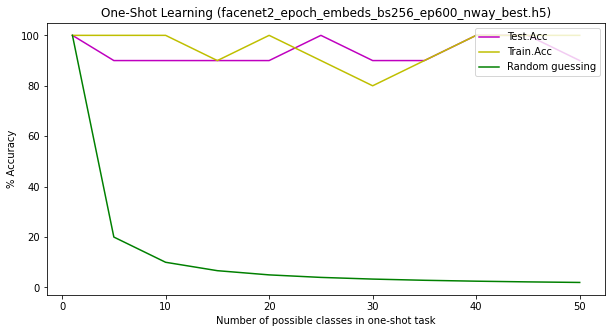

test 10 - model: facenet1_epoch_embeds_bs256_ep600_final.h5
[[0.69975054]] 0 0
[[0.9219971]] 0 0
[[0.9379573]] 0 0
[[0.84512043]] 0 0
[[0.72724265]] 0 0
[[0.88080955]] 0 0
[[0.87665725]] 0 0
[[0.59629846]] 0 0
[[0.33017778]] 0 0
[[0.76370615]] 0 0
[[0.92231774]] 0 0
[[0.9389297]] 0 0
[[0.93784404]] 0 0
[[0.94450223]] 0 0
[[0.8667497]] 0 0
[[0.9343145]] 0 0
[[0.86402535]] 0 0
[[0.887859]] 0 0
[[0.6031855]] 0 0
[[0.66207844]] 0 0
[[0.15553969]
 [0.13433512]
 [0.27317986]
 [0.9456591 ]
 [0.24582508]] 3 3
[[0.5825979 ]
 [0.27727878]
 [0.41628313]
 [0.2848413 ]
 [0.16529825]] 0 0
[[0.18580744]
 [0.86268556]
 [0.11039796]
 [0.14298506]
 [0.24392131]] 1 1
[[0.2723354 ]
 [0.74942553]
 [0.21200417]
 [0.15701343]
 [0.22187223]] 1 1
[[0.67600304]
 [0.1709332 ]
 [0.20441018]
 [0.16686156]
 [0.19000031]] 0 0
[[0.17392515]
 [0.22452939]
 [0.17639755]
 [0.17082186]
 [0.23999026]] 4 4
[[0.17591093]
 [0.2858158 ]
 [0.16788585]
 [0.29791266]
 [0.17238869]] 3 1
[[0.8684059 ]
 [0.16942263]
 [0.14414635]
 

[[0.9317921 ]
 [0.20090967]
 [0.13944712]
 [0.25282347]
 [0.16091561]
 [0.20785233]
 [0.24742305]
 [0.19118485]
 [0.18278922]
 [0.3488379 ]
 [0.16278426]
 [0.17004335]
 [0.1269098 ]
 [0.2222031 ]
 [0.1802962 ]] 0 0
[[0.15863687]
 [0.17293239]
 [0.28350052]
 [0.30790287]
 [0.1984644 ]
 [0.24592051]
 [0.12797529]
 [0.18673092]
 [0.1280737 ]
 [0.18907826]
 [0.20325889]
 [0.15282284]
 [0.18293083]
 [0.26460317]
 [0.19530053]] 3 12
[[0.3427477 ]
 [0.38454127]
 [0.26322103]
 [0.27962863]
 [0.18205202]
 [0.213301  ]
 [0.17988312]
 [0.22324157]
 [0.17698519]
 [0.5834692 ]
 [0.33873045]
 [0.18903735]
 [0.36489427]
 [0.24910979]
 [0.24287839]] 9 9
[[0.14886963]
 [0.6514599 ]
 [0.19189104]
 [0.29882818]
 [0.24183542]
 [0.30599755]
 [0.26632908]
 [0.8131338 ]
 [0.3034918 ]
 [0.5507876 ]
 [0.25167286]
 [0.3356369 ]
 [0.16156122]
 [0.22337402]
 [0.23100464]] 7 7
[[0.27191254]
 [0.16561136]
 [0.13701457]
 [0.17761585]
 [0.20430154]
 [0.20936286]
 [0.1685853 ]
 [0.17643979]
 [0.27115744]
 [0.16467187]

[[0.17813471]
 [0.1592553 ]
 [0.2459639 ]
 [0.2928688 ]
 [0.17372397]
 [0.26632917]
 [0.26933643]
 [0.18279687]
 [0.35776067]
 [0.5337653 ]
 [0.22200626]
 [0.199884  ]
 [0.15391126]
 [0.86729825]
 [0.15205193]
 [0.3122086 ]
 [0.21668282]
 [0.3716851 ]
 [0.16194901]
 [0.19731256]
 [0.19008473]
 [0.23077857]
 [0.24363849]
 [0.2797868 ]
 [0.1689373 ]] 13 13
[[0.22102416]
 [0.22911784]
 [0.1940001 ]
 [0.21671754]
 [0.23038933]
 [0.20498163]
 [0.39060098]
 [0.1692043 ]
 [0.23749605]
 [0.17748705]
 [0.24941856]
 [0.29195786]
 [0.21399745]
 [0.16459453]
 [0.18417153]
 [0.17147613]
 [0.20797616]
 [0.20300347]
 [0.19501725]
 [0.16654241]
 [0.23176908]
 [0.75828344]
 [0.29587245]
 [0.2540239 ]
 [0.29848891]] 21 21
[[0.16148424]
 [0.23756358]
 [0.177746  ]
 [0.14925024]
 [0.27710158]
 [0.14864787]
 [0.36374983]
 [0.13214591]
 [0.2023403 ]
 [0.15371802]
 [0.1800113 ]
 [0.4050992 ]
 [0.2023015 ]
 [0.18300962]
 [0.18852347]
 [0.22238225]
 [0.14250556]
 [0.13396749]
 [0.1806083 ]
 [0.9031602 ]
 [0.17

[[0.19350657]
 [0.16830179]
 [0.26214576]
 [0.24758726]
 [0.1194033 ]
 [0.24525073]
 [0.17462006]
 [0.1869759 ]
 [0.1737158 ]
 [0.23444909]
 [0.14789745]
 [0.17609158]
 [0.17536888]
 [0.28203577]
 [0.22537273]
 [0.21296498]
 [0.25628474]
 [0.20135248]
 [0.16233647]
 [0.85191786]
 [0.33194482]
 [0.17802373]
 [0.15566495]
 [0.24014935]
 [0.19613074]
 [0.14830679]
 [0.23746699]
 [0.20033097]
 [0.23510067]
 [0.1435843 ]] 19 19
[[0.2187782 ]
 [0.18995962]
 [0.22681853]
 [0.40667918]
 [0.21721604]
 [0.26587534]
 [0.2052682 ]
 [0.33513734]
 [0.33705845]
 [0.2204918 ]
 [0.21297988]
 [0.19418722]
 [0.23688912]
 [0.35375637]
 [0.23133439]
 [0.28712553]
 [0.35274774]
 [0.17674887]
 [0.16928443]
 [0.1539748 ]
 [0.36289236]
 [0.76930124]
 [0.34316623]
 [0.16924772]
 [0.25537997]
 [0.2409884 ]
 [0.18881789]
 [0.1548815 ]
 [0.38328785]
 [0.17388263]] 21 21
[[0.9317921 ]
 [0.1622212 ]
 [0.29707798]
 [0.22317123]
 [0.16767952]
 [0.1713092 ]
 [0.22184652]
 [0.23889878]
 [0.15338343]
 [0.18413708]
 [0.18

[[0.15428996]
 [0.22646663]
 [0.2223694 ]
 [0.18935212]
 [0.26604193]
 [0.2062695 ]
 [0.17398992]
 [0.18516469]
 [0.19990394]
 [0.16471043]
 [0.14555147]
 [0.21199223]
 [0.17207292]
 [0.26361096]
 [0.18718442]
 [0.20080355]
 [0.18307704]
 [0.31572333]
 [0.15703139]
 [0.27682137]
 [0.19155043]
 [0.95692456]
 [0.19747266]
 [0.21135473]
 [0.24975127]
 [0.22782376]
 [0.2652232 ]
 [0.1922257 ]
 [0.15313798]
 [0.20607004]
 [0.14428642]
 [0.18497601]
 [0.14293218]
 [0.3141296 ]
 [0.1446527 ]] 21 21
[[0.13963535]
 [0.3589294 ]
 [0.14693841]
 [0.21136937]
 [0.19920692]
 [0.2972579 ]
 [0.17536888]
 [0.16060904]
 [0.18696705]
 [0.23642048]
 [0.2297908 ]
 [0.21844605]
 [0.8409912 ]
 [0.20901549]
 [0.13103995]
 [0.12738588]
 [0.19414312]
 [0.16695043]
 [0.14377433]
 [0.17439252]
 [0.19158083]
 [0.2013365 ]
 [0.1588597 ]
 [0.18133   ]
 [0.18660125]
 [0.16185898]
 [0.20470002]
 [0.30170846]
 [0.19068271]
 [0.14991742]
 [0.13683534]
 [0.16255584]
 [0.18191448]
 [0.14297117]
 [0.14500031]] 12 12
[[0.16

[[0.279971  ]
 [0.26763368]
 [0.390612  ]
 [0.21893352]
 [0.19235998]
 [0.40180665]
 [0.24360403]
 [0.22621351]
 [0.4494633 ]
 [0.23433572]
 [0.4179816 ]
 [0.16435614]
 [0.218573  ]
 [0.1546304 ]
 [0.24196312]
 [0.2742254 ]
 [0.22207904]
 [0.31250829]
 [0.20929736]
 [0.18297398]
 [0.23586893]
 [0.23795053]
 [0.6620785 ]
 [0.36768973]
 [0.28414178]
 [0.19426799]
 [0.29692143]
 [0.17476517]
 [0.31911743]
 [0.18620282]
 [0.14246744]
 [0.17737386]
 [0.26419955]
 [0.1714429 ]
 [0.28127718]
 [0.4132283 ]
 [0.4035873 ]
 [0.3080734 ]
 [0.4201011 ]
 [0.39627656]] 22 22
[[0.9488685 ]
 [0.17915294]
 [0.33446383]
 [0.246225  ]
 [0.2799962 ]
 [0.18737036]
 [0.22342587]
 [0.2287325 ]
 [0.43989298]
 [0.26237184]
 [0.19272086]
 [0.2062878 ]
 [0.2570225 ]
 [0.2043145 ]
 [0.21740755]
 [0.35627413]
 [0.1537273 ]
 [0.18618509]
 [0.21784815]
 [0.25242046]
 [0.1446279 ]
 [0.19797567]
 [0.19057849]
 [0.29410386]
 [0.16745728]
 [0.27461427]
 [0.14432865]
 [0.21683565]
 [0.230622  ]
 [0.21083844]
 [0.31936824]

[[0.28031325]
 [0.15805152]
 [0.26403528]
 [0.45967576]
 [0.15220091]
 [0.13764763]
 [0.1840215 ]
 [0.31011546]
 [0.13508675]
 [0.22608909]
 [0.12571445]
 [0.2916032 ]
 [0.16531521]
 [0.3076499 ]
 [0.18512562]
 [0.19715005]
 [0.19965371]
 [0.15135247]
 [0.17224464]
 [0.1779151 ]
 [0.1827803 ]
 [0.14767557]
 [0.19206327]
 [0.18910307]
 [0.22720599]
 [0.18305752]
 [0.12873682]
 [0.17574805]
 [0.18199763]
 [0.19653013]
 [0.17709577]
 [0.2526381 ]
 [0.32334405]
 [0.21626616]
 [0.16449165]
 [0.16700298]
 [0.29731318]
 [0.14006355]
 [0.2109881 ]
 [0.17228544]
 [0.19156687]
 [0.19630054]
 [0.19776072]
 [0.12632637]
 [0.17859395]] 3 3
[[0.17557988]
 [0.3585166 ]
 [0.28748584]
 [0.22844997]
 [0.16752192]
 [0.19633004]
 [0.17893386]
 [0.33984244]
 [0.253413  ]
 [0.31841183]
 [0.2360324 ]
 [0.1919049 ]
 [0.173814  ]
 [0.19226661]
 [0.18138617]
 [0.26760864]
 [0.21663517]
 [0.18763128]
 [0.26117545]
 [0.15610966]
 [0.26507258]
 [0.95432746]
 [0.17911056]
 [0.2559341 ]
 [0.2344479 ]
 [0.1487683 ]
 

[[0.25150117]
 [0.14694247]
 [0.20722374]
 [0.19237134]
 [0.23394474]
 [0.1323052 ]
 [0.14784199]
 [0.14826629]
 [0.20814598]
 [0.12439913]
 [0.17844135]
 [0.217538  ]
 [0.17751837]
 [0.1963428 ]
 [0.18125033]
 [0.17766982]
 [0.14167082]
 [0.15838462]
 [0.22794902]
 [0.18246031]
 [0.15061921]
 [0.20006922]
 [0.18494973]
 [0.16390312]
 [0.24046391]
 [0.1809785 ]
 [0.16717881]
 [0.20945856]
 [0.14647469]
 [0.14942694]
 [0.16860574]
 [0.14245963]
 [0.17880073]
 [0.9181348 ]
 [0.24850023]
 [0.29661292]
 [0.1774182 ]
 [0.31054595]
 [0.14381468]
 [0.16639233]
 [0.2804159 ]
 [0.13304773]
 [0.12834379]
 [0.17881948]
 [0.1835612 ]
 [0.19011939]
 [0.16258809]
 [0.2948528 ]
 [0.23393269]
 [0.18101944]] 33 33
[[0.1485632 ]
 [0.21021527]
 [0.18650961]
 [0.93008584]
 [0.371488  ]
 [0.17613205]
 [0.17417207]
 [0.26332456]
 [0.17323494]
 [0.1740323 ]
 [0.1346479 ]
 [0.16173962]
 [0.15780842]
 [0.20548996]
 [0.1802307 ]
 [0.13977665]
 [0.38262224]
 [0.16500854]
 [0.17818472]
 [0.21139085]
 [0.15080222]

[[0.30272806]
 [0.16743919]
 [0.21110508]
 [0.3061119 ]
 [0.3087337 ]
 [0.44983363]
 [0.20512843]
 [0.27479985]
 [0.28530526]
 [0.1414819 ]
 [0.23657382]
 [0.19304964]
 [0.25130942]
 [0.20304793]
 [0.17330542]
 [0.25807577]
 [0.36582017]
 [0.23459852]
 [0.29471448]
 [0.3882504 ]
 [0.16530704]
 [0.22985172]
 [0.47018704]
 [0.86674964]
 [0.34398076]
 [0.29335684]
 [0.25802147]
 [0.2357713 ]
 [0.25463277]
 [0.20349258]
 [0.1924183 ]
 [0.26816845]
 [0.27196854]
 [0.17879504]
 [0.3198015 ]
 [0.3679248 ]
 [0.22880787]
 [0.31312004]
 [0.35446697]
 [0.19165933]
 [0.25764573]
 [0.18882692]
 [0.15631357]
 [0.22961828]
 [0.2271345 ]
 [0.30548564]
 [0.24568966]
 [0.35034764]
 [0.21719451]
 [0.24718055]] 23 23
[[0.32097697]
 [0.2400251 ]
 [0.20667627]
 [0.16559473]
 [0.30530173]
 [0.7414984 ]
 [0.2789237 ]
 [0.46303383]
 [0.16060743]
 [0.3778559 ]
 [0.20219052]
 [0.17859158]
 [0.17898351]
 [0.3236783 ]
 [0.27063078]
 [0.24118596]
 [0.25594229]
 [0.15043098]
 [0.25957212]
 [0.16361514]
 [0.16483358]

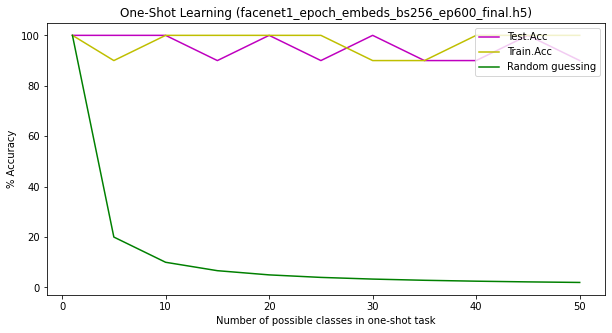

test 11 - model: facenet2_batch_embeds_bs256_ep600_nway_best.h5
[[0.6892628]] 0 0
[[0.6560388]] 0 0
[[0.75738]] 0 0
[[0.6492859]] 0 0
[[0.8139319]] 0 0
[[0.578155]] 0 0
[[0.7085041]] 0 0
[[0.65667677]] 0 0
[[0.6306247]] 0 0
[[0.66294736]] 0 0
[[0.5608113]] 0 0
[[0.726779]] 0 0
[[0.7387115]] 0 0
[[0.56434023]] 0 0
[[0.557618]] 0 0
[[0.7534098]] 0 0
[[0.44164544]] 0 0
[[0.6050976]] 0 0
[[0.6377228]] 0 0
[[0.578569]] 0 0
[[0.42462277]
 [0.39297023]
 [0.4075168 ]
 [0.5414488 ]
 [0.4327889 ]] 3 3
[[0.62352395]
 [0.3852361 ]
 [0.39073965]
 [0.3785537 ]
 [0.3922523 ]] 0 0
[[0.3517568 ]
 [0.5500534 ]
 [0.4049943 ]
 [0.38689336]
 [0.42994398]] 1 1
[[0.4839029 ]
 [0.37293616]
 [0.61028105]
 [0.414208  ]
 [0.3793829 ]] 2 2
[[0.35978872]
 [0.38022602]
 [0.6619422 ]
 [0.38781697]
 [0.37663314]] 2 2
[[0.501407  ]
 [0.3653349 ]
 [0.4045748 ]
 [0.37719643]
 [0.38271558]] 0 0
[[0.41463506]
 [0.4176047 ]
 [0.39023173]
 [0.5288288 ]
 [0.38939905]] 3 3
[[0.37454963]
 [0.6470615 ]
 [0.41065937]
 [0.3914527

[[0.41085985]
 [0.39391303]
 [0.3848626 ]
 [0.39006633]
 [0.40837115]
 [0.39223742]
 [0.4061829 ]
 [0.42955974]
 [0.4068407 ]
 [0.4800833 ]
 [0.38460457]
 [0.4394834 ]
 [0.40596062]
 [0.40646195]
 [0.41464466]
 [0.39111763]
 [0.3840864 ]
 [0.38948116]
 [0.43952248]
 [0.38661706]] 9 11
[[0.37735522]
 [0.3755729 ]
 [0.39615965]
 [0.3895847 ]
 [0.40302533]
 [0.4188609 ]
 [0.41646826]
 [0.39530584]
 [0.37528986]
 [0.44720295]
 [0.36604694]
 [0.42660975]
 [0.397501  ]
 [0.3924217 ]
 [0.3874238 ]
 [0.40014198]
 [0.41360256]
 [0.6892628 ]
 [0.43609527]
 [0.37998503]] 17 17
[[0.37760603]
 [0.39196855]
 [0.3742258 ]
 [0.44998926]
 [0.37965435]
 [0.43914688]
 [0.40814447]
 [0.3851817 ]
 [0.3977663 ]
 [0.4127301 ]
 [0.39717117]
 [0.40495068]
 [0.73638576]
 [0.39821467]
 [0.4197274 ]
 [0.49114895]
 [0.37399635]
 [0.38424614]
 [0.37446147]
 [0.4524966 ]] 12 12
[[0.3967251 ]
 [0.39948887]
 [0.4214922 ]
 [0.43932655]
 [0.4128363 ]
 [0.4186234 ]
 [0.444061  ]
 [0.3796512 ]
 [0.3683655 ]
 [0.40010372]


[[0.41192722]
 [0.40630895]
 [0.35692233]
 [0.4131129 ]
 [0.5447769 ]
 [0.40820605]
 [0.3787778 ]
 [0.39675367]
 [0.40384418]
 [0.41677043]
 [0.3755783 ]
 [0.4163539 ]
 [0.40146664]
 [0.39624828]
 [0.37745452]
 [0.37410453]
 [0.39485735]
 [0.41457596]
 [0.40045813]
 [0.36297494]
 [0.44146934]
 [0.3795119 ]
 [0.3763727 ]
 [0.3747396 ]
 [0.3962395 ]] 4 4
[[0.399017  ]
 [0.4296224 ]
 [0.39765522]
 [0.37645203]
 [0.40370166]
 [0.39553168]
 [0.39854437]
 [0.426192  ]
 [0.3788999 ]
 [0.39891106]
 [0.38390836]
 [0.49868113]
 [0.4251549 ]
 [0.4493846 ]
 [0.40793788]
 [0.4519108 ]
 [0.5964853 ]
 [0.39035538]
 [0.45996684]
 [0.41287673]
 [0.44113785]
 [0.38375592]
 [0.4047541 ]
 [0.39746517]
 [0.42222008]] 16 16
[[0.42001414]
 [0.39588434]
 [0.38456005]
 [0.43566886]
 [0.44052136]
 [0.39099276]
 [0.4237482 ]
 [0.42534816]
 [0.42861992]
 [0.4162286 ]
 [0.43791214]
 [0.3969984 ]
 [0.37653655]
 [0.42782426]
 [0.39858687]
 [0.38412058]
 [0.3985687 ]
 [0.41410455]
 [0.40637603]
 [0.4368734 ]
 [0.7548

[[0.42018908]
 [0.47999614]
 [0.42018893]
 [0.43964925]
 [0.43998426]
 [0.4445172 ]
 [0.46843323]
 [0.49063873]
 [0.4425547 ]
 [0.4142261 ]
 [0.4091733 ]
 [0.5015827 ]
 [0.43657252]
 [0.4447825 ]
 [0.41084066]
 [0.4250649 ]
 [0.43311357]
 [0.4379857 ]
 [0.39965844]
 [0.4398762 ]
 [0.42836702]
 [0.42863035]
 [0.4032321 ]
 [0.41475827]
 [0.46023533]
 [0.51129925]
 [0.44440207]
 [0.40919676]
 [0.4051637 ]
 [0.43951997]] 25 8
[[0.37069088]
 [0.38186955]
 [0.40951636]
 [0.4292339 ]
 [0.383427  ]
 [0.39209437]
 [0.76165175]
 [0.39978662]
 [0.39756852]
 [0.38482302]
 [0.39173138]
 [0.38680276]
 [0.3945401 ]
 [0.41440964]
 [0.4017578 ]
 [0.38943577]
 [0.3998267 ]
 [0.389046  ]
 [0.39515543]
 [0.40199596]
 [0.46882436]
 [0.37213683]
 [0.3964599 ]
 [0.39601097]
 [0.39336848]
 [0.3857838 ]
 [0.38777706]
 [0.41072372]
 [0.41236514]
 [0.39242858]] 6 6
[[0.39447206]
 [0.40742025]
 [0.4094119 ]
 [0.37482795]
 [0.39853552]
 [0.4260413 ]
 [0.36510128]
 [0.37939978]
 [0.40062857]
 [0.3875312 ]
 [0.43224

[[0.44506904]
 [0.43044883]
 [0.44673568]
 [0.41809192]
 [0.41582686]
 [0.38981748]
 [0.4006624 ]
 [0.40252826]
 [0.3895944 ]
 [0.42263925]
 [0.3965066 ]
 [0.3993296 ]
 [0.38646615]
 [0.40801412]
 [0.4095163 ]
 [0.40794557]
 [0.40012205]
 [0.4202027 ]
 [0.38979456]
 [0.4347754 ]
 [0.40363204]
 [0.47113478]
 [0.43498963]
 [0.39432016]
 [0.39821252]
 [0.41407707]
 [0.37163877]
 [0.4637754 ]
 [0.3892269 ]
 [0.40106657]
 [0.3767831 ]
 [0.4238823 ]
 [0.3893636 ]
 [0.41381216]
 [0.39842957]] 21 31
[[0.37392953]
 [0.40617198]
 [0.42439163]
 [0.3952239 ]
 [0.4482027 ]
 [0.4054624 ]
 [0.41265976]
 [0.40655002]
 [0.44035676]
 [0.44896176]
 [0.43016034]
 [0.44394195]
 [0.41000432]
 [0.36583763]
 [0.4436182 ]
 [0.41219437]
 [0.39645258]
 [0.38577121]
 [0.42222786]
 [0.4501098 ]
 [0.40360206]
 [0.40293208]
 [0.40376908]
 [0.41836286]
 [0.4119104 ]
 [0.38609654]
 [0.5229601 ]
 [0.4447325 ]
 [0.40325552]
 [0.40456584]
 [0.39836437]
 [0.41644305]
 [0.46378514]
 [0.36320874]
 [0.38033962]] 26 27
[[0.39

[[0.3940958 ]
 [0.41398627]
 [0.46281606]
 [0.42924348]
 [0.41604   ]
 [0.48290554]
 [0.41321272]
 [0.40527582]
 [0.45870647]
 [0.39921692]
 [0.4104091 ]
 [0.41646296]
 [0.4058802 ]
 [0.3796688 ]
 [0.4384666 ]
 [0.41013235]
 [0.41215765]
 [0.42110676]
 [0.40529153]
 [0.47208768]
 [0.40071994]
 [0.41088662]
 [0.45117235]
 [0.49320403]
 [0.3749532 ]
 [0.4356867 ]
 [0.41034865]
 [0.4123098 ]
 [0.42348   ]
 [0.39022684]
 [0.4253429 ]
 [0.38984096]
 [0.4061554 ]
 [0.39208356]
 [0.40793642]
 [0.3974864 ]
 [0.4186798 ]
 [0.39671004]
 [0.38897166]
 [0.39978662]] 23 19
[[0.41222125]
 [0.39950103]
 [0.42304257]
 [0.3971457 ]
 [0.43791592]
 [0.39595726]
 [0.39315698]
 [0.3932336 ]
 [0.38633463]
 [0.4144597 ]
 [0.41461742]
 [0.39494857]
 [0.39845026]
 [0.3967549 ]
 [0.3988526 ]
 [0.41868398]
 [0.40773606]
 [0.41783598]
 [0.38127878]
 [0.3701759 ]
 [0.38661566]
 [0.42491978]
 [0.3920365 ]
 [0.47396404]
 [0.38976234]
 [0.4066983 ]
 [0.38023928]
 [0.40441313]
 [0.44264004]
 [0.39080858]
 [0.38416082]

[[0.41557333]
 [0.4380026 ]
 [0.39807683]
 [0.40449426]
 [0.37582213]
 [0.37511143]
 [0.42101958]
 [0.3948987 ]
 [0.38256675]
 [0.3819035 ]
 [0.40133953]
 [0.38888416]
 [0.415022  ]
 [0.4110656 ]
 [0.41434443]
 [0.41959208]
 [0.42015797]
 [0.39872667]
 [0.41184616]
 [0.39691326]
 [0.39372826]
 [0.37780523]
 [0.4092294 ]
 [0.42604363]
 [0.40713584]
 [0.4450555 ]
 [0.60540456]
 [0.38708347]
 [0.39395726]
 [0.39443958]
 [0.37653655]
 [0.39162868]
 [0.40619773]
 [0.39913553]
 [0.39169735]
 [0.4081497 ]
 [0.38496137]
 [0.4216854 ]
 [0.4116305 ]
 [0.39991567]
 [0.40082452]
 [0.42244717]
 [0.38410264]
 [0.4117205 ]
 [0.41478357]] 26 26
[[0.38651857]
 [0.38498643]
 [0.3654812 ]
 [0.38040477]
 [0.39473692]
 [0.6673845 ]
 [0.38386387]
 [0.3856276 ]
 [0.38606852]
 [0.400406  ]
 [0.3761387 ]
 [0.40605873]
 [0.40855438]
 [0.3730973 ]
 [0.3971391 ]
 [0.38720298]
 [0.36858523]
 [0.40613002]
 [0.36576265]
 [0.4159128 ]
 [0.40126756]
 [0.39241517]
 [0.3795661 ]
 [0.3882559 ]
 [0.37990767]
 [0.39722425]

[[0.3932752 ]
 [0.41905603]
 [0.3838203 ]
 [0.39171392]
 [0.38017166]
 [0.3856387 ]
 [0.40291083]
 [0.36573917]
 [0.41436526]
 [0.42437184]
 [0.39768898]
 [0.39519814]
 [0.4151027 ]
 [0.3696425 ]
 [0.3613824 ]
 [0.38823605]
 [0.39185002]
 [0.38842034]
 [0.36695266]
 [0.35800993]
 [0.42256325]
 [0.40391213]
 [0.45481265]
 [0.35900548]
 [0.3743146 ]
 [0.40384555]
 [0.3511349 ]
 [0.39045078]
 [0.37059793]
 [0.37436765]
 [0.38128692]
 [0.37366527]
 [0.39005527]
 [0.4000438 ]
 [0.4195126 ]
 [0.3848922 ]
 [0.3965239 ]
 [0.39192045]
 [0.40692908]
 [0.38748136]
 [0.3880138 ]
 [0.40029305]
 [0.3714392 ]
 [0.37904036]
 [0.38134614]
 [0.41014743]
 [0.38175878]
 [0.3774784 ]
 [0.3704858 ]
 [0.42722774]] 22 34
[[0.43807584]
 [0.42212224]
 [0.42821395]
 [0.39540687]
 [0.49041274]
 [0.39717713]
 [0.38157183]
 [0.3824739 ]
 [0.4115628 ]
 [0.441985  ]
 [0.6868434 ]
 [0.37394196]
 [0.44350684]
 [0.40771592]
 [0.4383801 ]
 [0.40054184]
 [0.399516  ]
 [0.3810743 ]
 [0.4223075 ]
 [0.38041523]
 [0.40638554]

[[0.38383985]
 [0.43763414]
 [0.37928742]
 [0.4099983 ]
 [0.42577744]
 [0.4274947 ]
 [0.415189  ]
 [0.3792116 ]
 [0.38826516]
 [0.41764843]
 [0.38630214]
 [0.511742  ]
 [0.38705644]
 [0.4106143 ]
 [0.38432413]
 [0.3980881 ]
 [0.37426835]
 [0.41650572]
 [0.4082486 ]
 [0.37849557]
 [0.40177083]
 [0.40433866]
 [0.38486633]
 [0.47751656]
 [0.39800605]
 [0.39473796]
 [0.4152321 ]
 [0.4005324 ]
 [0.36592692]
 [0.40778682]
 [0.42964974]
 [0.40650362]
 [0.4096356 ]
 [0.41404542]
 [0.43774727]
 [0.39078116]
 [0.37966457]
 [0.41524476]
 [0.43223897]
 [0.39297733]
 [0.4011523 ]
 [0.38618648]
 [0.3759433 ]
 [0.37770057]
 [0.39565694]
 [0.3690939 ]
 [0.38007623]
 [0.4124408 ]
 [0.4101358 ]
 [0.37569088]] 11 11
[[0.4038217 ]
 [0.42989457]
 [0.3870691 ]
 [0.39860508]
 [0.39153254]
 [0.38961673]
 [0.41312543]
 [0.40119016]
 [0.39450315]
 [0.3968617 ]
 [0.4261292 ]
 [0.39643556]
 [0.39891002]
 [0.39595178]
 [0.42905635]
 [0.44764656]
 [0.41493627]
 [0.37383217]
 [0.41181058]
 [0.36293322]
 [0.4111447 ]

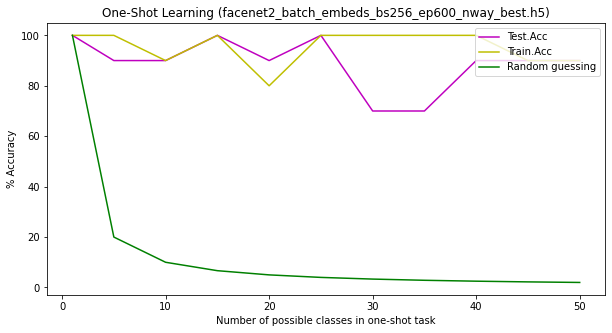

test 12 - model: face_recognition_batch_embeds_bs256_ep600_final.h5
[[0.5761843]] 0 0
[[0.74354666]] 0 0
[[0.73149896]] 0 0
[[0.58571154]] 0 0
[[0.7125053]] 0 0
[[0.7158579]] 0 0
[[0.6199332]] 0 0
[[0.60762024]] 0 0
[[0.69384414]] 0 0
[[0.70705295]] 0 0
[[0.6030808]] 0 0
[[0.76001024]] 0 0
[[0.75066435]] 0 0
[[0.45624644]] 0 0
[[0.61240864]] 0 0
[[0.45994675]] 0 0
[[0.76892847]] 0 0
[[0.5543592]] 0 0
[[0.73133385]] 0 0
[[0.7019178]] 0 0
[[0.3615105 ]
 [0.35726878]
 [0.37993848]
 [0.70693195]
 [0.32333192]] 3 3
[[0.34918317]
 [0.36910543]
 [0.37068713]
 [0.4075797 ]
 [0.62721795]] 4 4
[[0.32787153]
 [0.3666553 ]
 [0.46148   ]
 [0.5547328 ]
 [0.44376257]] 3 3
[[0.34619144]
 [0.75532895]
 [0.37918088]
 [0.36398372]
 [0.3344461 ]] 1 1
[[0.75563127]
 [0.33634433]
 [0.36105856]
 [0.31263664]
 [0.342746  ]] 0 0
[[0.36189732]
 [0.38526553]
 [0.5246321 ]
 [0.4404982 ]
 [0.33461744]] 2 2
[[0.44102195]
 [0.33284885]
 [0.31580716]
 [0.32314897]
 [0.47786507]] 4 4
[[0.4580456 ]
 [0.45392182]
 [0.66

[[0.21522325]
 [0.36735213]
 [0.38815635]
 [0.49138087]
 [0.3390621 ]
 [0.328522  ]
 [0.36273056]
 [0.27981013]
 [0.27933842]
 [0.36443198]
 [0.3421716 ]
 [0.47400904]
 [0.7389835 ]
 [0.3393663 ]
 [0.3190474 ]] 12 12
[[0.41829777]
 [0.43107343]
 [0.43306148]
 [0.5191125 ]
 [0.43732065]
 [0.6124086 ]
 [0.43333328]
 [0.38577837]
 [0.38965437]
 [0.50516397]
 [0.35530403]
 [0.34365687]
 [0.3668799 ]
 [0.4787639 ]
 [0.40234792]] 5 5
[[0.75066435]
 [0.39665118]
 [0.34811354]
 [0.39064103]
 [0.26765513]
 [0.2972629 ]
 [0.37809765]
 [0.30339408]
 [0.34956348]
 [0.38197988]
 [0.2697555 ]
 [0.35399294]
 [0.33149353]
 [0.5813558 ]
 [0.35148245]] 0 0
[[0.2924065 ]
 [0.347134  ]
 [0.36902148]
 [0.28382987]
 [0.34658614]
 [0.383932  ]
 [0.3442515 ]
 [0.29585883]
 [0.29959315]
 [0.25352764]
 [0.29098868]
 [0.37928328]
 [0.3060557 ]
 [0.76892847]
 [0.44516125]] 13 13
[[0.39959413]
 [0.34757733]
 [0.3810519 ]
 [0.41908473]
 [0.2862488 ]
 [0.27576178]
 [0.37015307]
 [0.31381297]
 [0.31087995]
 [0.461191

[[0.34496674]
 [0.32096744]
 [0.43955493]
 [0.41489625]
 [0.3395491 ]
 [0.4360013 ]
 [0.45354497]
 [0.460396  ]
 [0.39227152]
 [0.48873925]
 [0.76493144]
 [0.37938893]
 [0.3790292 ]
 [0.37338144]
 [0.40722367]
 [0.3101496 ]
 [0.31486303]
 [0.36893046]
 [0.5013264 ]
 [0.35454756]
 [0.31640983]
 [0.30498195]
 [0.2510316 ]
 [0.41070342]
 [0.3420781 ]] 10 10
[[0.3690523 ]
 [0.33622327]
 [0.7376671 ]
 [0.28056812]
 [0.28134894]
 [0.32037777]
 [0.32873294]
 [0.34037054]
 [0.27983302]
 [0.30789945]
 [0.2532287 ]
 [0.30452   ]
 [0.34605068]
 [0.38083357]
 [0.47634554]
 [0.35294694]
 [0.39592832]
 [0.3611248 ]
 [0.31394   ]
 [0.43459618]
 [0.28788772]
 [0.3144571 ]
 [0.34624195]
 [0.36264068]
 [0.27229744]] 2 2
[[0.37145978]
 [0.31176674]
 [0.46157452]
 [0.37748343]
 [0.52659076]
 [0.33414006]
 [0.42598787]
 [0.3877042 ]
 [0.29346508]
 [0.40552664]
 [0.28767022]
 [0.23020214]
 [0.46036172]
 [0.49816817]
 [0.44471735]
 [0.6009898 ]
 [0.32246238]
 [0.38429222]
 [0.41495848]
 [0.4018241 ]
 [0.3228

[[0.55197537]
 [0.2740455 ]
 [0.3236431 ]
 [0.37444878]
 [0.44360784]
 [0.44458267]
 [0.39230374]
 [0.49724284]
 [0.3537079 ]
 [0.32547683]
 [0.453099  ]
 [0.28689957]
 [0.28642803]
 [0.40904403]
 [0.3085993 ]
 [0.39811563]
 [0.45995876]
 [0.36735553]
 [0.40478125]
 [0.47635788]
 [0.3919207 ]
 [0.36809224]
 [0.41038984]
 [0.37459692]
 [0.29717442]
 [0.3193816 ]
 [0.3985457 ]
 [0.24092543]
 [0.44850612]
 [0.28374758]] 0 0
[[0.3579473 ]
 [0.33917835]
 [0.3018739 ]
 [0.4014994 ]
 [0.31794092]
 [0.3403949 ]
 [0.47523564]
 [0.31705654]
 [0.34267703]
 [0.4195075 ]
 [0.36463475]
 [0.2854362 ]
 [0.45761842]
 [0.6068311 ]
 [0.3449952 ]
 [0.3405188 ]
 [0.34561312]
 [0.35833752]
 [0.3377914 ]
 [0.24413797]
 [0.2893446 ]
 [0.38014916]
 [0.3771998 ]
 [0.35354388]
 [0.39466628]
 [0.45186976]
 [0.365676  ]
 [0.35297734]
 [0.34832865]
 [0.33062294]] 13 13
[[0.39756033]
 [0.6803273 ]
 [0.47148642]
 [0.32677895]
 [0.3019966 ]
 [0.37715954]
 [0.35871428]
 [0.3211915 ]
 [0.39721337]
 [0.3200898 ]
 [0.3856

[[0.32140836]
 [0.27148294]
 [0.37967786]
 [0.41166297]
 [0.6593992 ]
 [0.2956319 ]
 [0.4162417 ]
 [0.3779517 ]
 [0.3292809 ]
 [0.44748083]
 [0.31720197]
 [0.39132464]
 [0.28464746]
 [0.30042097]
 [0.37712836]
 [0.2986438 ]
 [0.38552314]
 [0.33717954]
 [0.33524156]
 [0.2733792 ]
 [0.36594313]
 [0.3188711 ]
 [0.35799867]
 [0.40362152]
 [0.41123658]
 [0.3183496 ]
 [0.31951398]
 [0.29378682]
 [0.46163315]
 [0.362045  ]
 [0.4422711 ]
 [0.39721382]
 [0.31466162]
 [0.38648772]
 [0.34057325]] 4 4
[[0.42092288]
 [0.4655721 ]
 [0.46984953]
 [0.45456383]
 [0.39570624]
 [0.40707868]
 [0.7102095 ]
 [0.46764004]
 [0.42430374]
 [0.43944025]
 [0.42172515]
 [0.44537827]
 [0.41831347]
 [0.4703033 ]
 [0.3900661 ]
 [0.41096467]
 [0.38740605]
 [0.36359978]
 [0.43839407]
 [0.4528783 ]
 [0.39780414]
 [0.44426864]
 [0.3621284 ]
 [0.39459804]
 [0.43612987]
 [0.41530135]
 [0.46615294]
 [0.4093536 ]
 [0.40229535]
 [0.3730415 ]
 [0.43024385]
 [0.43289015]
 [0.43859956]
 [0.4301649 ]
 [0.40984046]] 6 6
[[0.399017

[[0.3420018 ]
 [0.46501684]
 [0.4046561 ]
 [0.38468453]
 [0.34942168]
 [0.5318778 ]
 [0.46299958]
 [0.47630027]
 [0.34320742]
 [0.43306148]
 [0.39838243]
 [0.30553162]
 [0.33334756]
 [0.3803764 ]
 [0.38316527]
 [0.42438716]
 [0.370593  ]
 [0.32389972]
 [0.3738408 ]
 [0.6124086 ]
 [0.51995337]
 [0.36030102]
 [0.3465984 ]
 [0.34681264]
 [0.35288033]
 [0.33081305]
 [0.50391924]
 [0.35312286]
 [0.42419603]
 [0.32348472]
 [0.32136273]
 [0.5074384 ]
 [0.36711526]
 [0.50423676]
 [0.46006167]
 [0.37138113]
 [0.450126  ]
 [0.4658095 ]
 [0.36740434]
 [0.29886472]] 19 19
[[0.35276657]
 [0.35934561]
 [0.32907274]
 [0.3513996 ]
 [0.4147705 ]
 [0.474991  ]
 [0.34391814]
 [0.35805362]
 [0.3192829 ]
 [0.42613137]
 [0.5543592 ]
 [0.3635316 ]
 [0.28488463]
 [0.58847773]
 [0.34748745]
 [0.26069948]
 [0.31019264]
 [0.35333186]
 [0.35921562]
 [0.45486435]
 [0.38822454]
 [0.31427372]
 [0.2730388 ]
 [0.43258956]
 [0.45814785]
 [0.44842398]
 [0.31704885]
 [0.30358255]
 [0.4478488 ]
 [0.48246032]
 [0.26728797]

[[0.27625775]
 [0.38310125]
 [0.3136853 ]
 [0.31940377]
 [0.39911065]
 [0.2717468 ]
 [0.3105206 ]
 [0.33614427]
 [0.4013618 ]
 [0.26208138]
 [0.33704787]
 [0.47418404]
 [0.32960135]
 [0.38642424]
 [0.25411317]
 [0.58539677]
 [0.36905792]
 [0.34388262]
 [0.33514827]
 [0.2681718 ]
 [0.37111223]
 [0.2867607 ]
 [0.38020828]
 [0.37040967]
 [0.41144454]
 [0.36947227]
 [0.42488492]
 [0.30360284]
 [0.38683507]
 [0.39737153]
 [0.41361699]
 [0.3727209 ]
 [0.50438476]
 [0.3920536 ]
 [0.2863666 ]
 [0.3333179 ]
 [0.37148255]
 [0.28997588]
 [0.2864808 ]
 [0.3495574 ]
 [0.37971935]
 [0.3725642 ]
 [0.37755066]
 [0.32893273]
 [0.3036018 ]] 15 15
[[0.35986167]
 [0.37702158]
 [0.33810034]
 [0.25870213]
 [0.34456277]
 [0.41394696]
 [0.35782117]
 [0.31669396]
 [0.33016706]
 [0.37373415]
 [0.29032856]
 [0.3229752 ]
 [0.32282084]
 [0.42343315]
 [0.3344825 ]
 [0.39103228]
 [0.3056193 ]
 [0.36293834]
 [0.3027021 ]
 [0.34161574]
 [0.51038176]
 [0.28772843]
 [0.2964301 ]
 [0.33264604]
 [0.32868823]
 [0.35113072]

[[0.4519897 ]
 [0.47238523]
 [0.41728628]
 [0.4192393 ]
 [0.29209492]
 [0.7449906 ]
 [0.34965962]
 [0.34495705]
 [0.3897667 ]
 [0.4059331 ]
 [0.4402125 ]
 [0.36401296]
 [0.33621502]
 [0.4395525 ]
 [0.32342988]
 [0.44926536]
 [0.37376985]
 [0.38388428]
 [0.45560023]
 [0.34724408]
 [0.46984014]
 [0.31050217]
 [0.38844872]
 [0.34911546]
 [0.46123093]
 [0.33924687]
 [0.41479677]
 [0.47726282]
 [0.45449948]
 [0.39238977]
 [0.2928427 ]
 [0.4935809 ]
 [0.42663094]
 [0.34759945]
 [0.42957786]
 [0.42431664]
 [0.51330054]
 [0.41392973]
 [0.36303645]
 [0.37595773]
 [0.42981684]
 [0.34655446]
 [0.3978235 ]
 [0.3085199 ]
 [0.3565096 ]
 [0.40724736]
 [0.4967739 ]
 [0.38973823]
 [0.4065578 ]
 [0.25270003]] 5 5
[[0.2887128 ]
 [0.32975248]
 [0.504801  ]
 [0.35799158]
 [0.35142037]
 [0.2996056 ]
 [0.35388577]
 [0.32278973]
 [0.66644067]
 [0.43169916]
 [0.2563929 ]
 [0.27739856]
 [0.27327314]
 [0.28914583]
 [0.29659885]
 [0.3550686 ]
 [0.34646994]
 [0.52853537]
 [0.33951354]
 [0.33272642]
 [0.31595442]
 

[[0.43123263]
 [0.47440603]
 [0.31697136]
 [0.33305955]
 [0.33497682]
 [0.38084763]
 [0.33602887]
 [0.36552745]
 [0.39850178]
 [0.3214103 ]
 [0.3110621 ]
 [0.37754267]
 [0.3757288 ]
 [0.36132646]
 [0.4106956 ]
 [0.39518625]
 [0.33441985]
 [0.47163904]
 [0.34878203]
 [0.44345134]
 [0.31252888]
 [0.34637278]
 [0.41025072]
 [0.29942566]
 [0.34335837]
 [0.33006006]
 [0.4044644 ]
 [0.30659488]
 [0.37257528]
 [0.40235284]
 [0.40284213]
 [0.3488499 ]
 [0.2932679 ]
 [0.34217662]
 [0.36830515]
 [0.7282421 ]
 [0.31676775]
 [0.31072575]
 [0.41704917]
 [0.29026982]
 [0.38822597]
 [0.37411144]
 [0.4093631 ]
 [0.38734555]
 [0.38072568]
 [0.3637428 ]
 [0.28314328]
 [0.40307277]
 [0.3428585 ]
 [0.44004714]] 35 35
[[0.31024545]
 [0.571053  ]
 [0.4608546 ]
 [0.42891878]
 [0.33273226]
 [0.38210678]
 [0.36007458]
 [0.44588673]
 [0.24412966]
 [0.46936068]
 [0.7257276 ]
 [0.4524095 ]
 [0.2909803 ]
 [0.3569355 ]
 [0.38797557]
 [0.30832496]
 [0.38058218]
 [0.3878256 ]
 [0.3259184 ]
 [0.29341656]
 [0.3722648 ]

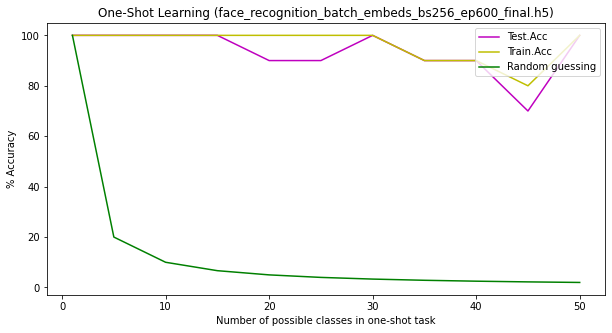

test 13 - model: facenet2_epoch_embeds_bs256_ep600_test_best.h5
[[0.73069394]] 0 0
[[0.6557065]] 0 0
[[0.573224]] 0 0
[[0.82734776]] 0 0
[[0.68401146]] 0 0
[[0.74869984]] 0 0
[[0.66696924]] 0 0
[[0.53360415]] 0 0
[[0.6185185]] 0 0
[[0.7543441]] 0 0
[[0.60515755]] 0 0
[[0.66168165]] 0 0
[[0.8382822]] 0 0
[[0.7696122]] 0 0
[[0.7853019]] 0 0
[[0.61884385]] 0 0
[[0.6906954]] 0 0
[[0.75231963]] 0 0
[[0.8382822]] 0 0
[[0.6594325]] 0 0
[[0.38251692]
 [0.37160122]
 [0.35153726]
 [0.7704387 ]
 [0.38160002]] 3 3
[[0.777665  ]
 [0.409146  ]
 [0.38080332]
 [0.37249374]
 [0.3487815 ]] 0 0
[[0.33997527]
 [0.579121  ]
 [0.3504025 ]
 [0.34085175]
 [0.3362801 ]] 1 1
[[0.66631514]
 [0.3609986 ]
 [0.4295859 ]
 [0.4019124 ]
 [0.42671955]] 0 0
[[0.4013255 ]
 [0.35959318]
 [0.34877867]
 [0.41200444]
 [0.6921696 ]] 4 4
[[0.4106601 ]
 [0.39751253]
 [0.41655684]
 [0.36491165]
 [0.6400038 ]] 4 4
[[0.38655812]
 [0.3989829 ]
 [0.3608494 ]
 [0.62835485]
 [0.34059727]] 3 3
[[0.34578162]
 [0.36492562]
 [0.3820163 ]


[[0.4078174 ]
 [0.38648018]
 [0.36249846]
 [0.35850626]
 [0.3501915 ]
 [0.35555363]
 [0.6434029 ]
 [0.40321466]
 [0.37051025]
 [0.43750194]
 [0.34689912]
 [0.39485168]
 [0.43285817]
 [0.35441378]
 [0.3768438 ]] 6 6
[[0.31938478]
 [0.35670975]
 [0.39481813]
 [0.39607793]
 [0.34001306]
 [0.43347913]
 [0.33952236]
 [0.77175033]
 [0.37662444]
 [0.41908917]
 [0.38633537]
 [0.3470607 ]
 [0.39816278]
 [0.37553248]
 [0.34410608]] 7 7
[[0.36900696]
 [0.405111  ]
 [0.4112774 ]
 [0.37897137]
 [0.3477506 ]
 [0.36149603]
 [0.35477322]
 [0.35811943]
 [0.4155823 ]
 [0.36750287]
 [0.34640193]
 [0.34558862]
 [0.33301085]
 [0.34806594]
 [0.39271885]
 [0.3460084 ]
 [0.36379716]
 [0.36302483]
 [0.6806726 ]
 [0.3525379 ]] 18 18
[[0.39430857]
 [0.37987748]
 [0.34442684]
 [0.37623823]
 [0.42041504]
 [0.3977506 ]
 [0.36557543]
 [0.4197716 ]
 [0.67716205]
 [0.3435254 ]
 [0.37816435]
 [0.38251203]
 [0.40803203]
 [0.35268304]
 [0.37808472]
 [0.3757339 ]
 [0.35599446]
 [0.38134605]
 [0.34723145]
 [0.39347357]] 8 

[[0.50233525]
 [0.41905147]
 [0.37724236]
 [0.3733297 ]
 [0.46399373]
 [0.40030897]
 [0.38227037]
 [0.41265148]
 [0.46741673]
 [0.42672446]
 [0.45394415]
 [0.4402262 ]
 [0.4208145 ]
 [0.48683125]
 [0.37014228]
 [0.38579232]
 [0.4392147 ]
 [0.4389576 ]
 [0.46255043]
 [0.44079897]
 [0.6213549 ]
 [0.38041794]
 [0.45294118]
 [0.4910104 ]
 [0.41532293]] 20 20
[[0.4352566 ]
 [0.39667434]
 [0.41590196]
 [0.3918824 ]
 [0.4177693 ]
 [0.52249235]
 [0.48617944]
 [0.43063748]
 [0.34937534]
 [0.39046907]
 [0.44119692]
 [0.36035115]
 [0.34951055]
 [0.38441744]
 [0.46524495]
 [0.4124884 ]
 [0.3388924 ]
 [0.42525202]
 [0.39259323]
 [0.4310759 ]
 [0.37549987]
 [0.36711627]
 [0.41420636]
 [0.40846092]
 [0.34751773]] 5 5
[[0.374424  ]
 [0.33740157]
 [0.3699448 ]
 [0.36464155]
 [0.38694835]
 [0.3789091 ]
 [0.6167566 ]
 [0.39871967]
 [0.34355065]
 [0.43503335]
 [0.3606926 ]
 [0.36292738]
 [0.4454207 ]
 [0.37935194]
 [0.3561855 ]
 [0.35417187]
 [0.37410846]
 [0.39089468]
 [0.34417254]
 [0.44232175]
 [0.3936

[[0.35329533]
 [0.3744635 ]
 [0.3851958 ]
 [0.36071372]
 [0.47147176]
 [0.3881328 ]
 [0.4199873 ]
 [0.37750572]
 [0.8169297 ]
 [0.36101395]
 [0.45397452]
 [0.403671  ]
 [0.3748799 ]
 [0.35495615]
 [0.33625555]
 [0.36256596]
 [0.40102926]
 [0.34915233]
 [0.35836828]
 [0.3794892 ]
 [0.38975334]
 [0.42635816]
 [0.34197247]
 [0.34431276]
 [0.39349243]
 [0.39822856]
 [0.41935936]
 [0.36141226]
 [0.3990571 ]
 [0.36829898]] 8 8
[[0.34332973]
 [0.3518042 ]
 [0.36198103]
 [0.38458294]
 [0.3455161 ]
 [0.3661291 ]
 [0.3493018 ]
 [0.36239523]
 [0.35811615]
 [0.37065208]
 [0.3633423 ]
 [0.40597767]
 [0.3489604 ]
 [0.35887071]
 [0.3753304 ]
 [0.43107206]
 [0.4491504 ]
 [0.407242  ]
 [0.34681737]
 [0.34074384]
 [0.35679933]
 [0.72933877]
 [0.41041383]
 [0.35582194]
 [0.43143108]
 [0.39555964]
 [0.3780685 ]
 [0.3739654 ]
 [0.3953035 ]
 [0.35001576]] 21 21
[[0.35615775]
 [0.3442003 ]
 [0.3889964 ]
 [0.40033764]
 [0.34977287]
 [0.35412842]
 [0.39164114]
 [0.37866098]
 [0.35820156]
 [0.35973713]
 [0.3542

[[0.3829782 ]
 [0.35623807]
 [0.36274746]
 [0.3609891 ]
 [0.37488174]
 [0.35147563]
 [0.37431788]
 [0.3575587 ]
 [0.3672429 ]
 [0.36273754]
 [0.37425163]
 [0.3417025 ]
 [0.3636489 ]
 [0.3915823 ]
 [0.36226046]
 [0.35030684]
 [0.40284768]
 [0.371297  ]
 [0.34662104]
 [0.38473028]
 [0.37856412]
 [0.34348524]
 [0.34044665]
 [0.34998304]
 [0.33325118]
 [0.40758395]
 [0.362492  ]
 [0.35851675]
 [0.46554247]
 [0.37575376]
 [0.47274843]
 [0.37066483]
 [0.37573245]
 [0.3581825 ]
 [0.3971754 ]] 30 30
[[0.39154777]
 [0.36918133]
 [0.38288996]
 [0.4344144 ]
 [0.43637145]
 [0.40771312]
 [0.41386223]
 [0.4151539 ]
 [0.4053328 ]
 [0.36279738]
 [0.4416492 ]
 [0.3507629 ]
 [0.37230211]
 [0.4065296 ]
 [0.35497227]
 [0.44142163]
 [0.41726607]
 [0.3633561 ]
 [0.37381333]
 [0.36755222]
 [0.38430524]
 [0.3902129 ]
 [0.35405686]
 [0.3757298 ]
 [0.4348853 ]
 [0.3660643 ]
 [0.37161836]
 [0.3968325 ]
 [0.3856232 ]
 [0.41746697]
 [0.35456592]
 [0.3698311 ]
 [0.3546053 ]
 [0.4160076 ]
 [0.3851302 ]] 10 0
[[0.379

[[0.36172992]
 [0.40343335]
 [0.42883122]
 [0.3707571 ]
 [0.4184679 ]
 [0.40721077]
 [0.36360997]
 [0.35412836]
 [0.83996683]
 [0.38783073]
 [0.36763087]
 [0.42285103]
 [0.34589642]
 [0.37918028]
 [0.36822695]
 [0.39290833]
 [0.36233127]
 [0.4019139 ]
 [0.36858663]
 [0.36282516]
 [0.36497167]
 [0.47834897]
 [0.3617609 ]
 [0.4293304 ]
 [0.4001177 ]
 [0.38205826]
 [0.3461213 ]
 [0.37210524]
 [0.38054687]
 [0.40559468]
 [0.38495937]
 [0.35038978]
 [0.37105733]
 [0.34230596]
 [0.41329294]
 [0.36716676]
 [0.38721335]
 [0.49891222]
 [0.42506522]
 [0.38462356]] 8 8
[[0.34058774]
 [0.37156913]
 [0.40548426]
 [0.3872941 ]
 [0.3680645 ]
 [0.34147906]
 [0.34117037]
 [0.35902166]
 [0.33740073]
 [0.34727353]
 [0.35545194]
 [0.37125814]
 [0.35332996]
 [0.3262881 ]
 [0.37779903]
 [0.35185045]
 [0.36407244]
 [0.33808148]
 [0.33503553]
 [0.35173306]
 [0.3444388 ]
 [0.39697388]
 [0.5497901 ]
 [0.3519973 ]
 [0.41383293]
 [0.35843214]
 [0.31952888]
 [0.3584892 ]
 [0.35099253]
 [0.3670915 ]
 [0.33179975]
 

[[0.37292445]
 [0.40481976]
 [0.3818896 ]
 [0.37793422]
 [0.38250726]
 [0.34677035]
 [0.3803327 ]
 [0.3405187 ]
 [0.36766413]
 [0.3826097 ]
 [0.34351718]
 [0.3836897 ]
 [0.3964604 ]
 [0.4109347 ]
 [0.3762958 ]
 [0.33806962]
 [0.38162097]
 [0.3813637 ]
 [0.34460458]
 [0.3748786 ]
 [0.37921998]
 [0.36320567]
 [0.36725867]
 [0.3608433 ]
 [0.36409897]
 [0.37918812]
 [0.45691565]
 [0.38539293]
 [0.3655287 ]
 [0.419935  ]
 [0.37647033]
 [0.3448348 ]
 [0.42336535]
 [0.41949704]
 [0.3491516 ]
 [0.7459904 ]
 [0.39294368]
 [0.39432067]
 [0.37902656]
 [0.39091516]
 [0.37500754]
 [0.44648677]
 [0.43920213]
 [0.41621518]
 [0.3933465 ]] 35 35
[[0.40941316]
 [0.4098099 ]
 [0.36853334]
 [0.36216432]
 [0.37132257]
 [0.41766897]
 [0.4368159 ]
 [0.38406456]
 [0.40401042]
 [0.3829946 ]
 [0.38805175]
 [0.36247227]
 [0.36519802]
 [0.45728838]
 [0.40779513]
 [0.36001563]
 [0.40735605]
 [0.40630305]
 [0.36325097]
 [0.40702748]
 [0.3630684 ]
 [0.37322563]
 [0.47020566]
 [0.39593095]
 [0.39793912]
 [0.36705506]

[[0.5460567 ]
 [0.42438528]
 [0.42106843]
 [0.44037983]
 [0.3590357 ]
 [0.38233477]
 [0.45152614]
 [0.40214065]
 [0.42878687]
 [0.43860143]
 [0.38982442]
 [0.38305992]
 [0.4386865 ]
 [0.44294584]
 [0.40971458]
 [0.40181646]
 [0.3649124 ]
 [0.37954938]
 [0.42393884]
 [0.39579552]
 [0.3928166 ]
 [0.4100818 ]
 [0.43130776]
 [0.4942186 ]
 [0.36810496]
 [0.36783546]
 [0.41677445]
 [0.4074363 ]
 [0.39698768]
 [0.4123801 ]
 [0.42586336]
 [0.4113823 ]
 [0.43409   ]
 [0.3782008 ]
 [0.4081084 ]
 [0.3892404 ]
 [0.391791  ]
 [0.365174  ]
 [0.40410995]
 [0.37947285]
 [0.4279627 ]
 [0.38244003]
 [0.36977404]
 [0.39947075]
 [0.47186604]
 [0.46731848]
 [0.42530212]
 [0.38637188]
 [0.42572984]
 [0.36365706]] 0 0
[[0.37920722]
 [0.37997407]
 [0.3740803 ]
 [0.36289784]
 [0.36630857]
 [0.37130666]
 [0.3861057 ]
 [0.33848602]
 [0.35137063]
 [0.33666927]
 [0.41927317]
 [0.37786952]
 [0.37242228]
 [0.36565232]
 [0.3995938 ]
 [0.36709744]
 [0.35728985]
 [0.36573213]
 [0.39149696]
 [0.34676102]
 [0.3709075 ]
 

[[0.3248708 ]
 [0.32722044]
 [0.3570597 ]
 [0.34047198]
 [0.32077447]
 [0.36302352]
 [0.35835695]
 [0.33289504]
 [0.35692036]
 [0.36596513]
 [0.35945135]
 [0.35390705]
 [0.36570543]
 [0.39646313]
 [0.34061322]
 [0.34474522]
 [0.35032183]
 [0.37091064]
 [0.38617837]
 [0.40726286]
 [0.3375498 ]
 [0.4110688 ]
 [0.341924  ]
 [0.38265786]
 [0.34689915]
 [0.38367543]
 [0.35425794]
 [0.38813144]
 [0.3648336 ]
 [0.38077277]
 [0.3689769 ]
 [0.37137258]
 [0.37540975]
 [0.38674963]
 [0.46996203]
 [0.32474387]
 [0.39490956]
 [0.3852491 ]
 [0.35853425]
 [0.35865057]
 [0.3540276 ]
 [0.35785145]
 [0.3621114 ]
 [0.7909473 ]
 [0.3634447 ]
 [0.3676303 ]
 [0.40684563]
 [0.41119584]
 [0.3690909 ]
 [0.37050802]] 43 43
[[0.37454545]
 [0.40505016]
 [0.34602183]
 [0.3711586 ]
 [0.39230707]
 [0.34023178]
 [0.35992154]
 [0.3743021 ]
 [0.34584987]
 [0.33462933]
 [0.4023871 ]
 [0.3915555 ]
 [0.37046927]
 [0.38491517]
 [0.3847206 ]
 [0.3474564 ]
 [0.3625713 ]
 [0.39631453]
 [0.37658754]
 [0.3683582 ]
 [0.39536655]

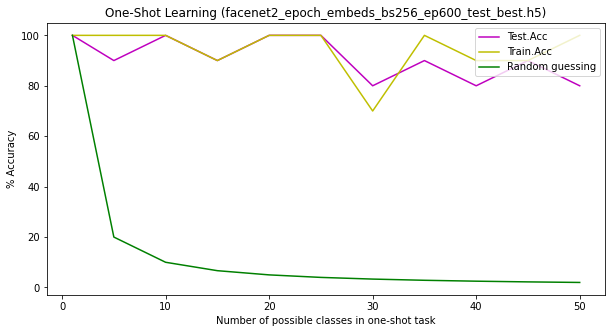

test 14 - model: face_recognition_epoch_embeds_bs256_ep600_nway_best.h5
[[0.5087864]] 0 0
[[0.50884485]] 0 0
[[0.50490725]] 0 0
[[0.5105935]] 0 0
[[0.5055378]] 0 0
[[0.5078097]] 0 0
[[0.50414836]] 0 0
[[0.5090887]] 0 0
[[0.5075144]] 0 0
[[0.503416]] 0 0
[[0.5091351]] 0 0
[[0.50601864]] 0 0
[[0.5101371]] 0 0
[[0.5091351]] 0 0
[[0.5093797]] 0 0
[[0.5050236]] 0 0
[[0.5035854]] 0 0
[[0.50970054]] 0 0
[[0.5091326]] 0 0
[[0.5100423]] 0 0
[[0.5110578 ]
 [0.49867696]
 [0.4985894 ]
 [0.49953544]
 [0.50068253]] 0 0
[[0.49873173]
 [0.5106494 ]
 [0.49984717]
 [0.5006061 ]
 [0.50080967]] 1 1
[[0.50804263]
 [0.49962062]
 [0.50113475]
 [0.5009277 ]
 [0.50259525]] 0 0
[[0.49990073]
 [0.5101726 ]
 [0.501056  ]
 [0.49975443]
 [0.49926212]] 1 1
[[0.50522804]
 [0.49848646]
 [0.5024075 ]
 [0.4990245 ]
 [0.5003291 ]] 0 0
[[0.50903344]
 [0.49850935]
 [0.49893498]
 [0.49978468]
 [0.5007076 ]] 0 0
[[0.5013075 ]
 [0.49903858]
 [0.50529575]
 [0.5027709 ]
 [0.50034404]] 2 2
[[0.4987468 ]
 [0.5006199 ]
 [0.5060071

[[0.49882895]
 [0.49875537]
 [0.49922556]
 [0.50056773]
 [0.49781245]
 [0.5009967 ]
 [0.50180286]
 [0.49973476]
 [0.5069566 ]
 [0.4996565 ]
 [0.50050664]
 [0.49948186]
 [0.50049746]
 [0.50061584]
 [0.49965143]] 8 8
[[0.49792624]
 [0.5027427 ]
 [0.5002017 ]
 [0.49894622]
 [0.4995933 ]
 [0.49837014]
 [0.4996846 ]
 [0.5000434 ]
 [0.49813345]
 [0.5015915 ]
 [0.5012152 ]
 [0.499938  ]
 [0.49925095]
 [0.5001564 ]
 [0.50831705]] 14 14
[[0.50147575]
 [0.509701  ]
 [0.5002208 ]
 [0.5013946 ]
 [0.49971473]
 [0.5017748 ]
 [0.50120926]
 [0.5013523 ]
 [0.49975032]
 [0.49914274]
 [0.50127673]
 [0.50095505]
 [0.50023454]
 [0.5002604 ]
 [0.50257635]] 1 1
[[0.49981618]
 [0.49753162]
 [0.49835426]
 [0.5007896 ]
 [0.49968806]
 [0.5000397 ]
 [0.49818516]
 [0.49836314]
 [0.50146294]
 [0.5093441 ]
 [0.5031737 ]
 [0.4979533 ]
 [0.49881062]
 [0.49899924]
 [0.4988897 ]
 [0.49727014]
 [0.49983436]
 [0.4980222 ]
 [0.49870256]
 [0.5010409 ]] 9 9
[[0.49879864]
 [0.5097058 ]
 [0.4997431 ]
 [0.50077945]
 [0.5023661 

[[0.5024416 ]
 [0.5030061 ]
 [0.5015426 ]
 [0.50107753]
 [0.5027235 ]
 [0.50280124]
 [0.50178874]
 [0.49964666]
 [0.5008898 ]
 [0.500743  ]
 [0.5013669 ]
 [0.50244147]
 [0.5012119 ]
 [0.5033514 ]
 [0.5027841 ]
 [0.5016964 ]
 [0.502352  ]
 [0.50124997]
 [0.5026529 ]
 [0.5037363 ]
 [0.50097966]
 [0.50154924]
 [0.5016291 ]
 [0.50220853]
 [0.50236535]] 19 14
[[0.50037014]
 [0.5003359 ]
 [0.5015149 ]
 [0.49777302]
 [0.5021072 ]
 [0.5013364 ]
 [0.50666183]
 [0.500736  ]
 [0.50050426]
 [0.49918643]
 [0.49917215]
 [0.50057924]
 [0.50038934]
 [0.5022449 ]
 [0.50073355]
 [0.5040038 ]
 [0.50030786]
 [0.4999659 ]
 [0.50087   ]
 [0.5011107 ]
 [0.49729812]
 [0.4998815 ]
 [0.4982914 ]
 [0.50116104]
 [0.50254226]] 6 6
[[0.49735194]
 [0.49789515]
 [0.49802402]
 [0.49880475]
 [0.4965191 ]
 [0.50232846]
 [0.49621788]
 [0.49944687]
 [0.49820197]
 [0.5001814 ]
 [0.4974798 ]
 [0.49928394]
 [0.508071  ]
 [0.49635383]
 [0.49545982]
 [0.50036466]
 [0.49976063]
 [0.49916783]
 [0.49798533]
 [0.4994575 ]
 [0.5008

[[0.50126857]
 [0.49912062]
 [0.50005525]
 [0.5104527 ]
 [0.50134355]
 [0.49978918]
 [0.5001969 ]
 [0.49898806]
 [0.5004937 ]
 [0.5000657 ]
 [0.4983788 ]
 [0.49866098]
 [0.5002181 ]
 [0.5002445 ]
 [0.5006765 ]
 [0.49879554]
 [0.50098944]
 [0.49923366]
 [0.4967836 ]
 [0.50184256]
 [0.49806628]
 [0.49937007]
 [0.5007218 ]
 [0.5036657 ]
 [0.4976987 ]
 [0.5000549 ]
 [0.5020244 ]
 [0.5003906 ]
 [0.49973932]
 [0.49916682]] 3 3
[[0.5016054 ]
 [0.5018447 ]
 [0.50182307]
 [0.50168526]
 [0.49997503]
 [0.4998805 ]
 [0.50232345]
 [0.501022  ]
 [0.49907452]
 [0.4970316 ]
 [0.5022293 ]
 [0.49876392]
 [0.4990478 ]
 [0.50088245]
 [0.5005751 ]
 [0.5005086 ]
 [0.49973878]
 [0.5013455 ]
 [0.49987185]
 [0.50825256]
 [0.5046045 ]
 [0.49902946]
 [0.5011443 ]
 [0.5026663 ]
 [0.50238866]
 [0.49801153]
 [0.4976929 ]
 [0.49964643]
 [0.50019574]
 [0.5025347 ]] 19 19
[[0.4974167 ]
 [0.50058544]
 [0.49869788]
 [0.5004623 ]
 [0.49984682]
 [0.49878654]
 [0.49794596]
 [0.49998307]
 [0.49843645]
 [0.5095278 ]
 [0.5002

[[0.49876857]
 [0.5037801 ]
 [0.49749833]
 [0.49869108]
 [0.49690518]
 [0.4974806 ]
 [0.49951932]
 [0.49727693]
 [0.49931696]
 [0.49900633]
 [0.4986604 ]
 [0.49863774]
 [0.49855196]
 [0.49866885]
 [0.50080615]
 [0.49987692]
 [0.49824777]
 [0.5106526 ]
 [0.49825785]
 [0.4995269 ]
 [0.49875647]
 [0.49851036]
 [0.49989876]
 [0.4980691 ]
 [0.49695605]
 [0.50011617]
 [0.49885008]
 [0.4989784 ]
 [0.5004181 ]
 [0.49699453]
 [0.49820054]
 [0.49992383]
 [0.4984023 ]
 [0.4978497 ]
 [0.50143796]] 17 17
[[0.5009609 ]
 [0.50200695]
 [0.502072  ]
 [0.5032621 ]
 [0.49948102]
 [0.50102025]
 [0.5032811 ]
 [0.5015989 ]
 [0.50155663]
 [0.5006876 ]
 [0.50097156]
 [0.5013985 ]
 [0.50216055]
 [0.49997723]
 [0.5021389 ]
 [0.5030788 ]
 [0.5012428 ]
 [0.50215197]
 [0.5007622 ]
 [0.5009918 ]
 [0.5003941 ]
 [0.5025454 ]
 [0.50368667]
 [0.5020824 ]
 [0.5012028 ]
 [0.50245255]
 [0.5013113 ]
 [0.50463593]
 [0.5004895 ]
 [0.49984533]
 [0.5019754 ]
 [0.50166845]
 [0.50063103]
 [0.50011355]
 [0.5020558 ]] 27 6
[[0.500

[[0.4987293 ]
 [0.5019161 ]
 [0.5015982 ]
 [0.49888387]
 [0.50258666]
 [0.5023557 ]
 [0.5001626 ]
 [0.5012303 ]
 [0.5006228 ]
 [0.49861908]
 [0.5003323 ]
 [0.50035405]
 [0.5012321 ]
 [0.49896103]
 [0.5011085 ]
 [0.5004348 ]
 [0.5025825 ]
 [0.5015937 ]
 [0.49972785]
 [0.50248224]
 [0.5010431 ]
 [0.50045496]
 [0.5004653 ]
 [0.49877846]
 [0.5018572 ]
 [0.50391436]
 [0.50189847]
 [0.50143516]
 [0.5025009 ]
 [0.5027411 ]
 [0.49881792]
 [0.5003017 ]
 [0.50198054]
 [0.5002585 ]
 [0.49996194]
 [0.502749  ]
 [0.50146157]
 [0.5028028 ]
 [0.5029364 ]
 [0.50941515]] 39 39
[[0.4985914 ]
 [0.49945903]
 [0.49976847]
 [0.49789166]
 [0.4990288 ]
 [0.49763456]
 [0.4986584 ]
 [0.49799863]
 [0.49989718]
 [0.49717823]
 [0.4990633 ]
 [0.49978778]
 [0.5001499 ]
 [0.49845174]
 [0.49771786]
 [0.501108  ]
 [0.49823633]
 [0.4997147 ]
 [0.49895972]
 [0.49949706]
 [0.49769104]
 [0.49667093]
 [0.5029303 ]
 [0.49616188]
 [0.49982008]
 [0.4998565 ]
 [0.49833947]
 [0.49822447]
 [0.50219995]
 [0.49758622]
 [0.4989399 ]

[[0.5009918 ]
 [0.50065714]
 [0.50246155]
 [0.5016598 ]
 [0.5009922 ]
 [0.50003487]
 [0.5059015 ]
 [0.50422615]
 [0.5013113 ]
 [0.5036643 ]
 [0.50083804]
 [0.50124925]
 [0.5032811 ]
 [0.50052977]
 [0.5008261 ]
 [0.50172275]
 [0.5010411 ]
 [0.5014126 ]
 [0.50245255]
 [0.5000215 ]
 [0.50185114]
 [0.5027425 ]
 [0.5008437 ]
 [0.49987513]
 [0.5007865 ]
 [0.49903172]
 [0.5001148 ]
 [0.5002335 ]
 [0.5004895 ]
 [0.50125515]
 [0.50159895]
 [0.5011103 ]
 [0.5020406 ]
 [0.5002805 ]
 [0.5014577 ]
 [0.5025198 ]
 [0.50008816]
 [0.5020558 ]
 [0.500603  ]
 [0.5012434 ]
 [0.49924096]
 [0.50356805]
 [0.502371  ]
 [0.50074977]
 [0.50159574]] 6 12
[[0.50012076]
 [0.507417  ]
 [0.4999335 ]
 [0.49955302]
 [0.50031734]
 [0.50099534]
 [0.50157595]
 [0.4993026 ]
 [0.49961877]
 [0.5006346 ]
 [0.5018236 ]
 [0.5008855 ]
 [0.49980342]
 [0.50045043]
 [0.4986738 ]
 [0.5008545 ]
 [0.49885675]
 [0.49948344]
 [0.4987265 ]
 [0.49860582]
 [0.50225663]
 [0.5008893 ]
 [0.49907205]
 [0.49990985]
 [0.49964333]
 [0.4992549 ]


[[0.502408  ]
 [0.5011623 ]
 [0.49945855]
 [0.49727258]
 [0.5016614 ]
 [0.500986  ]
 [0.4983168 ]
 [0.49947637]
 [0.4998408 ]
 [0.50383323]
 [0.5043263 ]
 [0.50280035]
 [0.50314236]
 [0.50348246]
 [0.49849033]
 [0.50007665]
 [0.50222063]
 [0.4995069 ]
 [0.499639  ]
 [0.50099796]
 [0.50115156]
 [0.50341606]
 [0.5022433 ]
 [0.5010093 ]
 [0.49978852]
 [0.49924687]
 [0.50125843]
 [0.50172037]
 [0.49960545]
 [0.49973765]
 [0.49765936]
 [0.5025811 ]
 [0.50127375]
 [0.4992973 ]
 [0.49971673]
 [0.5025054 ]
 [0.50232273]
 [0.50162566]
 [0.49939305]
 [0.49925867]
 [0.49924257]
 [0.50124   ]
 [0.503207  ]
 [0.50117683]
 [0.5021966 ]
 [0.49965316]
 [0.49972957]
 [0.5015642 ]
 [0.5027586 ]
 [0.49975622]] 10 21
[[0.49733287]
 [0.5000612 ]
 [0.5069025 ]
 [0.50086284]
 [0.5008675 ]
 [0.49878478]
 [0.49952498]
 [0.5005739 ]
 [0.49799657]
 [0.49948812]
 [0.5001156 ]
 [0.501136  ]
 [0.50086063]
 [0.49841052]
 [0.5020944 ]
 [0.49787435]
 [0.5011911 ]
 [0.50147146]
 [0.49921253]
 [0.49969056]
 [0.49826527]

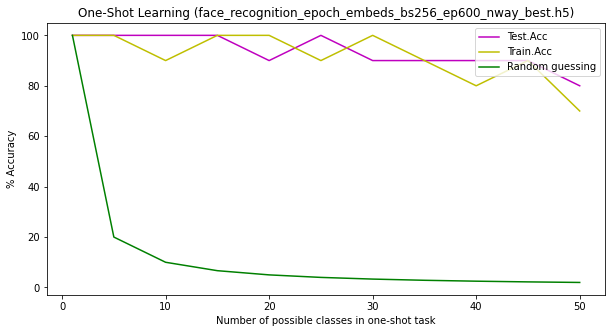

test 15 - model: facenet2_epoch_embeds_bs256_ep600_final.h5
[[0.76547295]] 0 0
[[0.9570283]] 0 0
[[0.942791]] 0 0
[[0.8258435]] 0 0
[[0.9594001]] 0 0
[[0.23503394]] 0 0
[[0.6132683]] 0 0
[[0.94965047]] 0 0
[[0.7820327]] 0 0
[[0.9625117]] 0 0
[[0.8373069]] 0 0
[[0.9436743]] 0 0
[[0.6716521]] 0 0
[[0.94528174]] 0 0
[[0.8864383]] 0 0
[[0.8624794]] 0 0
[[0.9590204]] 0 0
[[0.92456216]] 0 0
[[0.88625777]] 0 0
[[0.9362128]] 0 0
[[0.24552232]
 [0.9217484 ]
 [0.15232582]
 [0.2197615 ]
 [0.23132987]] 1 1
[[0.7188114 ]
 [0.22467881]
 [0.15566835]
 [0.20534661]
 [0.2485867 ]] 0 0
[[0.15570621]
 [0.8893181 ]
 [0.17201395]
 [0.1856189 ]
 [0.2489369 ]] 1 1
[[0.27084437]
 [0.1895062 ]
 [0.24535038]
 [0.18898503]
 [0.16927136]] 0 0
[[0.20660694]
 [0.17166907]
 [0.8801812 ]
 [0.22107692]
 [0.20414594]] 2 2
[[0.14021851]
 [0.36870137]
 [0.18532674]
 [0.18831955]
 [0.42087755]] 4 4
[[0.23917708]
 [0.18129732]
 [0.21618412]
 [0.50026363]
 [0.25195804]] 3 3
[[0.12742238]
 [0.1541064 ]
 [0.17825915]
 [0.1550

[[0.18399003]
 [0.16417068]
 [0.9362128 ]
 [0.21621439]
 [0.28518242]
 [0.21811205]
 [0.22429758]
 [0.17745316]
 [0.29346558]
 [0.29756612]
 [0.2965875 ]
 [0.18786027]
 [0.20258941]
 [0.23247597]
 [0.3364248 ]] 2 2
[[0.26277503]
 [0.39390254]
 [0.19989142]
 [0.25774306]
 [0.16820747]
 [0.27014208]
 [0.2633217 ]
 [0.18741947]
 [0.15232524]
 [0.17539434]
 [0.20813495]
 [0.23990609]
 [0.23533018]
 [0.6716521 ]
 [0.33154333]] 13 13
[[0.21474358]
 [0.21833086]
 [0.23026979]
 [0.25338817]
 [0.22774187]
 [0.18639594]
 [0.9144492 ]
 [0.2639595 ]
 [0.15928379]
 [0.23765418]
 [0.23082343]
 [0.2318004 ]
 [0.25180784]
 [0.1928339 ]
 [0.18163505]
 [0.16669583]
 [0.24410631]
 [0.32541245]
 [0.36334938]
 [0.18938509]] 6 6
[[0.34121963]
 [0.33280373]
 [0.2921771 ]
 [0.50116825]
 [0.28240705]
 [0.40238667]
 [0.42289388]
 [0.34865344]
 [0.3927882 ]
 [0.32622674]
 [0.49045762]
 [0.26388222]
 [0.17068285]
 [0.33079982]
 [0.41145688]
 [0.42725348]
 [0.8772562 ]
 [0.3850431 ]
 [0.24912515]
 [0.26789743]] 16

[[0.36184707]
 [0.1923568 ]
 [0.26393163]
 [0.14969152]
 [0.22030035]
 [0.14908081]
 [0.20273307]
 [0.21854827]
 [0.2729634 ]
 [0.33741665]
 [0.14794406]
 [0.26933065]
 [0.23325434]
 [0.16504166]
 [0.14976665]
 [0.95492977]
 [0.3163985 ]
 [0.18789232]
 [0.32550758]
 [0.20489454]
 [0.1877845 ]
 [0.20162234]
 [0.22290513]
 [0.25706586]
 [0.1513524 ]] 15 15
[[0.21955904]
 [0.16266161]
 [0.18976977]
 [0.14150608]
 [0.24918151]
 [0.9144126 ]
 [0.17930421]
 [0.13694918]
 [0.18868709]
 [0.20479295]
 [0.14717945]
 [0.17456576]
 [0.15174434]
 [0.18184453]
 [0.18291026]
 [0.2160699 ]
 [0.1786359 ]
 [0.14454037]
 [0.21249375]
 [0.20635214]
 [0.20124674]
 [0.204332  ]
 [0.18408734]
 [0.17434493]
 [0.18450522]] 5 5
[[0.38450584]
 [0.29698795]
 [0.23968306]
 [0.18707815]
 [0.20281464]
 [0.21406761]
 [0.19746688]
 [0.15762797]
 [0.42763537]
 [0.17661765]
 [0.20456624]
 [0.23379129]
 [0.32187563]
 [0.6572578 ]
 [0.20097426]
 [0.23857123]
 [0.19997686]
 [0.2435273 ]
 [0.3723666 ]
 [0.3861182 ]
 [0.2663

[[0.22673386]
 [0.19899201]
 [0.65006113]
 [0.25157282]
 [0.16929013]
 [0.22117764]
 [0.31265366]
 [0.20042434]
 [0.19548914]
 [0.22235733]
 [0.1922307 ]
 [0.16249123]
 [0.30290118]
 [0.14525619]
 [0.22171384]
 [0.44675398]
 [0.22812325]
 [0.24944746]
 [0.29354477]
 [0.39353818]
 [0.3239837 ]
 [0.22370917]
 [0.18092912]
 [0.19455457]
 [0.15575933]
 [0.2363966 ]
 [0.24985358]
 [0.21463436]
 [0.1737947 ]
 [0.19787605]] 2 2
[[0.17850795]
 [0.2613198 ]
 [0.18861389]
 [0.20974827]
 [0.14064476]
 [0.16218036]
 [0.821453  ]
 [0.15012354]
 [0.1688337 ]
 [0.25742078]
 [0.1556701 ]
 [0.27916557]
 [0.23087355]
 [0.30260164]
 [0.17300549]
 [0.18133822]
 [0.21981177]
 [0.2667722 ]
 [0.24280146]
 [0.23172739]
 [0.17891675]
 [0.3523698 ]
 [0.31600958]
 [0.21865073]
 [0.17461817]
 [0.28675744]
 [0.20535615]
 [0.48237947]
 [0.2765796 ]
 [0.1834275 ]] 6 6
[[0.15113038]
 [0.22209203]
 [0.37901828]
 [0.24545226]
 [0.37125224]
 [0.32848004]
 [0.23499313]
 [0.2632361 ]
 [0.25020647]
 [0.20280814]
 [0.361906

[[0.23710027]
 [0.25498986]
 [0.25133517]
 [0.23106721]
 [0.3611873 ]
 [0.396518  ]
 [0.247859  ]
 [0.15722749]
 [0.1954416 ]
 [0.22497901]
 [0.24276906]
 [0.26372802]
 [0.23914987]
 [0.1571652 ]
 [0.23025256]
 [0.18163875]
 [0.28396875]
 [0.21795842]
 [0.21052867]
 [0.23174262]
 [0.23789167]
 [0.17592123]
 [0.15879259]
 [0.25108692]
 [0.22816801]
 [0.9323157 ]
 [0.21797913]
 [0.22846013]
 [0.4282305 ]
 [0.20044616]
 [0.246476  ]
 [0.16056916]
 [0.22193024]
 [0.22130576]
 [0.26735485]] 25 25
[[0.23490196]
 [0.16483605]
 [0.84836996]
 [0.31485406]
 [0.24052718]
 [0.18281469]
 [0.23347646]
 [0.12093145]
 [0.15547028]
 [0.14501455]
 [0.2118763 ]
 [0.25941765]
 [0.20626417]
 [0.2090551 ]
 [0.17481679]
 [0.1686143 ]
 [0.19231957]
 [0.20038533]
 [0.2011809 ]
 [0.176842  ]
 [0.18736604]
 [0.23911855]
 [0.2813406 ]
 [0.20986357]
 [0.1777763 ]
 [0.22976416]
 [0.26740897]
 [0.15658605]
 [0.1726847 ]
 [0.18620017]
 [0.2111611 ]
 [0.2935097 ]
 [0.20770532]
 [0.23708645]
 [0.411641  ]] 2 2
[[0.1959

[[0.2094895 ]
 [0.15565449]
 [0.15561402]
 [0.17343873]
 [0.2147235 ]
 [0.16573593]
 [0.16079846]
 [0.1611833 ]
 [0.39516228]
 [0.36462745]
 [0.262882  ]
 [0.16759285]
 [0.14378527]
 [0.21113193]
 [0.17123753]
 [0.17457432]
 [0.14742419]
 [0.19562382]
 [0.2055307 ]
 [0.20204237]
 [0.3518721 ]
 [0.20479971]
 [0.3077634 ]
 [0.2584592 ]
 [0.2751907 ]
 [0.20008135]
 [0.42258924]
 [0.12767437]
 [0.17549083]
 [0.17195454]
 [0.14327136]
 [0.20986351]
 [0.21764472]
 [0.21459162]
 [0.2513643 ]
 [0.39378828]
 [0.17384371]
 [0.33754152]
 [0.18342751]
 [0.1619859 ]] 26 9
[[0.25644425]
 [0.18578076]
 [0.18746436]
 [0.18514246]
 [0.18823576]
 [0.17876816]
 [0.19282037]
 [0.20322895]
 [0.13834825]
 [0.49033853]
 [0.33932647]
 [0.18280342]
 [0.18039584]
 [0.16930234]
 [0.1749951 ]
 [0.2141271 ]
 [0.24657175]
 [0.23774025]
 [0.15804037]
 [0.27017486]
 [0.2946393 ]
 [0.24727258]
 [0.14376089]
 [0.1652447 ]
 [0.16545665]
 [0.18090302]
 [0.21199515]
 [0.13666886]
 [0.21009177]
 [0.28499746]
 [0.17989147]


[[0.18188593]
 [0.19326419]
 [0.3271105 ]
 [0.19590133]
 [0.19099438]
 [0.22374132]
 [0.14555275]
 [0.18021461]
 [0.21340334]
 [0.21219045]
 [0.17774221]
 [0.16249853]
 [0.19119793]
 [0.27668613]
 [0.19035342]
 [0.24110153]
 [0.2412408 ]
 [0.14680499]
 [0.18130082]
 [0.18520859]
 [0.17629153]
 [0.22201854]
 [0.25278482]
 [0.20294318]
 [0.21469992]
 [0.2405487 ]
 [0.17907384]
 [0.23436439]
 [0.15860277]
 [0.17479533]
 [0.28252387]
 [0.32211325]
 [0.21072575]
 [0.14031783]
 [0.21084604]
 [0.18447337]
 [0.14916906]
 [0.18005058]
 [0.21858886]
 [0.9245622 ]
 [0.20314457]
 [0.25176844]
 [0.20748192]
 [0.20560914]
 [0.23451057]] 39 39
[[0.40253747]
 [0.13037935]
 [0.14737192]
 [0.17457205]
 [0.23659942]
 [0.15092158]
 [0.23225003]
 [0.14427572]
 [0.18709049]
 [0.17007482]
 [0.16937092]
 [0.15700272]
 [0.12361088]
 [0.22512051]
 [0.17870429]
 [0.2804795 ]
 [0.19994634]
 [0.2822045 ]
 [0.19423723]
 [0.14552096]
 [0.14710706]
 [0.16815814]
 [0.15351218]
 [0.15720326]
 [0.9497687 ]
 [0.17439336]

[[0.25316483]
 [0.21517605]
 [0.24750513]
 [0.21622661]
 [0.30391645]
 [0.24308002]
 [0.38331908]
 [0.20474952]
 [0.264188  ]
 [0.26385742]
 [0.2453452 ]
 [0.209515  ]
 [0.46141157]
 [0.22260857]
 [0.18366843]
 [0.32991365]
 [0.3774578 ]
 [0.3505685 ]
 [0.30921334]
 [0.2531169 ]
 [0.25180104]
 [0.18322957]
 [0.17250162]
 [0.20128226]
 [0.35425913]
 [0.1631796 ]
 [0.23996562]
 [0.2299585 ]
 [0.21083856]
 [0.6215278 ]
 [0.30783558]
 [0.36103898]
 [0.20418155]
 [0.16553545]
 [0.20311594]
 [0.29376838]
 [0.2258625 ]
 [0.23501009]
 [0.21029693]
 [0.54316974]
 [0.19996125]
 [0.22813451]
 [0.27768758]
 [0.2505417 ]
 [0.27740604]
 [0.25337183]
 [0.16577071]
 [0.26774353]
 [0.19715844]
 [0.26682425]] 29 1
[[0.2135494 ]
 [0.21513915]
 [0.17335317]
 [0.27256852]
 [0.1282495 ]
 [0.13438073]
 [0.30560985]
 [0.1156328 ]
 [0.17747009]
 [0.13380054]
 [0.20830172]
 [0.17670527]
 [0.15908778]
 [0.23851877]
 [0.16593075]
 [0.2863815 ]
 [0.18339679]
 [0.14728421]
 [0.18605366]
 [0.16418776]
 [0.23205546]


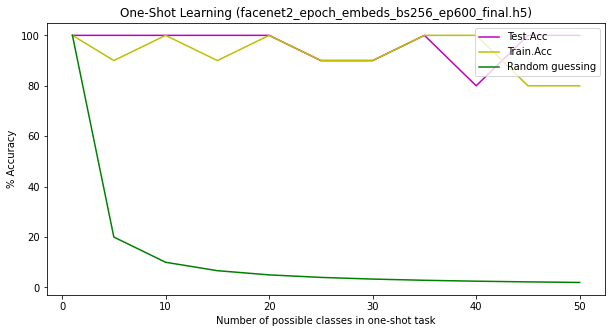

test 16 - model: facenet1_batch_embeds_bs256_ep600_test_best.h5
[[0.6671571]] 0 0
[[0.6138467]] 0 0
[[0.6697696]] 0 0
[[0.7047086]] 0 0
[[0.7046469]] 0 0
[[0.71545845]] 0 0
[[0.5986165]] 0 0
[[0.5589702]] 0 0
[[0.42164633]] 0 0
[[0.5699116]] 0 0
[[0.43926713]] 0 0
[[0.6702315]] 0 0
[[0.48496744]] 0 0
[[0.6417609]] 0 0
[[0.49348742]] 0 0
[[0.6416091]] 0 0
[[0.5031847]] 0 0
[[0.5089745]] 0 0
[[0.55256623]] 0 0
[[0.61999905]] 0 0
[[0.4249717 ]
 [0.41957334]
 [0.3862694 ]
 [0.7157049 ]
 [0.40406126]] 3 3
[[0.6494875 ]
 [0.3924693 ]
 [0.40389195]
 [0.4099145 ]
 [0.38686037]] 0 0
[[0.65882814]
 [0.4195227 ]
 [0.43410435]
 [0.38403758]
 [0.39302635]] 0 0
[[0.38344467]
 [0.4945502 ]
 [0.38286236]
 [0.37157157]
 [0.4022565 ]] 1 1
[[0.46585292]
 [0.42097786]
 [0.37829423]
 [0.39487323]
 [0.39783007]] 0 0
[[0.72064143]
 [0.4217139 ]
 [0.39275202]
 [0.42438397]
 [0.38925546]] 0 0
[[0.4231791 ]
 [0.45004082]
 [0.3796399 ]
 [0.42414793]
 [0.5989204 ]] 4 4
[[0.3958043 ]
 [0.58612096]
 [0.4079363 ]
 [

 [0.38571393]] 2 2
[[0.38625696]
 [0.4064865 ]
 [0.40207803]
 [0.38519162]
 [0.67065364]
 [0.42969874]
 [0.4199158 ]
 [0.4068331 ]
 [0.41726628]
 [0.3731179 ]
 [0.3896817 ]
 [0.4059212 ]
 [0.3955986 ]
 [0.43934688]
 [0.40014127]] 4 4
[[0.40500522]
 [0.42236283]
 [0.39595172]
 [0.40304598]
 [0.40033433]
 [0.394581  ]
 [0.38913232]
 [0.39538524]
 [0.37613302]
 [0.39871395]
 [0.63952655]
 [0.40806213]
 [0.40244177]
 [0.4267298 ]
 [0.40443817]] 10 10
[[0.42290768]
 [0.38562727]
 [0.40897566]
 [0.3962175 ]
 [0.45072547]
 [0.4234829 ]
 [0.403061  ]
 [0.40802187]
 [0.41610608]
 [0.38428268]
 [0.40062538]
 [0.6918209 ]
 [0.42102352]
 [0.4376356 ]
 [0.41506097]] 11 11
[[0.40289724]
 [0.42177007]
 [0.440752  ]
 [0.38805896]
 [0.4102317 ]
 [0.42859578]
 [0.40965042]
 [0.42015088]
 [0.38650432]
 [0.43225747]
 [0.38917282]
 [0.43287748]
 [0.38486126]
 [0.41456527]
 [0.3914396 ]] 2 13
[[0.40124953]
 [0.423148  ]
 [0.5297351 ]
 [0.4022749 ]
 [0.4468004 ]
 [0.485213  ]
 [0.42021024]
 [0.39448732]
 [0.

[[0.4151482 ]
 [0.41348606]
 [0.38564566]
 [0.37227124]
 [0.37917572]
 [0.39815426]
 [0.39236465]
 [0.38842928]
 [0.42316684]
 [0.39250445]
 [0.39236906]
 [0.4063532 ]
 [0.39015368]
 [0.39441067]
 [0.4168839 ]
 [0.41152334]
 [0.3938173 ]
 [0.4159668 ]
 [0.40324664]
 [0.39917392]
 [0.38513917]
 [0.38252366]
 [0.669606  ]
 [0.396703  ]
 [0.41625166]] 22 22
[[0.4479664 ]
 [0.40722442]
 [0.39439362]
 [0.40360403]
 [0.4770597 ]
 [0.4610775 ]
 [0.40650725]
 [0.41838488]
 [0.42424974]
 [0.4315951 ]
 [0.39646727]
 [0.4257994 ]
 [0.3984723 ]
 [0.41227326]
 [0.43763614]
 [0.41358238]
 [0.5926502 ]
 [0.39380464]
 [0.4143147 ]
 [0.4051729 ]
 [0.40351483]
 [0.42429137]
 [0.38660273]
 [0.38931406]
 [0.3995133 ]] 16 16
[[0.4075653 ]
 [0.3959379 ]
 [0.39017773]
 [0.46122152]
 [0.40859526]
 [0.42607325]
 [0.39162046]
 [0.4354876 ]
 [0.39159894]
 [0.43460512]
 [0.37894556]
 [0.44411188]
 [0.40090725]
 [0.37262505]
 [0.39722714]
 [0.38649914]
 [0.38878807]
 [0.39362285]
 [0.41233355]
 [0.3745762 ]
 [0.39

[[0.43109035]
 [0.38971612]
 [0.39251754]
 [0.40940347]
 [0.4039685 ]
 [0.39451456]
 [0.39803877]
 [0.42030317]
 [0.41102093]
 [0.42941645]
 [0.41649708]
 [0.40847072]
 [0.50897443]
 [0.4128049 ]
 [0.4192782 ]
 [0.4144039 ]
 [0.4052441 ]
 [0.42239112]
 [0.41372123]
 [0.43072963]
 [0.408202  ]
 [0.3993396 ]
 [0.39858747]
 [0.41618305]
 [0.44918495]
 [0.41184628]
 [0.4122497 ]
 [0.42935345]
 [0.4075685 ]
 [0.4014853 ]] 12 12
[[0.41802692]
 [0.40515226]
 [0.42337823]
 [0.4406045 ]
 [0.41424632]
 [0.4531048 ]
 [0.50897443]
 [0.43725097]
 [0.42371714]
 [0.42488685]
 [0.4058048 ]
 [0.40366322]
 [0.40287122]
 [0.42439896]
 [0.42791575]
 [0.4074759 ]
 [0.3972666 ]
 [0.42122728]
 [0.4072979 ]
 [0.4177754 ]
 [0.42249262]
 [0.42997962]
 [0.44662198]
 [0.40401104]
 [0.45883396]
 [0.41864678]
 [0.40294984]
 [0.42021006]
 [0.42387193]
 [0.41479748]] 6 6
[[0.42300552]
 [0.40186957]
 [0.42912245]
 [0.41189024]
 [0.43033585]
 [0.44453388]
 [0.40105492]
 [0.59377766]
 [0.42613697]
 [0.41341415]
 [0.4096

[[0.40044785]
 [0.40190664]
 [0.3739651 ]
 [0.6023308 ]
 [0.38018084]
 [0.38976455]
 [0.4211113 ]
 [0.43156382]
 [0.38712242]
 [0.42103356]
 [0.4058685 ]
 [0.39753973]
 [0.38509196]
 [0.39161646]
 [0.4089305 ]
 [0.38616896]
 [0.40990543]
 [0.3866347 ]
 [0.37572682]
 [0.4027191 ]
 [0.41125524]
 [0.39179352]
 [0.3822841 ]
 [0.40660676]
 [0.44175607]
 [0.39415044]
 [0.37908417]
 [0.41571003]
 [0.4111516 ]
 [0.40065956]
 [0.40732807]
 [0.3819959 ]
 [0.41899285]
 [0.3826477 ]
 [0.4056355 ]] 3 3
[[0.41304106]
 [0.3945327 ]
 [0.4059015 ]
 [0.41027862]
 [0.41793394]
 [0.4109717 ]
 [0.40024954]
 [0.40664685]
 [0.40060598]
 [0.4104961 ]
 [0.42800438]
 [0.43043593]
 [0.4182869 ]
 [0.4514905 ]
 [0.4089344 ]
 [0.42181194]
 [0.4551829 ]
 [0.6726457 ]
 [0.42371714]
 [0.40772742]
 [0.43270877]
 [0.4022024 ]
 [0.4489885 ]
 [0.40399715]
 [0.40393114]
 [0.41876534]
 [0.40866196]
 [0.40238178]
 [0.39369076]
 [0.45340443]
 [0.4451508 ]
 [0.44721246]
 [0.41867912]
 [0.41132724]
 [0.42582786]] 17 17
[[0.3898

[[0.42917454]
 [0.44059503]
 [0.69880795]
 [0.38693783]
 [0.41832805]
 [0.3909185 ]
 [0.40207386]
 [0.3904877 ]
 [0.39426672]
 [0.37802932]
 [0.39461228]
 [0.4153857 ]
 [0.39782488]
 [0.4309634 ]
 [0.39312932]
 [0.39774835]
 [0.37811345]
 [0.38462085]
 [0.38554838]
 [0.4537044 ]
 [0.37483272]
 [0.4013356 ]
 [0.39271727]
 [0.40400845]
 [0.40034482]
 [0.40036106]
 [0.38623548]
 [0.39100128]
 [0.40501475]
 [0.38263908]
 [0.39228383]
 [0.4022589 ]
 [0.4161247 ]
 [0.3832193 ]
 [0.43456963]
 [0.3920077 ]
 [0.39376464]
 [0.406443  ]
 [0.37847808]
 [0.40101767]] 2 2
[[0.412065  ]
 [0.42971262]
 [0.40286186]
 [0.39438593]
 [0.41761   ]
 [0.37435067]
 [0.40629566]
 [0.44857872]
 [0.39196396]
 [0.4070275 ]
 [0.38665774]
 [0.4131699 ]
 [0.4033159 ]
 [0.40809426]
 [0.39727718]
 [0.40548268]
 [0.6272449 ]
 [0.41799027]
 [0.38802162]
 [0.4035887 ]
 [0.4419655 ]
 [0.424137  ]
 [0.3788453 ]
 [0.42527872]
 [0.41930112]
 [0.41429606]
 [0.43892878]
 [0.3990031 ]
 [0.39752617]
 [0.40365428]
 [0.40066016]
 

[[0.39966136]
 [0.3915941 ]
 [0.39010483]
 [0.42161825]
 [0.43014902]
 [0.38798094]
 [0.41513926]
 [0.39551252]
 [0.43751714]
 [0.4062538 ]
 [0.41936684]
 [0.405409  ]
 [0.40916926]
 [0.41423115]
 [0.38167572]
 [0.4080555 ]
 [0.38606232]
 [0.39688936]
 [0.4195565 ]
 [0.4471991 ]
 [0.39437014]
 [0.4062788 ]
 [0.36938477]
 [0.37848318]
 [0.40550578]
 [0.39396736]
 [0.38437164]
 [0.40030423]
 [0.39733514]
 [0.39795977]
 [0.40841347]
 [0.37977034]
 [0.43507075]
 [0.41167578]
 [0.41471207]
 [0.40388215]
 [0.65184677]
 [0.4086313 ]
 [0.38834924]
 [0.43265682]
 [0.3932877 ]
 [0.39167526]
 [0.40126497]
 [0.40536347]
 [0.41759384]] 36 36
[[0.43711174]
 [0.39779782]
 [0.40153408]
 [0.45930094]
 [0.4017275 ]
 [0.41074085]
 [0.41877726]
 [0.41288093]
 [0.38534516]
 [0.42269725]
 [0.39127   ]
 [0.3912002 ]
 [0.38377386]
 [0.3831037 ]
 [0.3887248 ]
 [0.38135436]
 [0.37845644]
 [0.41402027]
 [0.37638438]
 [0.37849027]
 [0.38642526]
 [0.38812935]
 [0.39927396]
 [0.38864493]
 [0.40135068]
 [0.39217946]

[[0.41621327]
 [0.42669454]
 [0.42512906]
 [0.42544067]
 [0.406402  ]
 [0.42002332]
 [0.4254071 ]
 [0.45634577]
 [0.45956716]
 [0.46519902]
 [0.41820008]
 [0.38774902]
 [0.4301389 ]
 [0.5536713 ]
 [0.4324788 ]
 [0.39923185]
 [0.41403168]
 [0.43459818]
 [0.3853505 ]
 [0.44291693]
 [0.4450684 ]
 [0.45155132]
 [0.44719583]
 [0.41754016]
 [0.42128763]
 [0.4271624 ]
 [0.42844477]
 [0.4611316 ]
 [0.42162386]
 [0.40179306]
 [0.40990376]
 [0.41348052]
 [0.43854287]
 [0.4145234 ]
 [0.38930362]
 [0.4181323 ]
 [0.44336113]
 [0.41890728]
 [0.525893  ]
 [0.45618978]
 [0.42752826]
 [0.4304761 ]
 [0.41495246]
 [0.44036895]
 [0.5340954 ]
 [0.41347247]
 [0.41958672]
 [0.40277272]
 [0.53418744]
 [0.45545092]] 13 44
[[0.40224755]
 [0.3932766 ]
 [0.39576304]
 [0.38630414]
 [0.412256  ]
 [0.40297127]
 [0.408903  ]
 [0.41575345]
 [0.38253736]
 [0.38121566]
 [0.41519275]
 [0.43054634]
 [0.40323225]
 [0.42444462]
 [0.40269482]
 [0.39285693]
 [0.38311294]
 [0.40511963]
 [0.4653741 ]
 [0.40749538]
 [0.40991613]

[[0.42468864]
 [0.46148467]
 [0.41375455]
 [0.40459618]
 [0.41831622]
 [0.4430125 ]
 [0.41258362]
 [0.40261197]
 [0.39876318]
 [0.4073213 ]
 [0.42851633]
 [0.41537276]
 [0.43746123]
 [0.4196574 ]
 [0.47008315]
 [0.43996277]
 [0.39998877]
 [0.4432817 ]
 [0.39686394]
 [0.40372744]
 [0.47078437]
 [0.39761055]
 [0.41642967]
 [0.4452478 ]
 [0.41557306]
 [0.4158084 ]
 [0.5183776 ]
 [0.39601737]
 [0.42820197]
 [0.43948135]
 [0.39634803]
 [0.4147218 ]
 [0.4082194 ]
 [0.39617938]
 [0.46722615]
 [0.4192335 ]
 [0.43425652]
 [0.40224934]
 [0.3909416 ]
 [0.42154717]
 [0.40185922]
 [0.39844048]
 [0.42592964]
 [0.42864734]
 [0.3937501 ]
 [0.46031106]
 [0.43495542]
 [0.4529052 ]
 [0.40967777]
 [0.45632282]] 26 26


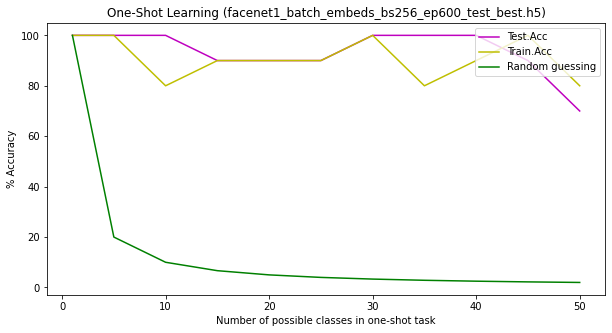

test 17 - model: facenet1_batch_embeds_bs256_ep600_nway_best.h5
[[0.5092481]] 0 0
[[0.5358599]] 0 0
[[0.5137655]] 0 0
[[0.50780153]] 0 0
[[0.54483646]] 0 0
[[0.4796718]] 0 0
[[0.5397198]] 0 0
[[0.578615]] 0 0
[[0.5671358]] 0 0
[[0.48611102]] 0 0
[[0.5549127]] 0 0
[[0.48787883]] 0 0
[[0.5549127]] 0 0
[[0.55881655]] 0 0
[[0.47620618]] 0 0
[[0.5427828]] 0 0
[[0.45898846]] 0 0
[[0.57123953]] 0 0
[[0.55571073]] 0 0
[[0.50439125]] 0 0
[[0.40502205]
 [0.38653207]
 [0.3940633 ]
 [0.54988486]
 [0.38626203]] 3 3
[[0.48209813]
 [0.4170767 ]
 [0.3945296 ]
 [0.39354202]
 [0.42217267]] 0 0
[[0.40618908]
 [0.41934335]
 [0.37931776]
 [0.5595862 ]
 [0.3877175 ]] 3 3
[[0.3806961 ]
 [0.38563618]
 [0.40358043]
 [0.51315945]
 [0.401973  ]] 3 3
[[0.6223905 ]
 [0.44811308]
 [0.44464   ]
 [0.44254217]
 [0.44683835]] 0 0
[[0.38852635]
 [0.38083372]
 [0.36290714]
 [0.39557886]
 [0.5111124 ]] 4 4
[[0.3852464 ]
 [0.38733277]
 [0.44074148]
 [0.3782819 ]
 [0.4899659 ]] 4 4
[[0.37588474]
 [0.57723796]
 [0.38227272]


[[0.38648072]
 [0.40709287]
 [0.38981867]
 [0.39415187]
 [0.4202095 ]
 [0.38331425]
 [0.3915936 ]
 [0.3849135 ]
 [0.39849293]
 [0.40042254]
 [0.54735523]
 [0.41082615]
 [0.413084  ]
 [0.39445353]
 [0.3853211 ]
 [0.40244836]
 [0.38641623]
 [0.3829358 ]
 [0.40394792]
 [0.38813925]] 10 10
[[0.38117346]
 [0.38443458]
 [0.3894739 ]
 [0.39255762]
 [0.41103902]
 [0.4073399 ]
 [0.39784124]
 [0.45289406]
 [0.39335075]
 [0.40343395]
 [0.4035495 ]
 [0.38027808]
 [0.43678614]
 [0.40320534]
 [0.3815178 ]
 [0.39622003]
 [0.4031557 ]
 [0.41841558]
 [0.3823909 ]
 [0.4063235 ]] 7 7
[[0.3865576 ]
 [0.39254454]
 [0.3953527 ]
 [0.3752042 ]
 [0.38889214]
 [0.3753224 ]
 [0.38295805]
 [0.39243495]
 [0.39059964]
 [0.38980207]
 [0.38377637]
 [0.39693534]
 [0.40110606]
 [0.39557433]
 [0.4049096 ]
 [0.3957396 ]
 [0.38808227]
 [0.50975084]
 [0.3911568 ]
 [0.38847026]] 17 17
[[0.41044274]
 [0.37844712]
 [0.36902857]
 [0.36919457]
 [0.38198003]
 [0.607847  ]
 [0.36758804]
 [0.40992105]
 [0.3990816 ]
 [0.36551076]
 

[[0.41232997]
 [0.39776343]
 [0.41440237]
 [0.41006625]
 [0.40188926]
 [0.4186992 ]
 [0.3955384 ]
 [0.4083882 ]
 [0.42509985]
 [0.39626014]
 [0.38746098]
 [0.43755734]
 [0.3950665 ]
 [0.4245898 ]
 [0.41039392]
 [0.41060975]
 [0.39391282]
 [0.4344514 ]
 [0.5810797 ]
 [0.40328988]
 [0.4290709 ]
 [0.37713295]
 [0.39422864]
 [0.40868104]
 [0.3840603 ]] 18 18
[[0.3873589 ]
 [0.39792824]
 [0.41196486]
 [0.4056693 ]
 [0.4002543 ]
 [0.39447272]
 [0.39899027]
 [0.38188145]
 [0.3746309 ]
 [0.4009216 ]
 [0.40875474]
 [0.4082732 ]
 [0.40424043]
 [0.39007512]
 [0.41253525]
 [0.38156503]
 [0.3896225 ]
 [0.4293809 ]
 [0.3802145 ]
 [0.40116072]
 [0.39055485]
 [0.37922242]
 [0.3985183 ]
 [0.40921974]
 [0.54811376]] 24 24
[[0.43074745]
 [0.389046  ]
 [0.38167968]
 [0.3979254 ]
 [0.37762237]
 [0.38012478]
 [0.42506433]
 [0.3794088 ]
 [0.38855416]
 [0.40245456]
 [0.42628026]
 [0.38535646]
 [0.3875241 ]
 [0.38446587]
 [0.3849002 ]
 [0.39180848]
 [0.39298132]
 [0.39837304]
 [0.3946817 ]
 [0.41295296]
 [0.38

[[0.38690692]
 [0.37605315]
 [0.3998143 ]
 [0.3842391 ]
 [0.38876933]
 [0.47715428]
 [0.39449853]
 [0.38242432]
 [0.38713422]
 [0.3908586 ]
 [0.3946656 ]
 [0.40330362]
 [0.41382793]
 [0.4104688 ]
 [0.40303528]
 [0.39361626]
 [0.39815024]
 [0.39602202]
 [0.39635244]
 [0.38842762]
 [0.41475844]
 [0.383204  ]
 [0.4083088 ]
 [0.39100105]
 [0.38606972]
 [0.39743897]
 [0.38023803]
 [0.39359662]
 [0.42680073]
 [0.39591384]] 5 5
[[0.3782706 ]
 [0.3834128 ]
 [0.38124198]
 [0.37611657]
 [0.37678844]
 [0.3805678 ]
 [0.36319312]
 [0.3777332 ]
 [0.43531415]
 [0.3788817 ]
 [0.39876178]
 [0.3640025 ]
 [0.3878261 ]
 [0.38558558]
 [0.39696467]
 [0.39844674]
 [0.41630304]
 [0.36821002]
 [0.39194608]
 [0.39986864]
 [0.38946676]
 [0.39393437]
 [0.41323832]
 [0.36780936]
 [0.38080165]
 [0.40271667]
 [0.3722055 ]
 [0.37962258]
 [0.41232115]
 [0.47602513]] 29 29
[[0.3960939 ]
 [0.38584155]
 [0.39472196]
 [0.39252397]
 [0.41173607]
 [0.39654112]
 [0.3925132 ]
 [0.401633  ]
 [0.40804762]
 [0.38121346]
 [0.3868

[[0.38731545]
 [0.3843168 ]
 [0.38036877]
 [0.38682503]
 [0.3883521 ]
 [0.3927839 ]
 [0.38517615]
 [0.3979198 ]
 [0.4008658 ]
 [0.4650594 ]
 [0.37301123]
 [0.40782747]
 [0.4151382 ]
 [0.3980366 ]
 [0.39565307]
 [0.40489483]
 [0.4166519 ]
 [0.40451986]
 [0.39462543]
 [0.40100333]
 [0.40636206]
 [0.38381508]
 [0.39253336]
 [0.40785158]
 [0.4162146 ]
 [0.3809408 ]
 [0.3972814 ]
 [0.39677578]
 [0.40753412]
 [0.41817844]
 [0.38758123]
 [0.38610983]
 [0.3753566 ]
 [0.5332167 ]
 [0.40942147]] 33 33
[[0.4017588 ]
 [0.40369314]
 [0.42097497]
 [0.39595696]
 [0.4212714 ]
 [0.39872828]
 [0.5590166 ]
 [0.3900304 ]
 [0.43087044]
 [0.40146026]
 [0.4121555 ]
 [0.39113814]
 [0.40343916]
 [0.4037513 ]
 [0.40235373]
 [0.39332557]
 [0.4398051 ]
 [0.38206574]
 [0.3879068 ]
 [0.38497037]
 [0.40939674]
 [0.42537913]
 [0.39799616]
 [0.4386107 ]
 [0.395412  ]
 [0.40492108]
 [0.42974943]
 [0.4030699 ]
 [0.3923092 ]
 [0.4141971 ]
 [0.3939209 ]
 [0.401223  ]
 [0.4197941 ]
 [0.43026072]
 [0.391535  ]] 6 6
[[0.3834

[[0.39261377]
 [0.39337108]
 [0.40229338]
 [0.38904816]
 [0.39534646]
 [0.38569194]
 [0.4030764 ]
 [0.5481137 ]
 [0.40580043]
 [0.3986253 ]
 [0.37018377]
 [0.39758122]
 [0.39237675]
 [0.38637593]
 [0.38423163]
 [0.39187956]
 [0.39845768]
 [0.37076563]
 [0.39371002]
 [0.3964082 ]
 [0.37527454]
 [0.37587857]
 [0.38999152]
 [0.42444712]
 [0.37518162]
 [0.38333324]
 [0.4227275 ]
 [0.37769434]
 [0.39954945]
 [0.40751997]
 [0.40816242]
 [0.41407827]
 [0.39742664]
 [0.40090525]
 [0.37573674]
 [0.39518788]
 [0.39166653]
 [0.40151224]
 [0.39821047]
 [0.4156829 ]] 7 7
[[0.38672385]
 [0.4072555 ]
 [0.3750515 ]
 [0.38990664]
 [0.37847   ]
 [0.39182693]
 [0.39567125]
 [0.3976057 ]
 [0.42195195]
 [0.3852489 ]
 [0.39534944]
 [0.39940694]
 [0.4184125 ]
 [0.37155044]
 [0.386426  ]
 [0.40824172]
 [0.4070916 ]
 [0.3706482 ]
 [0.38277197]
 [0.3887996 ]
 [0.4027121 ]
 [0.4191203 ]
 [0.402573  ]
 [0.4178814 ]
 [0.37891662]
 [0.39729407]
 [0.3815392 ]
 [0.41147807]
 [0.39499438]
 [0.37117806]
 [0.39926234]
 

[[0.40223598]
 [0.38879764]
 [0.38787133]
 [0.41241008]
 [0.39710793]
 [0.38905448]
 [0.39770633]
 [0.40103567]
 [0.4023718 ]
 [0.3968184 ]
 [0.3887707 ]
 [0.3768669 ]
 [0.44529068]
 [0.43448126]
 [0.40642354]
 [0.38102552]
 [0.4041843 ]
 [0.41126573]
 [0.40464437]
 [0.41501752]
 [0.4018271 ]
 [0.40795717]
 [0.4136304 ]
 [0.388335  ]
 [0.4070079 ]
 [0.39112622]
 [0.39315927]
 [0.37073588]
 [0.5226372 ]
 [0.40584087]
 [0.39853966]
 [0.4088004 ]
 [0.41463006]
 [0.3824564 ]
 [0.38520053]
 [0.3698932 ]
 [0.38921192]
 [0.408397  ]
 [0.4297343 ]
 [0.37291488]
 [0.4021816 ]
 [0.37999246]
 [0.41284442]
 [0.37871245]
 [0.37670544]] 28 28
[[0.40896899]
 [0.38584813]
 [0.3922273 ]
 [0.38088053]
 [0.3910418 ]
 [0.3932696 ]
 [0.37910014]
 [0.38576388]
 [0.39059693]
 [0.369821  ]
 [0.3875646 ]
 [0.4521932 ]
 [0.37804282]
 [0.3729486 ]
 [0.39140218]
 [0.4111309 ]
 [0.39291137]
 [0.39409146]
 [0.39077488]
 [0.38707983]
 [0.3918818 ]
 [0.3792988 ]
 [0.4027084 ]
 [0.4190833 ]
 [0.39051852]
 [0.4337357 ]

[[0.3972184 ]
 [0.38437676]
 [0.4062747 ]
 [0.4066406 ]
 [0.3921866 ]
 [0.38957074]
 [0.37684178]
 [0.40387562]
 [0.39499944]
 [0.41622883]
 [0.38848987]
 [0.401081  ]
 [0.3811867 ]
 [0.3971604 ]
 [0.3712747 ]
 [0.4101551 ]
 [0.3792755 ]
 [0.38951525]
 [0.39909068]
 [0.39281753]
 [0.39705494]
 [0.3761264 ]
 [0.39653578]
 [0.38920054]
 [0.37253588]
 [0.3970911 ]
 [0.388554  ]
 [0.40621793]
 [0.41068304]
 [0.38969165]
 [0.38584304]
 [0.39676476]
 [0.39769617]
 [0.3925789 ]
 [0.38158885]
 [0.3828231 ]
 [0.38936874]
 [0.38579273]
 [0.39561427]
 [0.39571464]
 [0.39906073]
 [0.4155287 ]
 [0.39559928]
 [0.4126907 ]
 [0.41359657]
 [0.38416088]
 [0.37870544]
 [0.3886642 ]
 [0.37924498]
 [0.39128387]] 9 21
[[0.41041782]
 [0.39392525]
 [0.45030862]
 [0.44018674]
 [0.38955963]
 [0.38482398]
 [0.3800192 ]
 [0.3930707 ]
 [0.3984706 ]
 [0.4281515 ]
 [0.39393473]
 [0.40557924]
 [0.42375803]
 [0.4222183 ]
 [0.3831892 ]
 [0.36924446]
 [0.4022946 ]
 [0.3819859 ]
 [0.41726953]
 [0.38151646]
 [0.4043004 ]


[[0.38836965]
 [0.39361975]
 [0.3888358 ]
 [0.3963554 ]
 [0.3948481 ]
 [0.3749705 ]
 [0.3925969 ]
 [0.38091987]
 [0.39100626]
 [0.4095188 ]
 [0.3755568 ]
 [0.38969564]
 [0.3934278 ]
 [0.38948444]
 [0.3929963 ]
 [0.3785823 ]
 [0.41025552]
 [0.38886648]
 [0.394329  ]
 [0.37730742]
 [0.40260813]
 [0.39351803]
 [0.41134542]
 [0.39360502]
 [0.41780066]
 [0.38920537]
 [0.39677173]
 [0.3899344 ]
 [0.39057243]
 [0.38641736]
 [0.40022087]
 [0.3978605 ]
 [0.403684  ]
 [0.39937648]
 [0.38866392]
 [0.4275539 ]
 [0.3857758 ]
 [0.399701  ]
 [0.55965495]
 [0.40150777]
 [0.38473597]
 [0.41314948]
 [0.3922915 ]
 [0.4329763 ]
 [0.39352247]
 [0.3869866 ]
 [0.390863  ]
 [0.39136124]
 [0.39780307]
 [0.413537  ]] 38 38
[[0.38569447]
 [0.38774285]
 [0.39130518]
 [0.40161878]
 [0.4020687 ]
 [0.39074606]
 [0.38719133]
 [0.39078224]
 [0.411364  ]
 [0.36789685]
 [0.3752601 ]
 [0.384349  ]
 [0.37509784]
 [0.38100946]
 [0.3887937 ]
 [0.37827247]
 [0.39423403]
 [0.37066   ]
 [0.39521155]
 [0.3852793 ]
 [0.38787055]

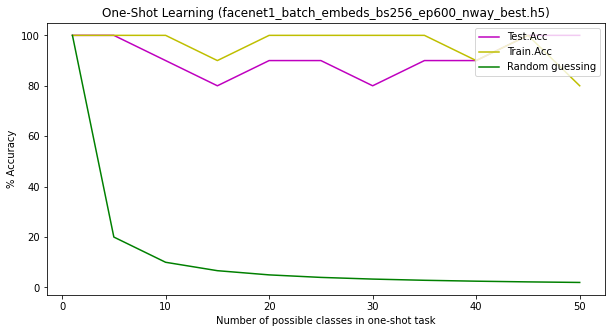

test 18 - model: face_recognition_batch_embeds_bs256_ep600_test_best.h5
[[0.50429696]] 0 0
[[0.7054571]] 0 0
[[0.5973411]] 0 0
[[0.6549077]] 0 0
[[0.6932541]] 0 0
[[0.49795702]] 0 0
[[0.6778366]] 0 0
[[0.62975025]] 0 0
[[0.71327573]] 0 0
[[0.6671681]] 0 0
[[0.5323031]] 0 0
[[0.6372548]] 0 0
[[0.48045373]] 0 0
[[0.6728849]] 0 0
[[0.6939485]] 0 0
[[0.61724794]] 0 0
[[0.68702716]] 0 0
[[0.4617731]] 0 0
[[0.59616363]] 0 0
[[0.6878796]] 0 0
[[0.3714006 ]
 [0.7169962 ]
 [0.44745514]
 [0.37736526]
 [0.34308186]] 1 1
[[0.37135777]
 [0.6216242 ]
 [0.33721235]
 [0.3051195 ]
 [0.3381575 ]] 1 1
[[0.62025917]
 [0.324257  ]
 [0.3925028 ]
 [0.32788053]
 [0.3225249 ]] 0 0
[[0.6288709 ]
 [0.31239116]
 [0.27394107]
 [0.37556818]
 [0.30509883]] 0 0
[[0.33310527]
 [0.38785952]
 [0.4350683 ]
 [0.6134422 ]
 [0.4972986 ]] 3 3
[[0.37278652]
 [0.4385945 ]
 [0.45965478]
 [0.69206697]
 [0.44287217]] 3 3
[[0.6432355 ]
 [0.3098451 ]
 [0.52255267]
 [0.29996598]
 [0.47603464]] 0 0
[[0.5347774 ]
 [0.31589472]
 [0.442

[[0.33026382]
 [0.46766263]
 [0.46446085]
 [0.4290997 ]
 [0.44602728]
 [0.31428003]
 [0.46183637]
 [0.4014601 ]
 [0.51170194]
 [0.48133227]
 [0.46127114]
 [0.4123486 ]
 [0.45943192]
 [0.49662098]
 [0.49325147]
 [0.4536258 ]
 [0.45073518]
 [0.66595894]
 [0.47657785]
 [0.46902868]] 17 17
[[0.39988106]
 [0.41784605]
 [0.41935644]
 [0.51111895]
 [0.3572801 ]
 [0.39527163]
 [0.43550265]
 [0.47802985]
 [0.343038  ]
 [0.38161832]
 [0.41984466]
 [0.37796777]
 [0.51610094]
 [0.39090404]
 [0.46522596]
 [0.45913935]
 [0.41927597]
 [0.47674745]
 [0.46464458]
 [0.377594  ]] 12 0
[[0.40450558]
 [0.4383888 ]
 [0.4390033 ]
 [0.39153683]
 [0.31729364]
 [0.4333006 ]
 [0.491679  ]
 [0.47823644]
 [0.42607018]
 [0.43612516]
 [0.345267  ]
 [0.4745803 ]
 [0.39838248]
 [0.44703096]
 [0.648792  ]
 [0.33004612]
 [0.331462  ]
 [0.31934735]
 [0.36181143]
 [0.37540272]] 14 14
[[0.3740456 ]
 [0.5151483 ]
 [0.32015806]
 [0.31147748]
 [0.43661353]
 [0.41287416]
 [0.43003914]
 [0.4678073 ]
 [0.488579  ]
 [0.45759925]


[[0.37928396]
 [0.45363152]
 [0.4049381 ]
 [0.41188997]
 [0.39365935]
 [0.45042008]
 [0.47311223]
 [0.26926917]
 [0.44991317]
 [0.3896117 ]
 [0.419454  ]
 [0.50928587]
 [0.44183692]
 [0.4224832 ]
 [0.39743608]
 [0.42290515]
 [0.43563092]
 [0.45247254]
 [0.40840387]
 [0.394665  ]
 [0.4452793 ]
 [0.3903834 ]
 [0.47187477]
 [0.50279015]
 [0.45015684]] 11 23
[[0.5016366 ]
 [0.48335937]
 [0.436682  ]
 [0.5035947 ]
 [0.40107217]
 [0.48638633]
 [0.4991796 ]
 [0.42900568]
 [0.40332037]
 [0.42255682]
 [0.4103749 ]
 [0.3706293 ]
 [0.48141444]
 [0.4637171 ]
 [0.41281682]
 [0.619772  ]
 [0.44774193]
 [0.44726086]
 [0.4555218 ]
 [0.42253038]
 [0.3991476 ]
 [0.43843132]
 [0.38159353]
 [0.47395504]
 [0.4079686 ]] 15 15
[[0.28516695]
 [0.35273963]
 [0.3516923 ]
 [0.3362101 ]
 [0.32871598]
 [0.24894533]
 [0.6342983 ]
 [0.26261693]
 [0.28765765]
 [0.27706295]
 [0.3444001 ]
 [0.37526703]
 [0.33904722]
 [0.34558308]
 [0.32412905]
 [0.37366736]
 [0.29541588]
 [0.29573607]
 [0.33917832]
 [0.34403557]
 [0.32

[[0.47187656]
 [0.57545704]
 [0.44066408]
 [0.45621592]
 [0.52948475]
 [0.4148461 ]
 [0.38112178]
 [0.4219246 ]
 [0.460875  ]
 [0.358595  ]
 [0.50783014]
 [0.39127254]
 [0.4412494 ]
 [0.46135494]
 [0.38171482]
 [0.3839919 ]
 [0.49505344]
 [0.38151297]
 [0.4924206 ]
 [0.3963244 ]
 [0.38889003]
 [0.5069289 ]
 [0.426651  ]
 [0.46430153]
 [0.43173555]
 [0.41232148]
 [0.4006967 ]
 [0.43037483]
 [0.4854523 ]
 [0.4490029 ]] 1 1
[[0.345889  ]
 [0.38644242]
 [0.41666612]
 [0.42404783]
 [0.31049913]
 [0.38367254]
 [0.33992523]
 [0.44257143]
 [0.4819038 ]
 [0.46103516]
 [0.37220705]
 [0.3359558 ]
 [0.37453827]
 [0.40796235]
 [0.3924388 ]
 [0.42958415]
 [0.3764032 ]
 [0.38894564]
 [0.36311546]
 [0.49001095]
 [0.4486796 ]
 [0.48595077]
 [0.40982062]
 [0.3920349 ]
 [0.3493981 ]
 [0.36711589]
 [0.44881538]
 [0.43014956]
 [0.29935187]
 [0.48272222]] 19 29
[[0.38171333]
 [0.48005635]
 [0.37009603]
 [0.45199132]
 [0.6172479 ]
 [0.3601396 ]
 [0.34268296]
 [0.40409005]
 [0.342717  ]
 [0.36770123]
 [0.4202

[[0.42804474]
 [0.3378837 ]
 [0.38786632]
 [0.3187746 ]
 [0.37214392]
 [0.49743295]
 [0.39958578]
 [0.44468874]
 [0.34672338]
 [0.32377547]
 [0.39095387]
 [0.329157  ]
 [0.34014434]
 [0.4048221 ]
 [0.347465  ]
 [0.32995123]
 [0.33872   ]
 [0.41444868]
 [0.39914   ]
 [0.4089028 ]
 [0.36815906]
 [0.4203739 ]
 [0.34319323]
 [0.3944612 ]
 [0.34972152]
 [0.3368821 ]
 [0.44159704]
 [0.38519004]
 [0.41054413]
 [0.320136  ]
 [0.6985114 ]
 [0.5282427 ]
 [0.41288993]
 [0.3694511 ]
 [0.3106793 ]] 30 30
[[0.3547579 ]
 [0.40195644]
 [0.42030454]
 [0.34367734]
 [0.6673861 ]
 [0.4402369 ]
 [0.3441682 ]
 [0.47549435]
 [0.48644897]
 [0.4108967 ]
 [0.3856774 ]
 [0.37461233]
 [0.3747267 ]
 [0.4819909 ]
 [0.3787775 ]
 [0.47147563]
 [0.4757196 ]
 [0.3476185 ]
 [0.38752025]
 [0.5189017 ]
 [0.35960054]
 [0.47958872]
 [0.5196552 ]
 [0.43517646]
 [0.35007888]
 [0.37970412]
 [0.3708076 ]
 [0.39444727]
 [0.49570984]
 [0.39125684]
 [0.43516493]
 [0.48299322]
 [0.37085518]
 [0.39172122]
 [0.37558848]] 4 4
[[0.4689

[[0.4605036 ]
 [0.39375323]
 [0.34881765]
 [0.33048588]
 [0.49840897]
 [0.54568547]
 [0.40713528]
 [0.32636347]
 [0.3996715 ]
 [0.34040374]
 [0.38923064]
 [0.4392905 ]
 [0.39648634]
 [0.42182028]
 [0.42175734]
 [0.3179403 ]
 [0.32977784]
 [0.35603422]
 [0.41148993]
 [0.4082263 ]
 [0.39855254]
 [0.500176  ]
 [0.46960998]
 [0.36400944]
 [0.4119117 ]
 [0.4182879 ]
 [0.41717303]
 [0.34868282]
 [0.46256587]
 [0.33864886]
 [0.45139843]
 [0.36149755]
 [0.6907012 ]
 [0.37962404]
 [0.43922305]
 [0.4693098 ]
 [0.315854  ]
 [0.38349012]
 [0.35976055]
 [0.36980456]] 32 32
[[0.35183996]
 [0.29408467]
 [0.37142318]
 [0.39145583]
 [0.295173  ]
 [0.35706398]
 [0.31001833]
 [0.35804355]
 [0.30585647]
 [0.42056423]
 [0.35928798]
 [0.46175167]
 [0.37570742]
 [0.36756   ]
 [0.45970175]
 [0.37073362]
 [0.49195206]
 [0.40702635]
 [0.39670852]
 [0.2958374 ]
 [0.34586543]
 [0.29914364]
 [0.3886589 ]
 [0.2989241 ]
 [0.58377093]
 [0.3594314 ]
 [0.43339956]
 [0.4127691 ]
 [0.3200459 ]
 [0.34107912]
 [0.41440424]

[[0.4103749 ]
 [0.44726086]
 [0.42907497]
 [0.37174487]
 [0.42777783]
 [0.49089664]
 [0.43061367]
 [0.44907552]
 [0.4305841 ]
 [0.41364777]
 [0.40557528]
 [0.40061024]
 [0.43762058]
 [0.5035947 ]
 [0.46951756]
 [0.46298465]
 [0.41930228]
 [0.4493052 ]
 [0.619772  ]
 [0.37873688]
 [0.44823617]
 [0.40049142]
 [0.39530742]
 [0.4111357 ]
 [0.42321882]
 [0.4132043 ]
 [0.40309224]
 [0.43806136]
 [0.39311075]
 [0.4637171 ]
 [0.4661336 ]
 [0.396837  ]
 [0.40796864]
 [0.4354691 ]
 [0.4695264 ]
 [0.42255682]
 [0.40378284]
 [0.42903078]
 [0.47309658]
 [0.46825263]
 [0.3991476 ]
 [0.44408602]
 [0.47542852]
 [0.47395504]
 [0.4309579 ]] 18 18
[[0.37652135]
 [0.37586814]
 [0.477672  ]
 [0.35282552]
 [0.45268244]
 [0.7295228 ]
 [0.46988112]
 [0.3897447 ]
 [0.31521827]
 [0.43791717]
 [0.35343543]
 [0.36018652]
 [0.4822673 ]
 [0.37047404]
 [0.33286753]
 [0.42285255]
 [0.37009323]
 [0.41483873]
 [0.38798445]
 [0.32987538]
 [0.3266104 ]
 [0.34628904]
 [0.40396723]
 [0.4727847 ]
 [0.42511532]
 [0.40922314]

[[0.40344998]
 [0.44242933]
 [0.42352834]
 [0.46768254]
 [0.3413033 ]
 [0.39048332]
 [0.46667877]
 [0.41071057]
 [0.3361473 ]
 [0.37676752]
 [0.3916554 ]
 [0.31761795]
 [0.34577173]
 [0.5064014 ]
 [0.39513367]
 [0.40526035]
 [0.41966292]
 [0.40006402]
 [0.38795573]
 [0.40508002]
 [0.41222253]
 [0.50300246]
 [0.4352886 ]
 [0.43146148]
 [0.4688797 ]
 [0.42215666]
 [0.45631525]
 [0.39713997]
 [0.4212541 ]
 [0.41254196]
 [0.34494552]
 [0.38803932]
 [0.42112935]
 [0.3260584 ]
 [0.39522678]
 [0.4977787 ]
 [0.4690936 ]
 [0.32747608]
 [0.4055227 ]
 [0.36042956]
 [0.3614234 ]
 [0.4533211 ]
 [0.42910236]
 [0.31553578]
 [0.45308107]
 [0.44267234]
 [0.33432782]
 [0.33996546]
 [0.46024826]
 [0.38609952]] 13 35
[[0.30792725]
 [0.3277548 ]
 [0.32477313]
 [0.36300063]
 [0.28694212]
 [0.27349895]
 [0.23378289]
 [0.3837854 ]
 [0.29290354]
 [0.33955103]
 [0.29609126]
 [0.31930962]
 [0.3055129 ]
 [0.29492593]
 [0.36522967]
 [0.39925423]
 [0.31006095]
 [0.3255018 ]
 [0.26483393]
 [0.3592807 ]
 [0.7101781 ]

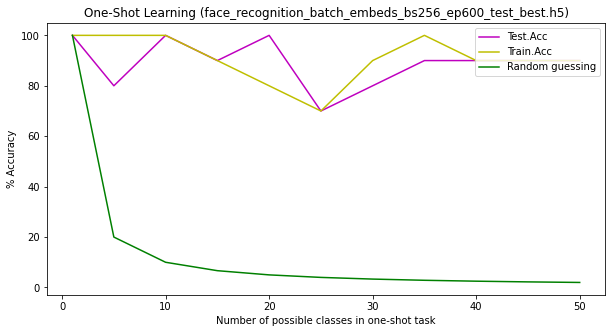

In [121]:
test_trained_models(embeds_model_after_l2, model_type="embeds")

### Examples:

In [115]:
def load_model(model, weights):
    
    weights_path = "output/siamese_model/weights/" + weights
    model.load_weights(weights_path)
    model.save("output/siamese_model/epoch_embeds_bs256_ep680_test_best.h5")
    return model
    
model = load_model(embeds_model,'epoch_embeds_bs256_ep680_test_best.h5')

In [116]:
pairs, targets = get_pairs(10, False, True, False, do_shuffle=False)
pairs[0].shape

(10, 128, 1)

In [117]:
model.predict(pairs)

array([[0.47429353],
       [0.4829782 ],
       [0.46227938],
       [0.45999718],
       [0.45164144],
       [0.56703997],
       [0.53430146],
       [0.48806864],
       [0.53078973],
       [0.57020324]], dtype=float32)

In [37]:
np.expand_dims(pairs[0][0], axis=0).shape

(1, 128, 1)